**Table of contents**<a id='toc0_'></a>    
- 1. [Импорты и константы](#toc1_)    
- 2. [Предобработка данных](#toc2_)    
- 3. [Исследовательский аналази данных](#toc3_)    
  - 3.1. [Посмотрим на размер и данные в датасете](#toc3_1_)    
  - 3.2. [Изучение дисбаланса классов](#toc3_2_)    
  - 3.3. [acousticness - акустичность](#toc3_3_)    
  - 3.4. [danceability - танцевальность](#toc3_4_)    
  - 3.5. [duration_ms - продолжительность в милисекундах](#toc3_5_)    
  - 3.6. [energy - энергичность](#toc3_6_)    
  - 3.7. [instrumentalness - инструментальность](#toc3_7_)    
  - 3.8. [liveness - привлекательность](#toc3_8_)    
  - 3.9. [loudness - громкость](#toc3_9_)    
  - 3.10. [speechiness - выразительность](#toc3_10_)    
  - 3.11. [tempo - темп](#toc3_11_)    
  - 3.12. [valence - привлекательность произведения для пользователей сервиса](#toc3_12_)    
  - 3.13. [key - базовый ключ (нота) произведения](#toc3_13_)    
  - 3.14. [mode - указывает на модальность (мажорную или минорную) трека](#toc3_14_)    
- 4. [Построение baseline](#toc4_)    
- 5. [Эксперимент: борьба с дисбалансов с помощью `class_weight='balanced'`](#toc5_)    
- 6. [Эксперимент: борьба с дисбалансов с помощью `upsample`](#toc6_)    
- 7. [Эксперимент: борьба с дисбалансов с помощью `upsample` и удаление выбросов](#toc7_)    
- 8. [Эксперимент: борьба с дисбалансов с помощью `upsample` и удаление выбросов. Заполнение пропусков для tempo и duration_ms](#toc8_)    
- 9. [Эксперимент: борьба с дисбалансов с помощью `upsample` и удаление выбросов. Заполнение пропусков для tempo и duration_ms. Удаление столбцов key, mode](#toc9_)    
- 10. [Выводы](#toc10_)    
- 11. [Первый вариант отправки результатов](#toc11_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Импорты и константы](#toc0_)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import mlModule.constants as constants
import mlModule.eda as eda
import mlModule.preprocessing as preprocessing
import mlModule.train_model as train_model
import mlModule.utils as utils

In [2]:
data = utils.get_data()

In [3]:
START_DATA_SIZE = data.shape[0]

# 2. <a id='toc2_'></a>[Предобработка данных](#toc0_)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [5]:
data.head()

instance_id                  track_name  acousticness  danceability  \
0      25143.0                  Highwayman        0.4800         0.670   
1      26091.0       Toes Across The Floor        0.2430         0.452   
2      87888.0       First Person on Earth        0.2280         0.454   
3      77021.0  No Te Veo - Digital Single        0.0558         0.847   
4      20852.0             Chasing Shadows        0.2270         0.742   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0     182653.0   0.351          0.017600   D     0.115   -16.842  Major   
1     187133.0   0.670          0.000051   A     0.108    -8.392  Minor   
2     173448.0   0.804          0.000000   E     0.181    -5.225  Minor   
3     255987.0   0.873          0.000003  G#     0.325    -4.805  Minor   
4     195333.0   0.575          0.000002   C     0.176    -5.550  Major   

   speechiness    tempo obtained_date  valence  music_genre  
0       0.0463  101.384         4-Apr    0.450      Country  
1       0.0352  113.071         4-Apr    0.539         Rock  
2       0.3710   80.980         4-Apr    0.344  Alternative  
3       0.0804  116.007         4-Apr    0.966      Hip-Hop  
4       0.0487   76.494         4-Apr    0.583  Alternative

In [6]:
data.dropna(inplace=True)

In [7]:
data.duplicated().sum()

0

В датасете нет дубликатов

In [8]:
string_column = ['track_name', 'key', 'mode', 'obtained_date', 'music_genre']
data = preprocessing.preprocessing_string_column(data, string_column)

In [9]:
print(f'В результате удаления пропущенных значений и явных дубликатов в '
      f'датасете осталось {data.shape[0] / START_DATA_SIZE:.2%} данных')

В результате удаления пропущенных значений и явных дубликатов в датасете осталось 91.96% данных


# 3. <a id='toc3_'></a>[Исследовательский аналази данных](#toc0_)

## 3.1. <a id='toc3_1_'></a>[Посмотрим на размер и данные в датасете](#toc0_)

В датасете чуть более 20000 строк. Однако некоторые колонки имеют пропуски.  
К количественным признакам относятся столбцы:
* acousticness - акустичность
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* liveness - привлекательность
* loudness - громкость
* speechiness - выразительность
* tempo - темп
* valence - привлекательность произведения для пользователей сервиса


К категориальным с признакам относятся столбцы:
* track_name - название трека  
* key - базовый ключ (нота) произведения
* mode - указывает на модальность (мажорную или минорную) трека
* obtained_date - дата загрузки в сервис


Целевое признак находится в столбце music_genre (музыкальный жанр)

## 3.2. <a id='toc3_2_'></a>[Изучение дисбаланса классов](#toc0_)

In [10]:
data.groupby('music_genre')['instance_id'].count()

music_genre
alternative    2398
anime          1751
blues          2628
classical      1267
country        1946
electronic     2363
hip-hop        1058
jazz           1158
rap            2210
rock           1975
Name: instance_id, dtype: int64

In [11]:
data_plot = data.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)
#sns.pairplot(data_plot, hue='music_genre', plot_kws={'alpha': 0.1})

acousticness  danceability  duration_ms    energy  \
acousticness          1.000000     -0.273237     0.046802 -0.764678   
danceability         -0.273237      1.000000    -0.146138  0.183294   
duration_ms           0.046802     -0.146138     1.000000 -0.057486   
energy               -0.764678      0.183294    -0.057486  1.000000   
instrumentalness      0.319564     -0.253828     0.142109 -0.321163   
liveness             -0.091182     -0.079297     0.032049  0.176234   
loudness             -0.699626      0.315529    -0.099702  0.821459   
speechiness          -0.144917      0.258334    -0.082223  0.151155   
tempo                -0.216577     -0.059486    -0.042661  0.250851   
valence              -0.224391      0.391941    -0.125683  0.350350   

                  instrumentalness  liveness  loudness  speechiness     tempo  \
acousticness              0.319564 -0.091182 -0.699626    -0.144917 -0.216577   
danceability             -0.253828 -0.079297  0.315529     0.258334 -0.059486   
duration_ms               0.142109  0.032049 -0.099702    -0.082223 -0.042661   
energy                   -0.321163  0.176234  0.821459     0.151155  0.250851   
instrumentalness          1.000000 -0.063952 -0.482528    -0.176356 -0.097125   
liveness                 -0.063952  1.000000  0.108233     0.097633  0.038290   
loudness                 -0.482528  0.108233  1.000000     0.151618  0.221536   
speechiness              -0.176356  0.097633  0.151618     1.000000  0.065866   
tempo                    -0.097125  0.038290  0.221536     0.065866  1.000000   
valence                  -0.259166  0.037236  0.285109     0.032113  0.085729   

                   valence  
acousticness     -0.224391  
danceability      0.391941  
duration_ms      -0.125683  
energy            0.350350  
instrumentalness -0.259166  
liveness          0.037236  
loudness          0.285109  
speechiness       0.032113  
tempo             0.085729  
valence           1.000000

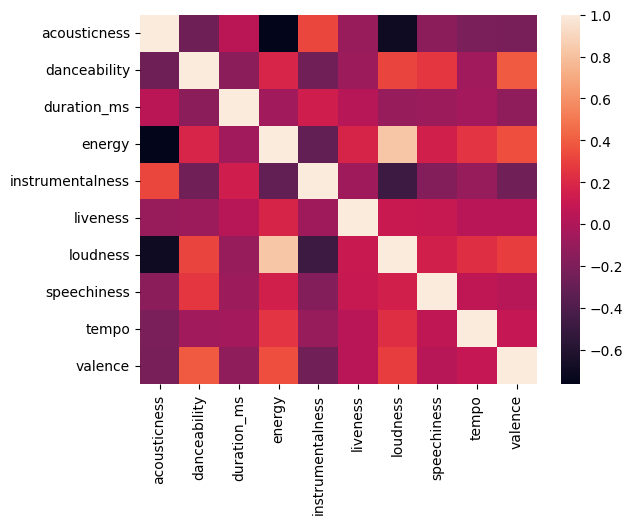

In [12]:
numeric_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
corr_matrix = data[numeric_columns].corr()
sns.heatmap(corr_matrix)
corr_matrix

## 3.3. <a id='toc3_3_'></a>[acousticness - акустичность](#toc0_)

Выведем описательную статиcтику по окустичности

In [13]:
data['acousticness'].describe()

count    18754.000000
mean         0.275025
std          0.321970
min          0.000000
25%          0.015000
50%          0.121000
75%          0.471000
max          0.996000
Name: acousticness, dtype: float64

mean   median       min    max
music_genre                                    
alternative  0.165384  0.03150  0.000001  0.984
anime        0.272324  0.05190  0.000000  0.996
blues        0.310891  0.20650  0.000002  0.995
classical    0.878808  0.96900  0.000005  0.996
country      0.273586  0.19000  0.000108  0.971
electronic   0.121596  0.02630  0.000003  0.984
hip-hop      0.181910  0.10700  0.000087  0.936
jazz         0.501659  0.52100  0.000008  0.996
rap          0.168338  0.09415  0.000007  0.942
rock         0.196852  0.07330  0.000006  0.994

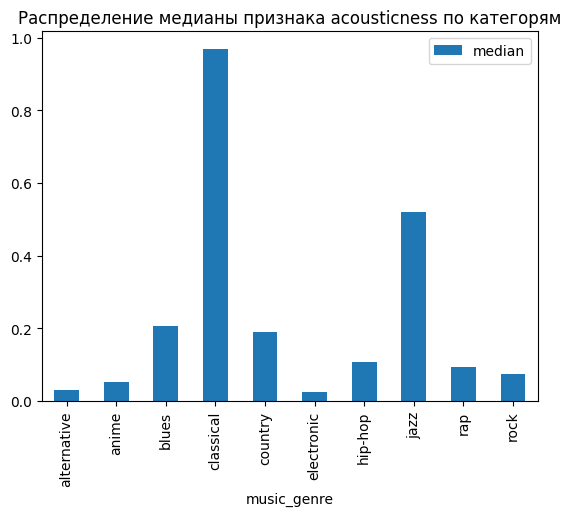

In [14]:
eda.create_pivot_table(data, 'music_genre', 'acousticness')

Из сводной таблицы и графика видно, что жанры `classical` и `jazz` обладают самой большим значением медианы музыкальности. Наиболее выделяется жанр `classical`

Построим график violinlpot

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


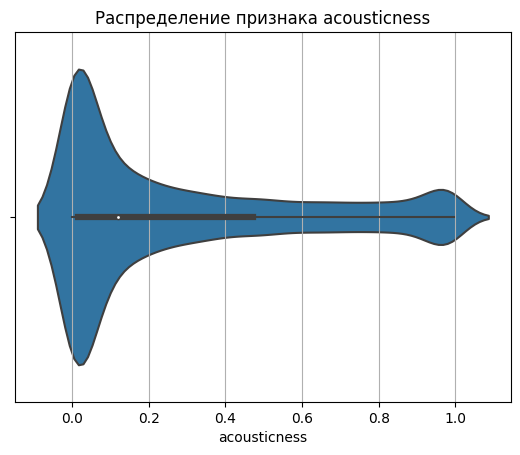

In [15]:
eda.create_violinplot(data, 'acousticness')

График плотности имеет 2 вершины: основная около 0 и маленькая около 1.  
Чтобы подробнее изучить распределение данного параметра, сгруппируем данные по категориям и для каждой категории построим такой же график

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

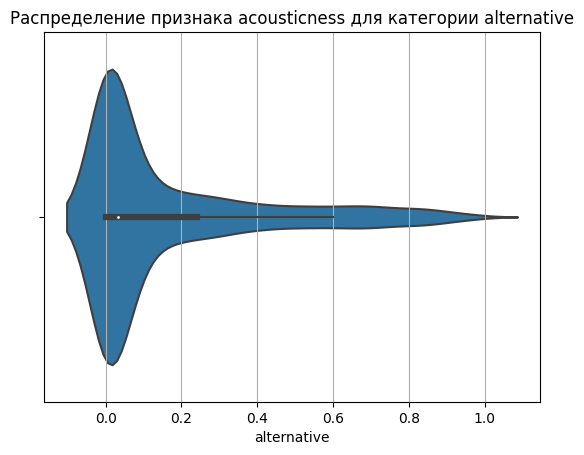

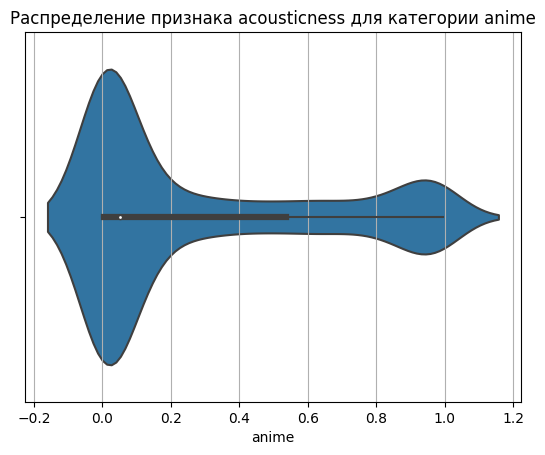

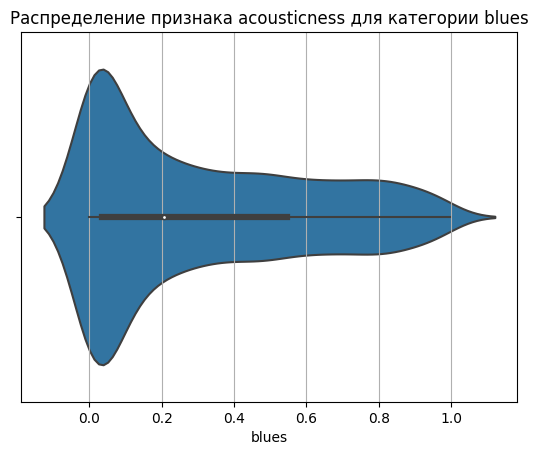

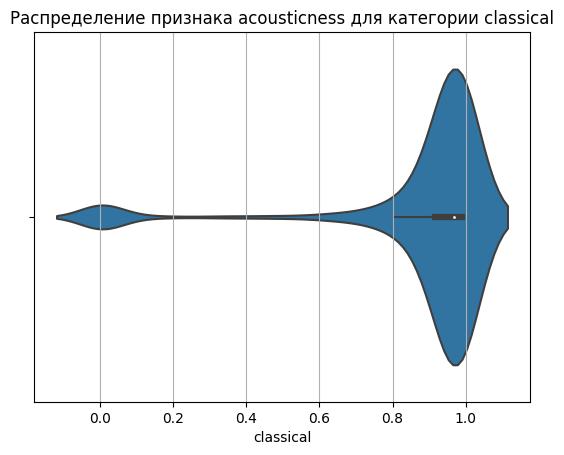

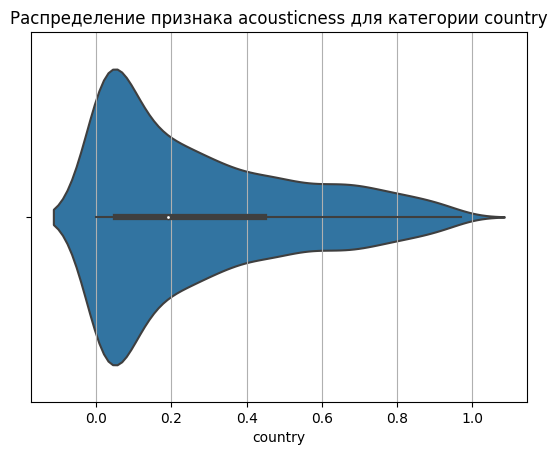

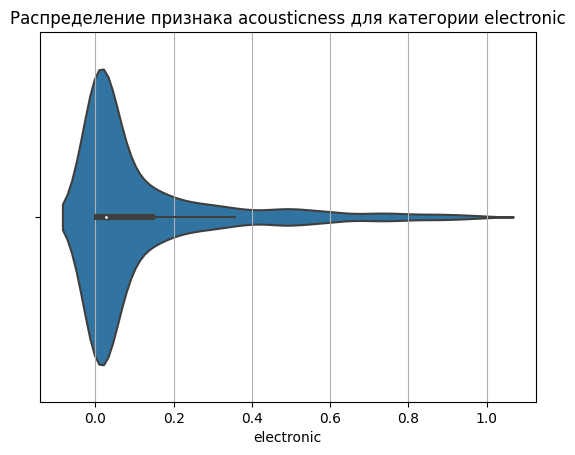

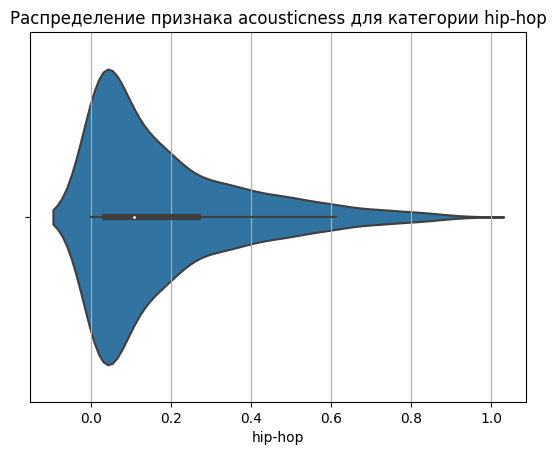

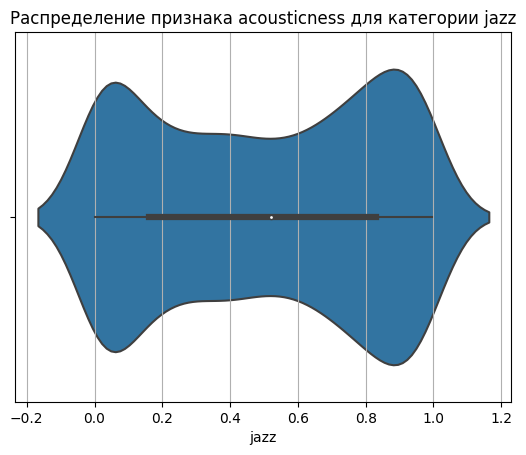

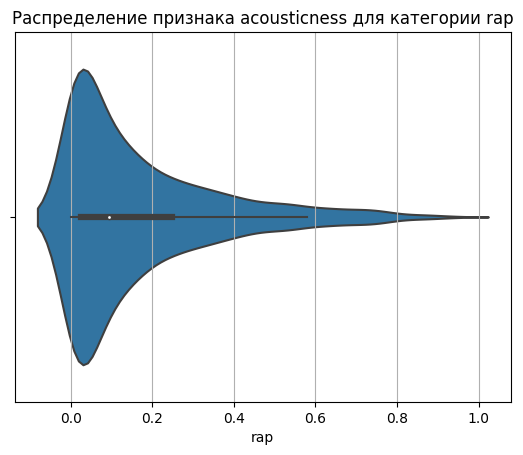

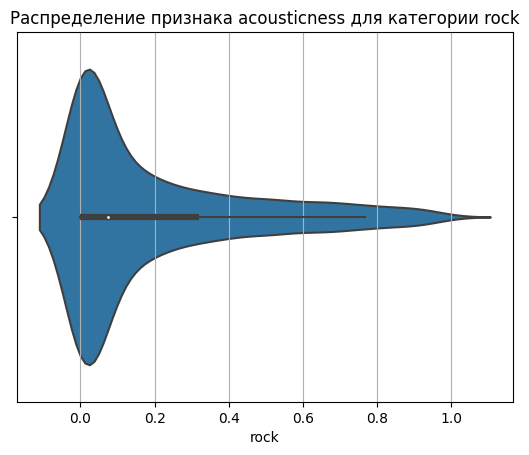

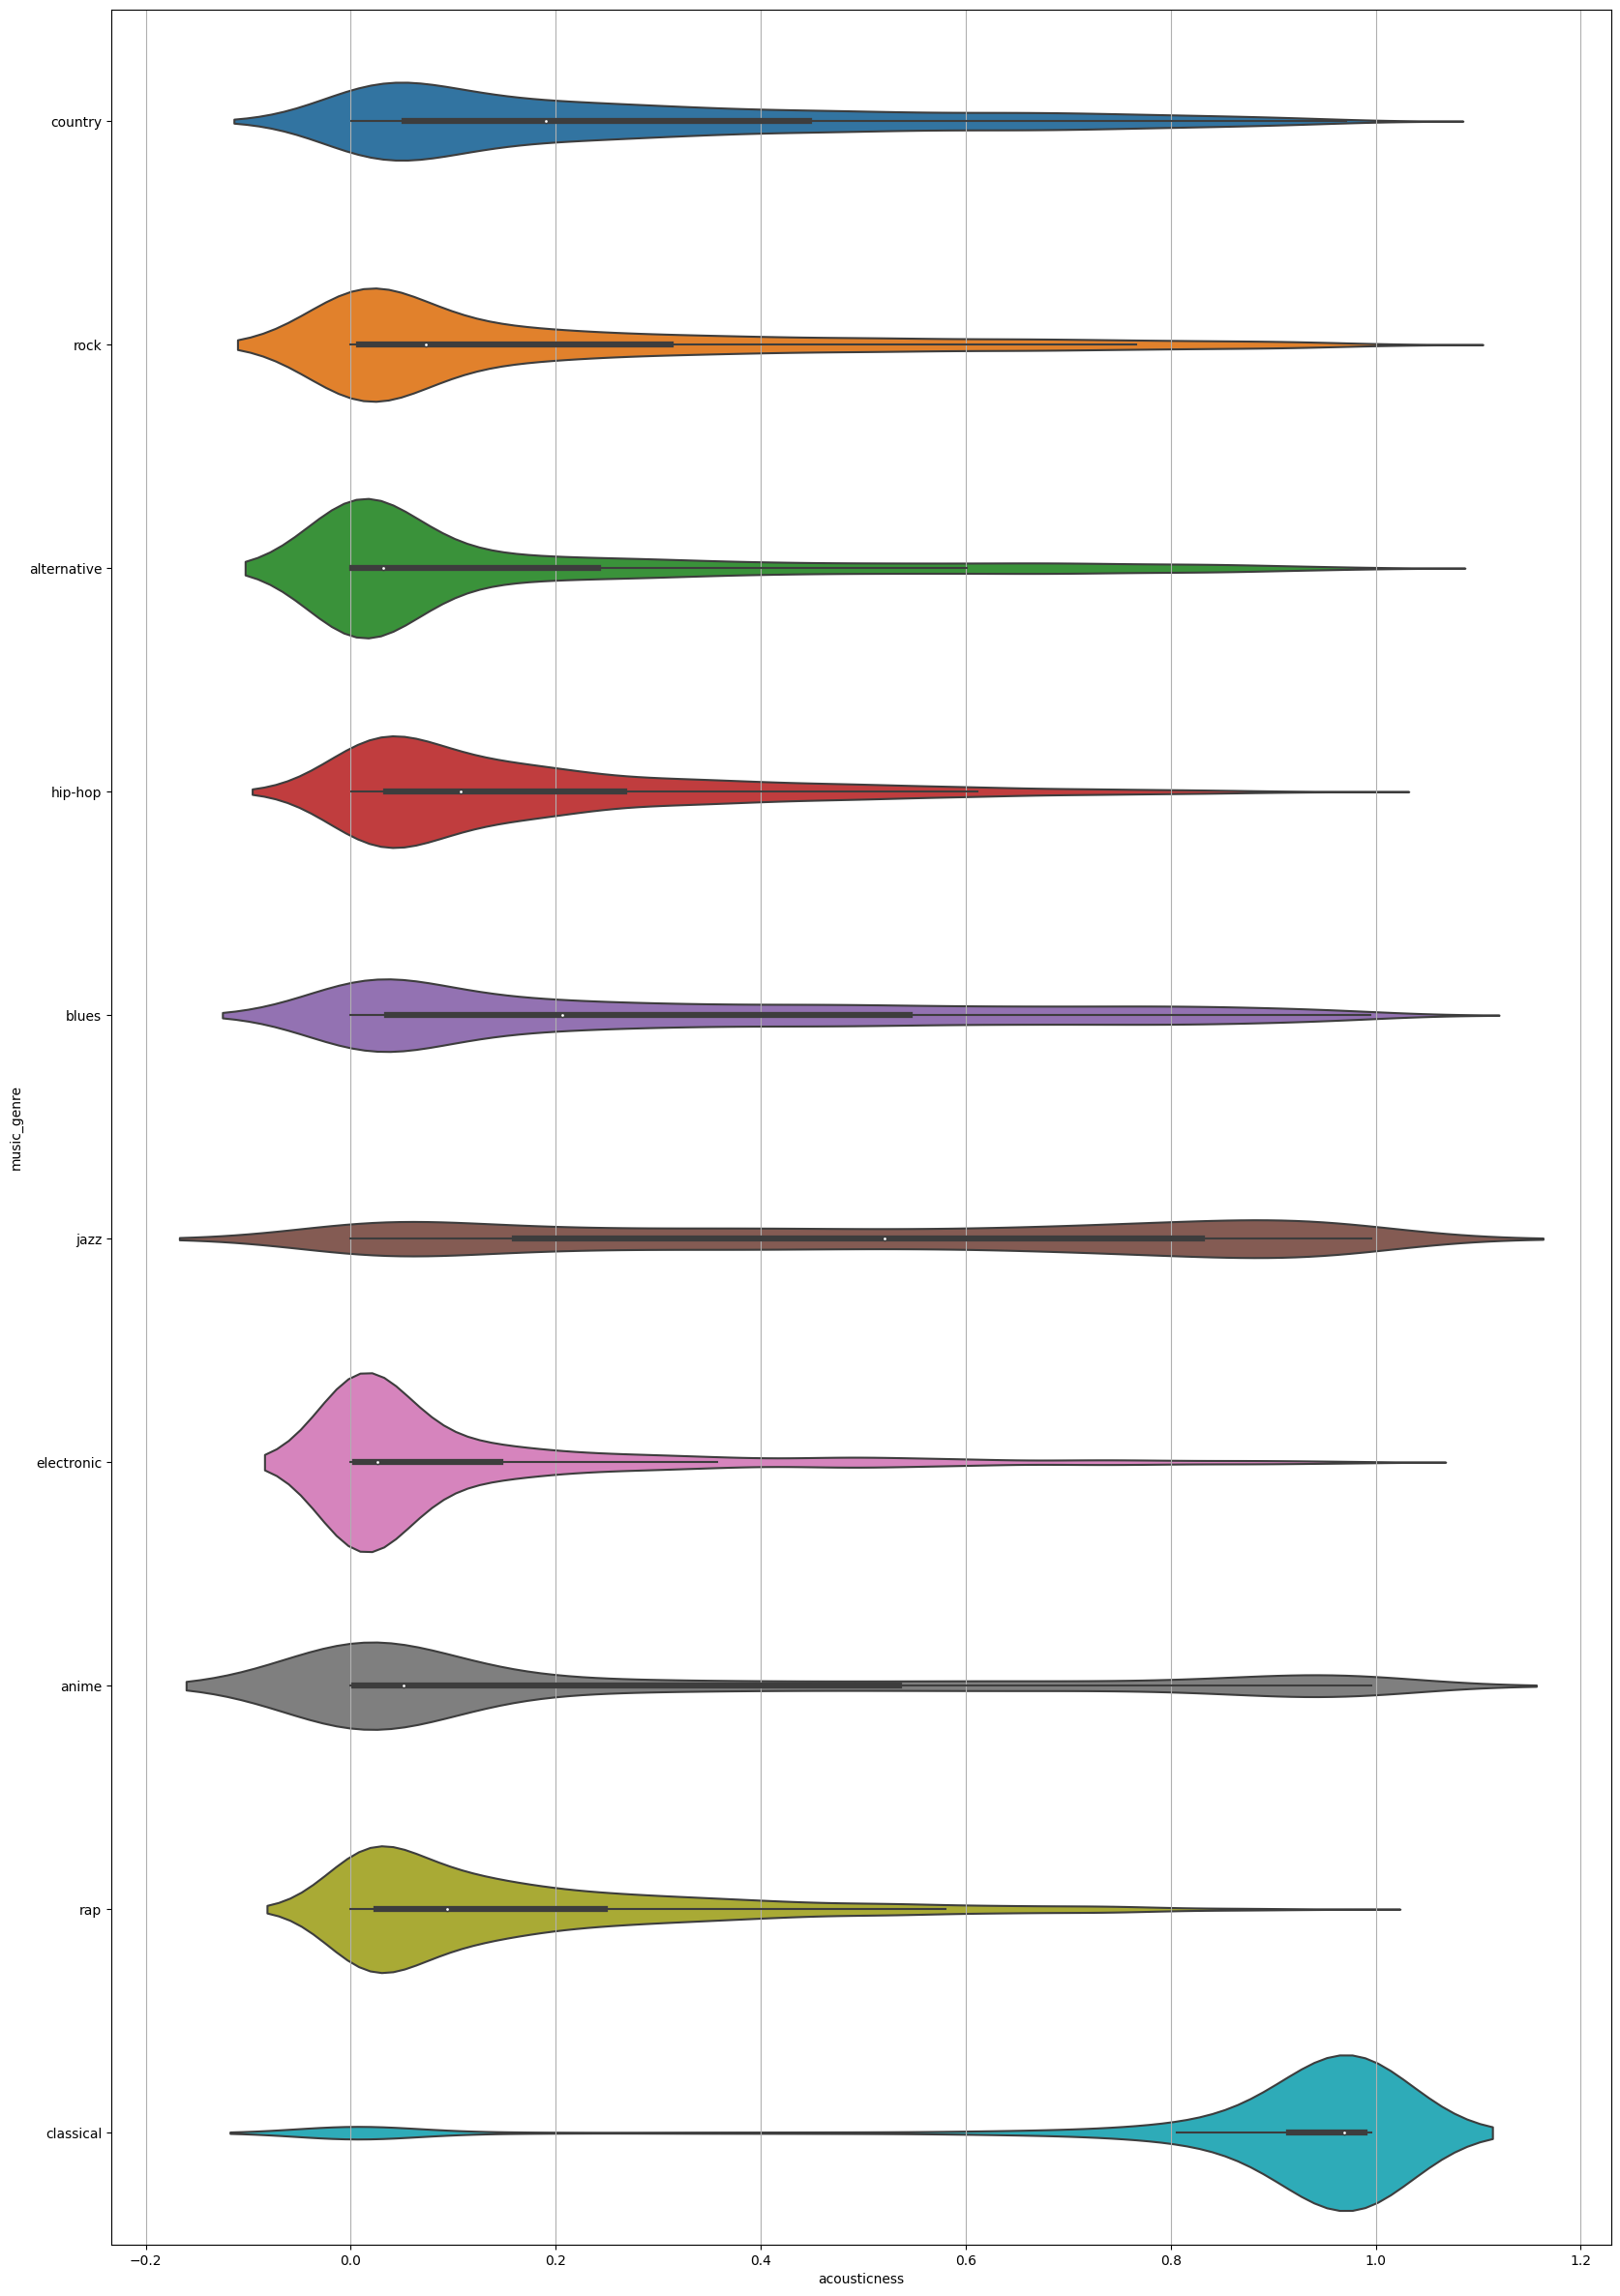

In [16]:
eda.create_category_violinplot(data, 'music_genre', 'acousticness', True)

Из полученных графиков можно увидеть несколько особенностей:
1. Из всех жанров выделяется музыка с жанром `classical`. Пик ее распределения находится не около 0 (как у большинства жанров), а около 1. При этом около 0 таже есть небольшой пик. Однако он находится за пределами усов, поэтому, возможно, это выбросы. Либо это поджанр классической музыки, который обладает невыской акустичностью
2. График плотности жанра `jazz` имеет 2 равнозначных пика: около 0 и около 1. Скорее всего, данный жанр не получится отделить данным параметром.
3. Плотность графика жанра `anime` также имеет 2 пика. Однако в отличии от жанра `jazz` пик около 0 более выраженный, чем пик около 1.

## 3.4. <a id='toc3_4_'></a>[danceability - танцевальность](#toc0_)

In [17]:
data['danceability'].describe()

count    18754.000000
mean         0.561725
std          0.171969
min          0.060000
25%          0.451000
50%          0.570000
75%          0.682000
max          0.978000
Name: danceability, dtype: float64

mean  median     min    max
music_genre                                 
alternative  0.545996   0.544  0.1030  0.949
anime        0.468861   0.482  0.0606  0.888
blues        0.526990   0.529  0.1480  0.955
classical    0.303753   0.298  0.0600  0.756
country      0.580139   0.583  0.2030  0.953
electronic   0.618282   0.631  0.0822  0.969
hip-hop      0.718776   0.736  0.2840  0.978
jazz         0.582520   0.597  0.0644  0.955
rap          0.701716   0.720  0.1970  0.975
rock         0.536079   0.545  0.0789  0.883

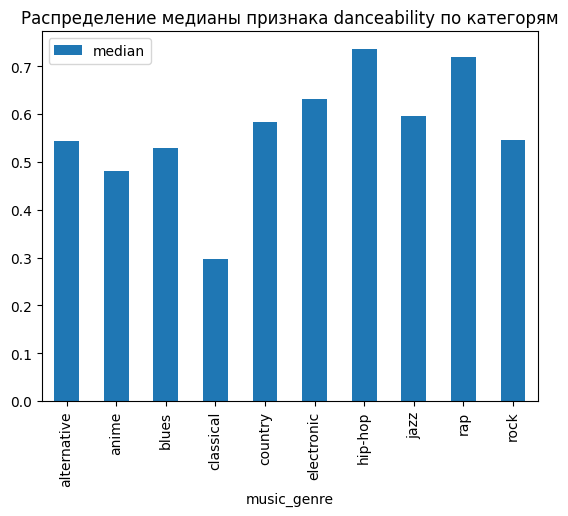

In [18]:
eda.create_pivot_table(data, 'music_genre', 'danceability')

Из сводной таблицы и гистограммы видно, что жанры `hip-hop` и `rap` имею максимальное значение медианы данного критерия (0.736 и 0.720 соответственно). Также сильно выделяется жанр `classical` - он имеет минимальное медианное значение 0.298, что сильно меньше, чем у остальных жанров.

Посмотрим на скрипичную диаграмму для данного критерия по всем данным

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


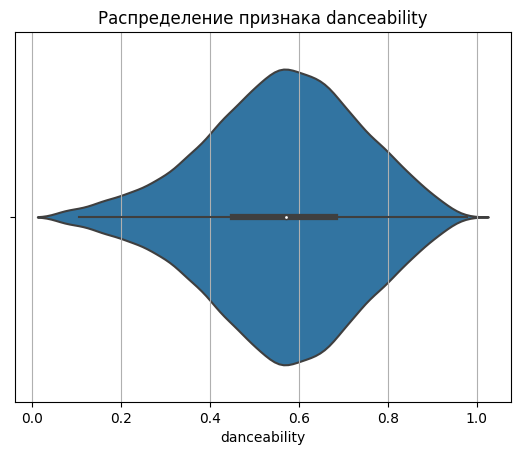

In [19]:
eda.create_violinplot(data, 'danceability')

График распределения похож на нормальное распределение с большое дисперсией. Также видно, что имеются выбросы.  
Чтобы подробнее изучить распределение данного параметра, сгруппируем данные по категориям и для каждой категории построим такой же график

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

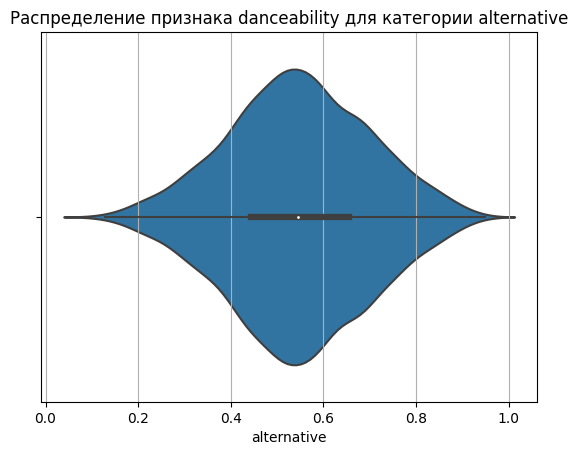

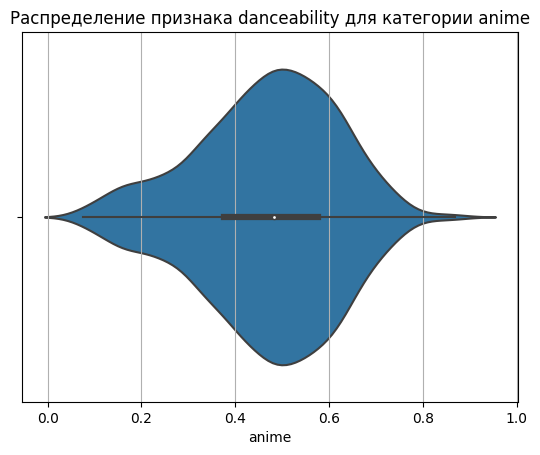

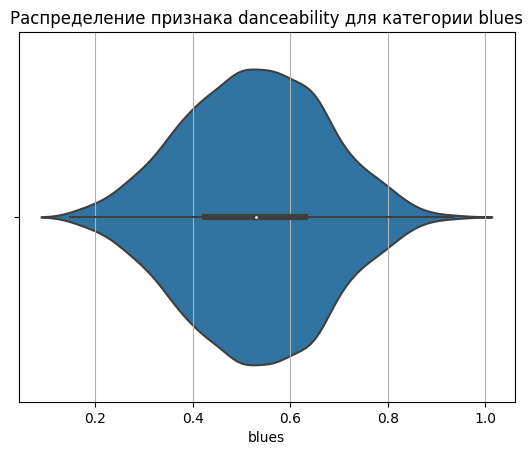

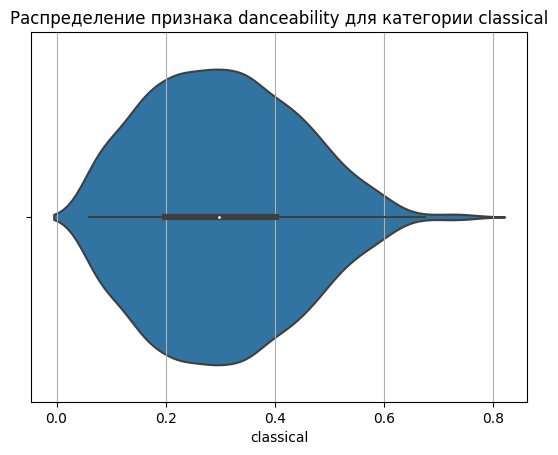

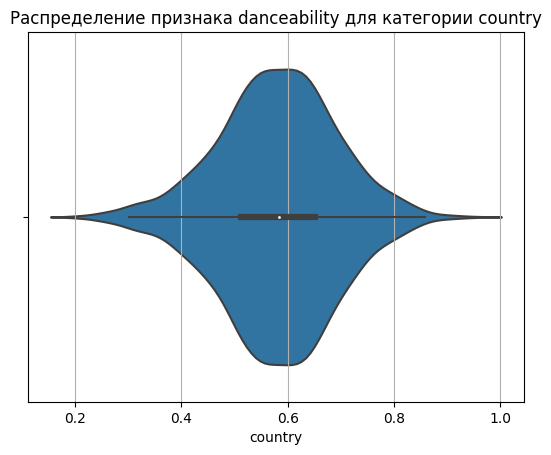

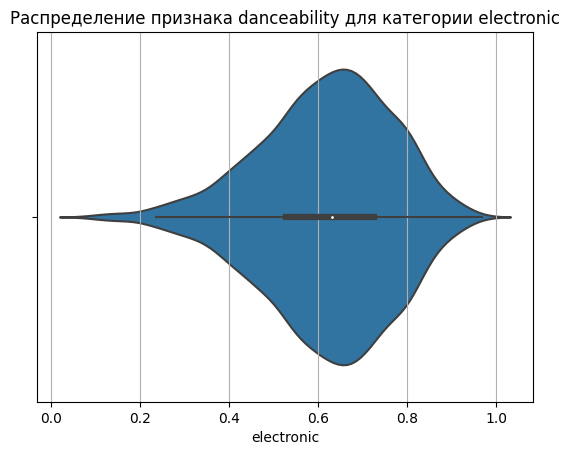

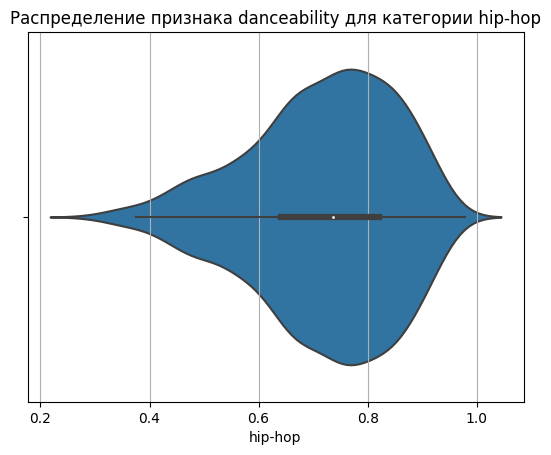

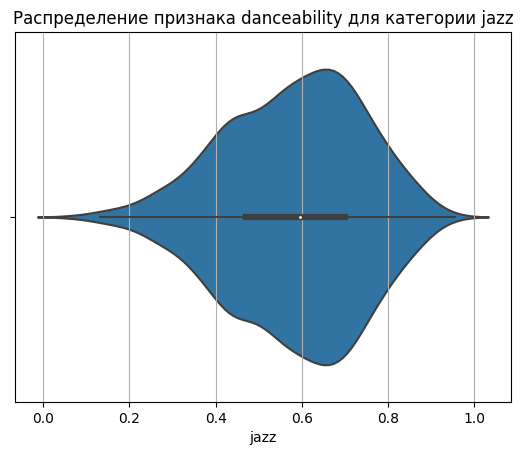

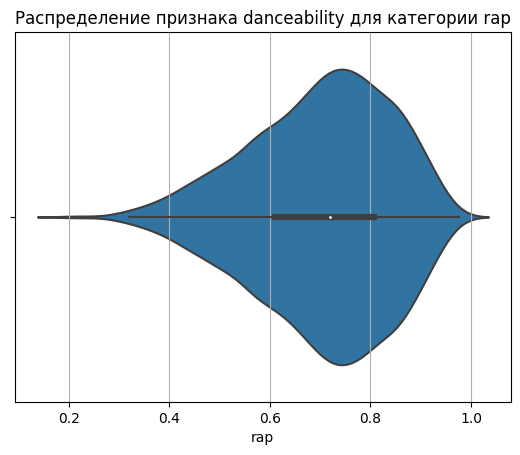

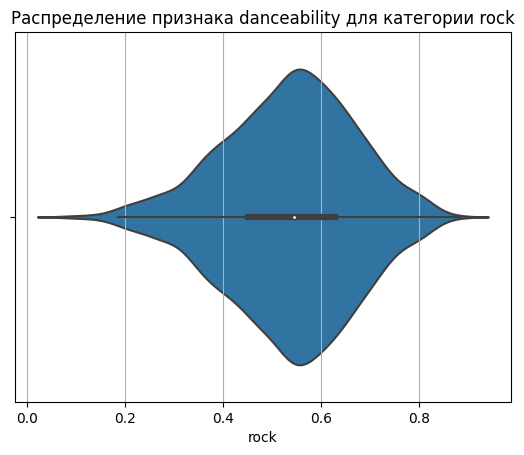

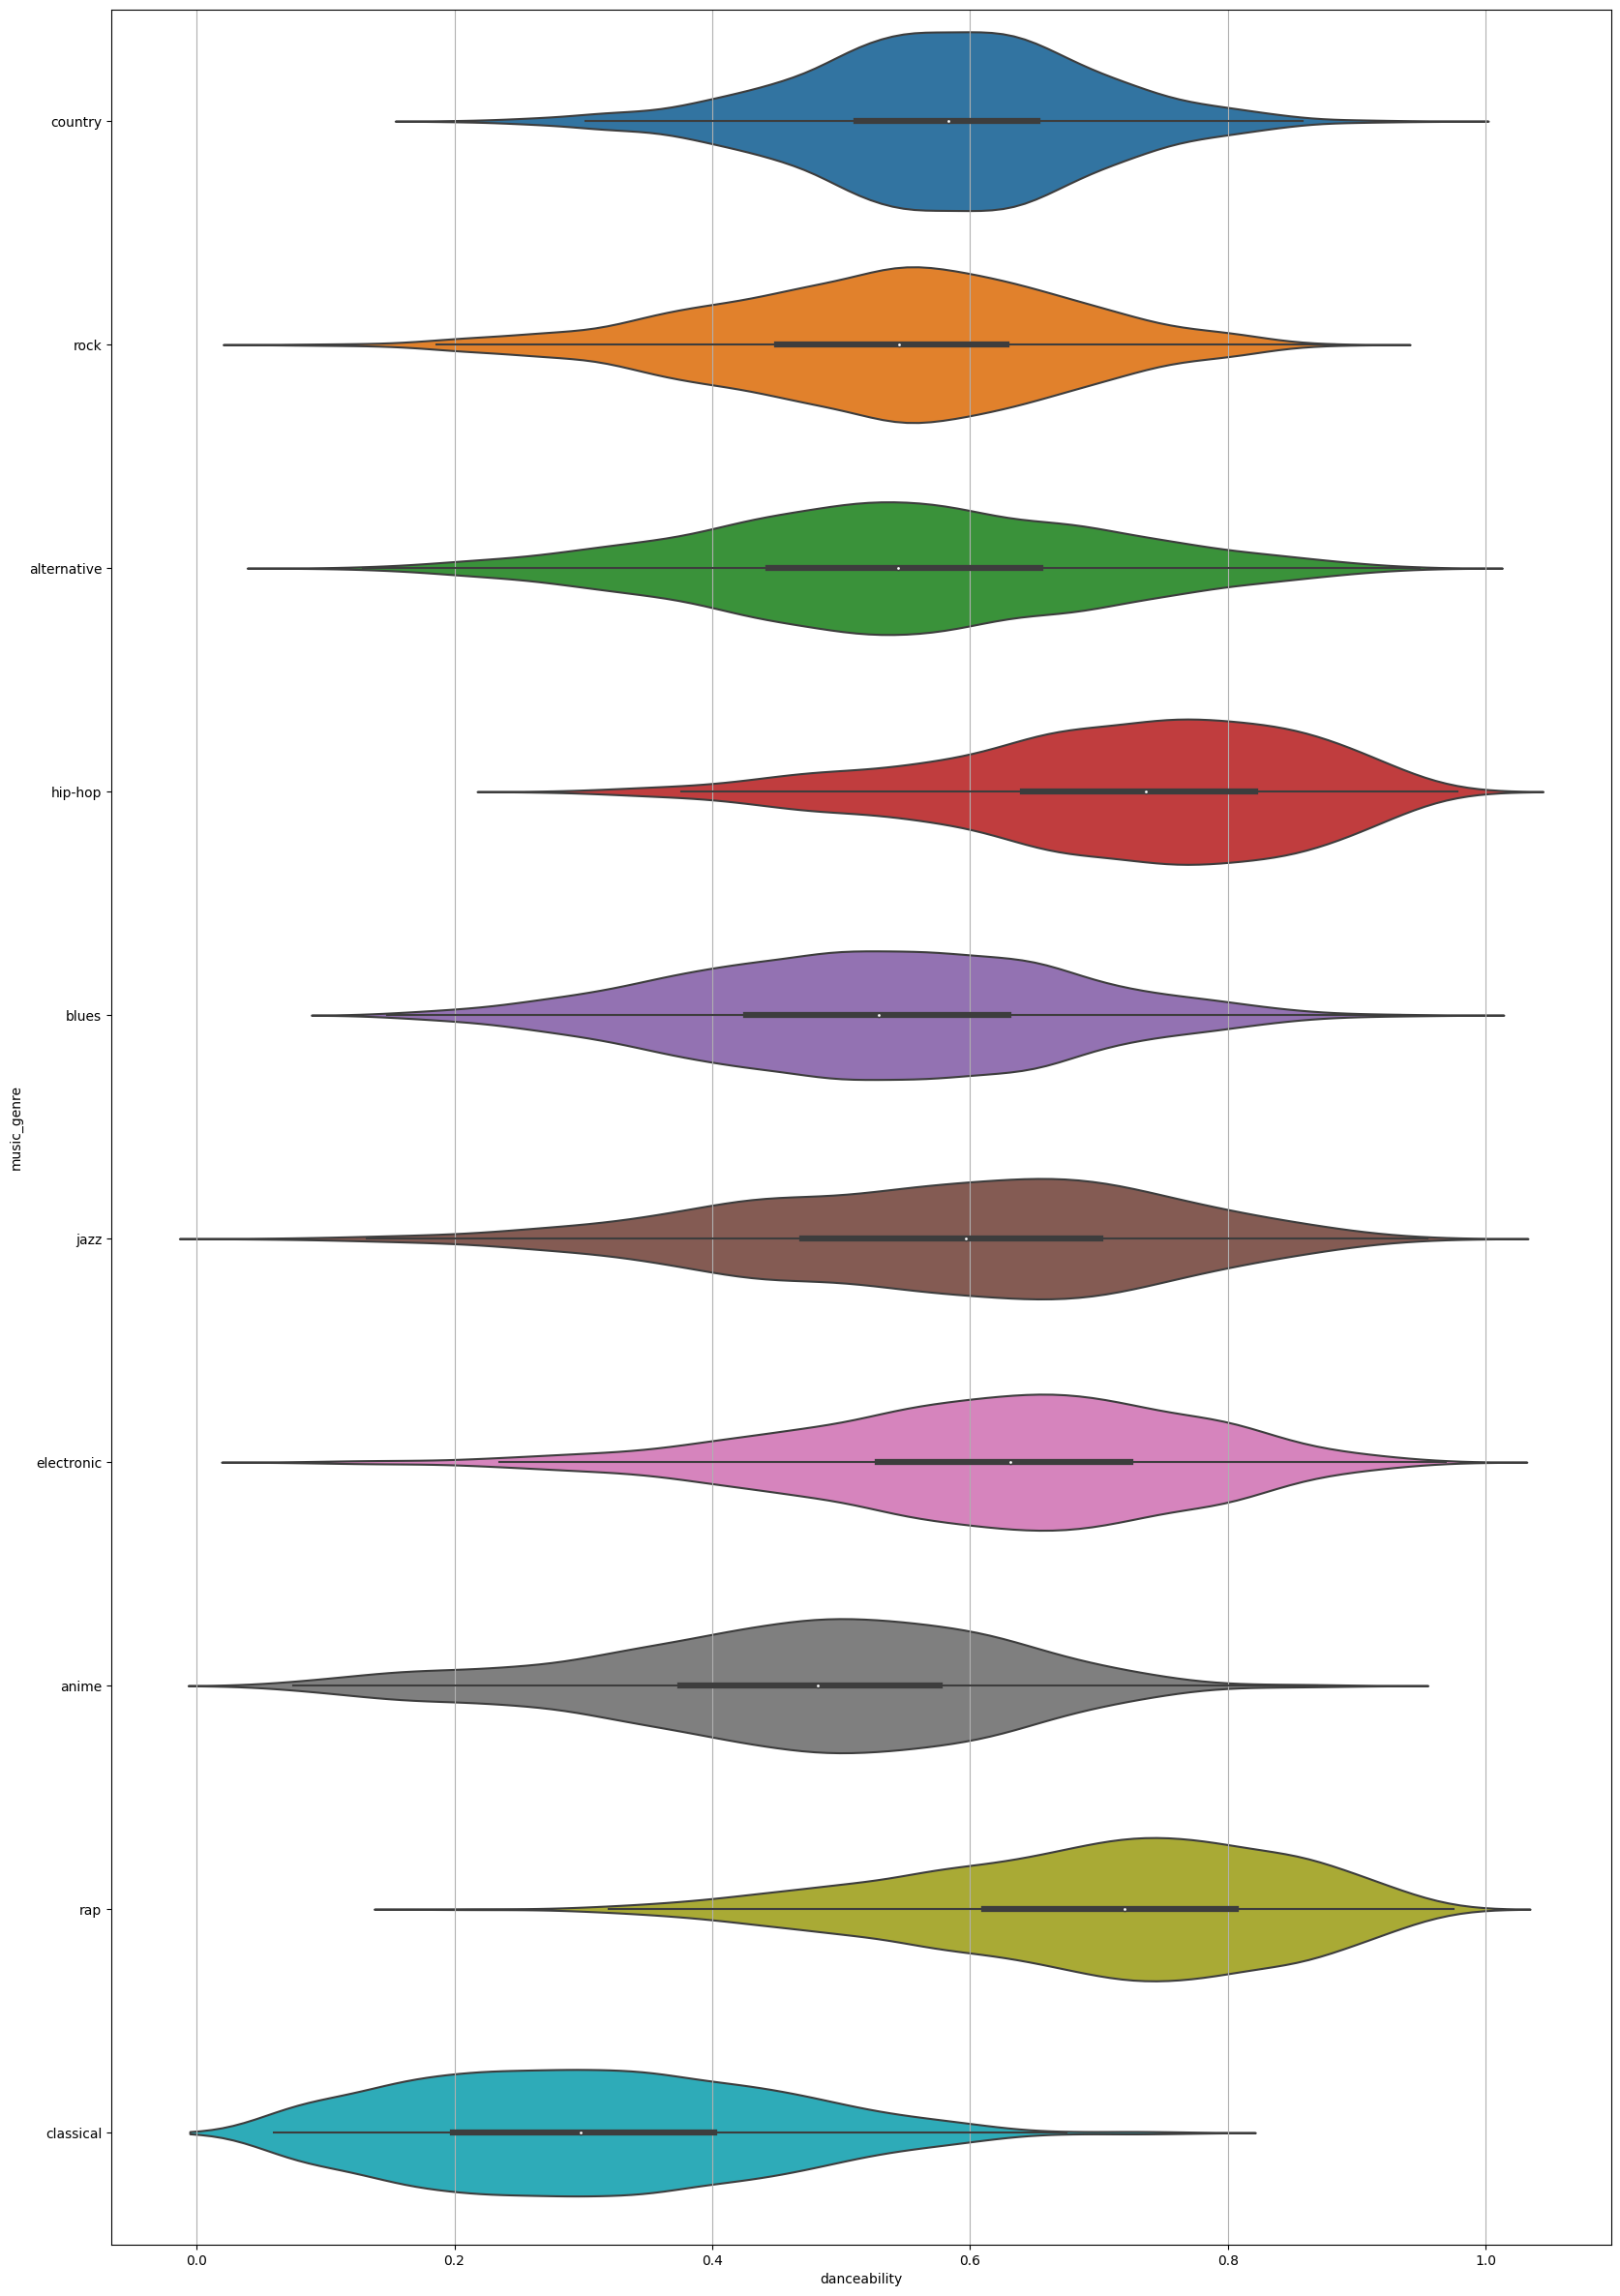

In [20]:
eda.create_category_violinplot(data, 'music_genre', 'danceability', True)

Распределение плотности данного критерия для каждой категории очень похожи. Основное отличие заключается в мат ожидании распределения. У жанров `hip-hop` и `rap` мат ожидание наиболее смещено к 1. У жанра `classial` наоброт мат ожидание имеет наименьшее значение, поэтому график наиболее смещен влево. Данная информаци подтверждает те выводы, которые были сделаны из сводной таблицы и гистограммы распределения медиан.

## 3.5. <a id='toc3_5_'></a>[duration_ms - продолжительность в милисекундах](#toc0_)

In [21]:
data['duration_ms'].describe()

count    1.875400e+04
mean     2.207254e+05
std      1.273069e+05
min     -1.000000e+00
25%      1.775178e+05
50%      2.197095e+05
75%      2.665068e+05
max      4.497994e+06
Name: duration_ms, dtype: float64

mean    median  min        max
music_genre                                         
alternative  209029.991660  219790.5 -1.0   638427.0
anime        209344.267847  230587.0 -1.0  1086493.0
blues        230128.332953  221220.0 -1.0  1509587.0
classical    285654.669298  245533.0 -1.0  1778440.0
country      194698.652621  207251.5 -1.0   477573.0
electronic   244215.267457  236133.0 -1.0  4497994.0
hip-hop      194705.714556  206967.5 -1.0   485729.0
jazz         244552.388601  236840.0 -1.0  1352413.0
rap          195915.475566  207853.5 -1.0   579293.0
rock         216120.534684  221000.0 -1.0   811077.0

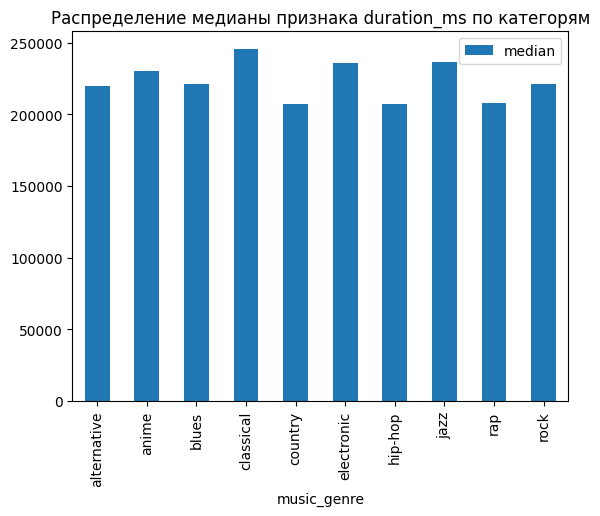

In [22]:
eda.create_pivot_table(data, 'music_genre', 'duration_ms')

Из гистограммы видно, что медианное значение параметра находится примерно на одном уровне у каждой категории. Однако среди максимальных значений у категорий можно найти отличия:  
1. Категория `electronic` имеет самое большое максимальное значние 4497994 мс. Результат очень сильно отличается от других катекорий. Однако, возможно, это выброс и стоит проверить это
2. Категории `anime`, `blues`, `classica`, `jazz` имеею максимальную продолжительность более 1000000 мс. Однако данные в этих категория также стоит проверить на выбросы.  
3. Остальные катеригии имеют максимальное значение менее 1000000 мс  
  
Также стоит отбратить внимание на то, что во всех категориях минимальное значение составляет -1. Так как Мы исследуем признак `продолжительность в мс`, то таких значение быть не может. Следовательно, значние -1 появилось в результате ошибки или технического сбоя. Семплы, которые содержат это значение нужно либо удалить, либо заменить значение чем-либо другим.

Посмотрим, какое количество семплов имеет отрицательное значение данного критерия. Также проверим, принимает ли данные признак другие отрицательные значения

In [23]:
df_temp = data.query('duration_ms <= 0')
df_temp['duration_ms'].unique()

array([-1.])

In [24]:
df_temp['duration_ms'].count()

1840

In [25]:
df_temp.groupby('music_genre')['duration_ms'].count()

music_genre
alternative    249
anime          162
blues          235
classical      123
country        201
electronic     229
hip-hop        109
jazz           106
rap            230
rock           196
Name: duration_ms, dtype: int64

Можно заметить, что из отрицательных значений данные признак принимает только значение -1. Таких семплов в датасете 1840 и содержатся они во всех категориях

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


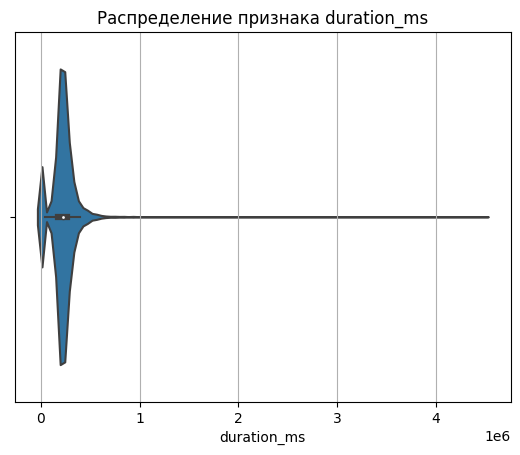

In [26]:
eda.create_violinplot(data, 'duration_ms')

Распределение похоже на нормальное с длинным правы хвостом. Видно, что признако содержит много уникальных значений, которые с высокой долей вероятности являются выбросами. Также около 0 наблюдается еще один небольшой пик.  
Чтобы подробнее изучить распределение данного параметра, сгруппируем данные по категориям и для каждой категории построим такой же график

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

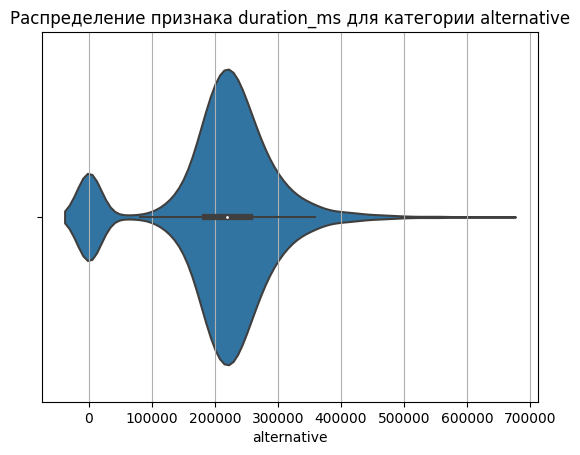

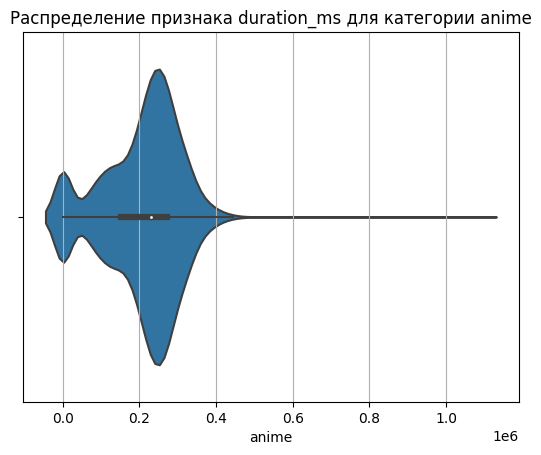

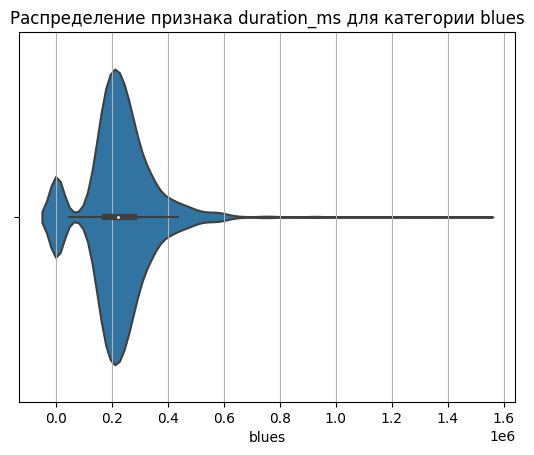

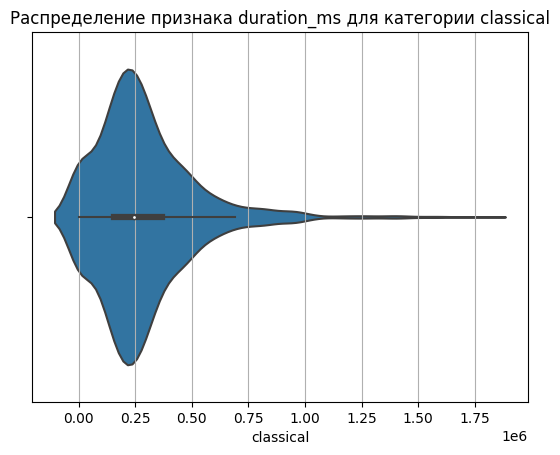

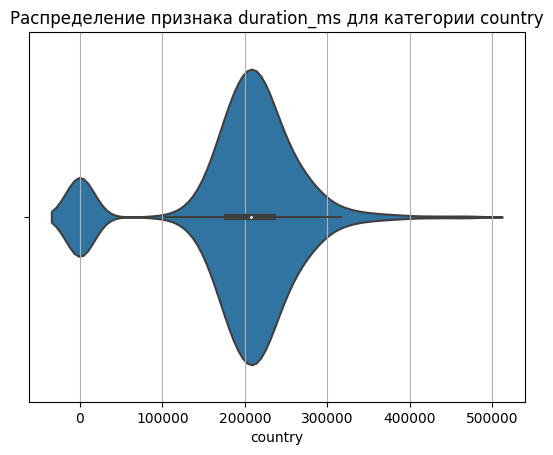

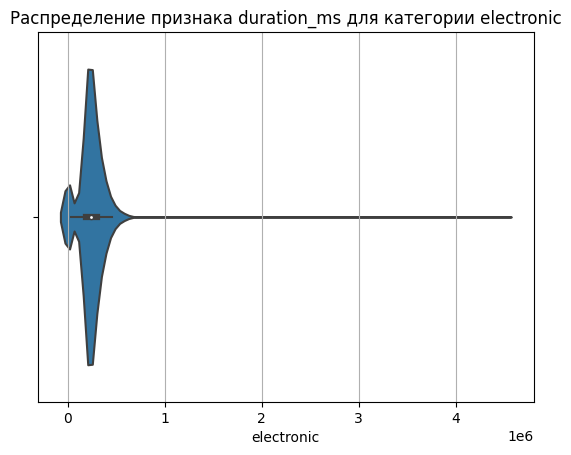

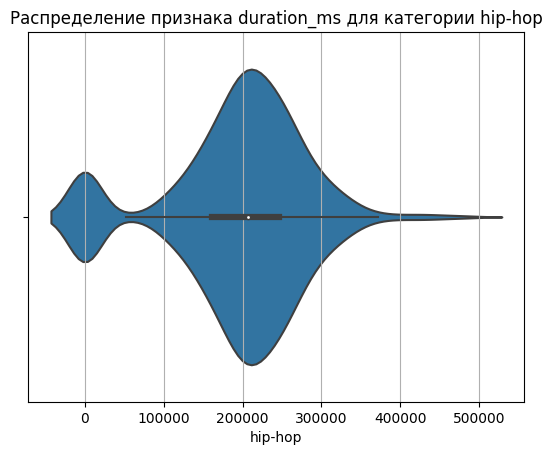

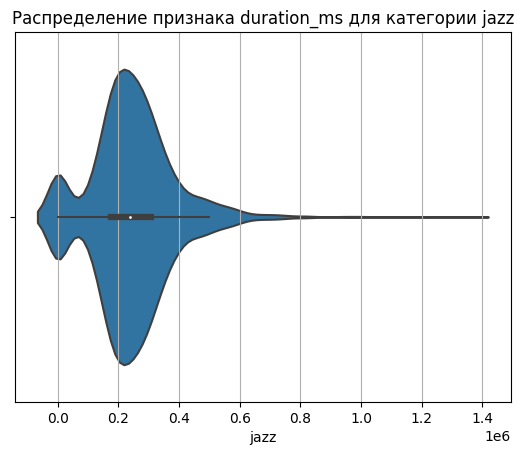

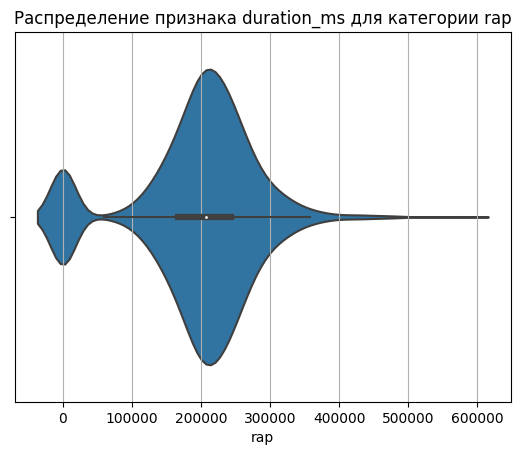

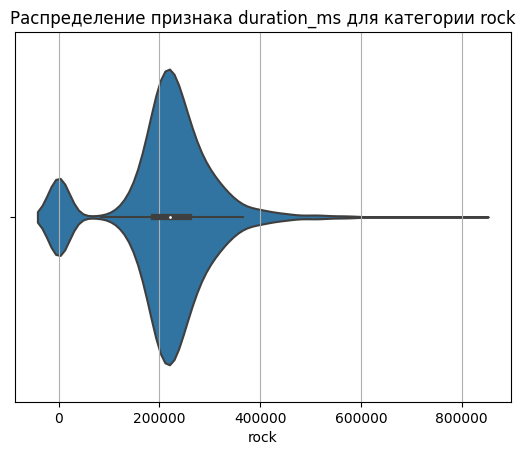

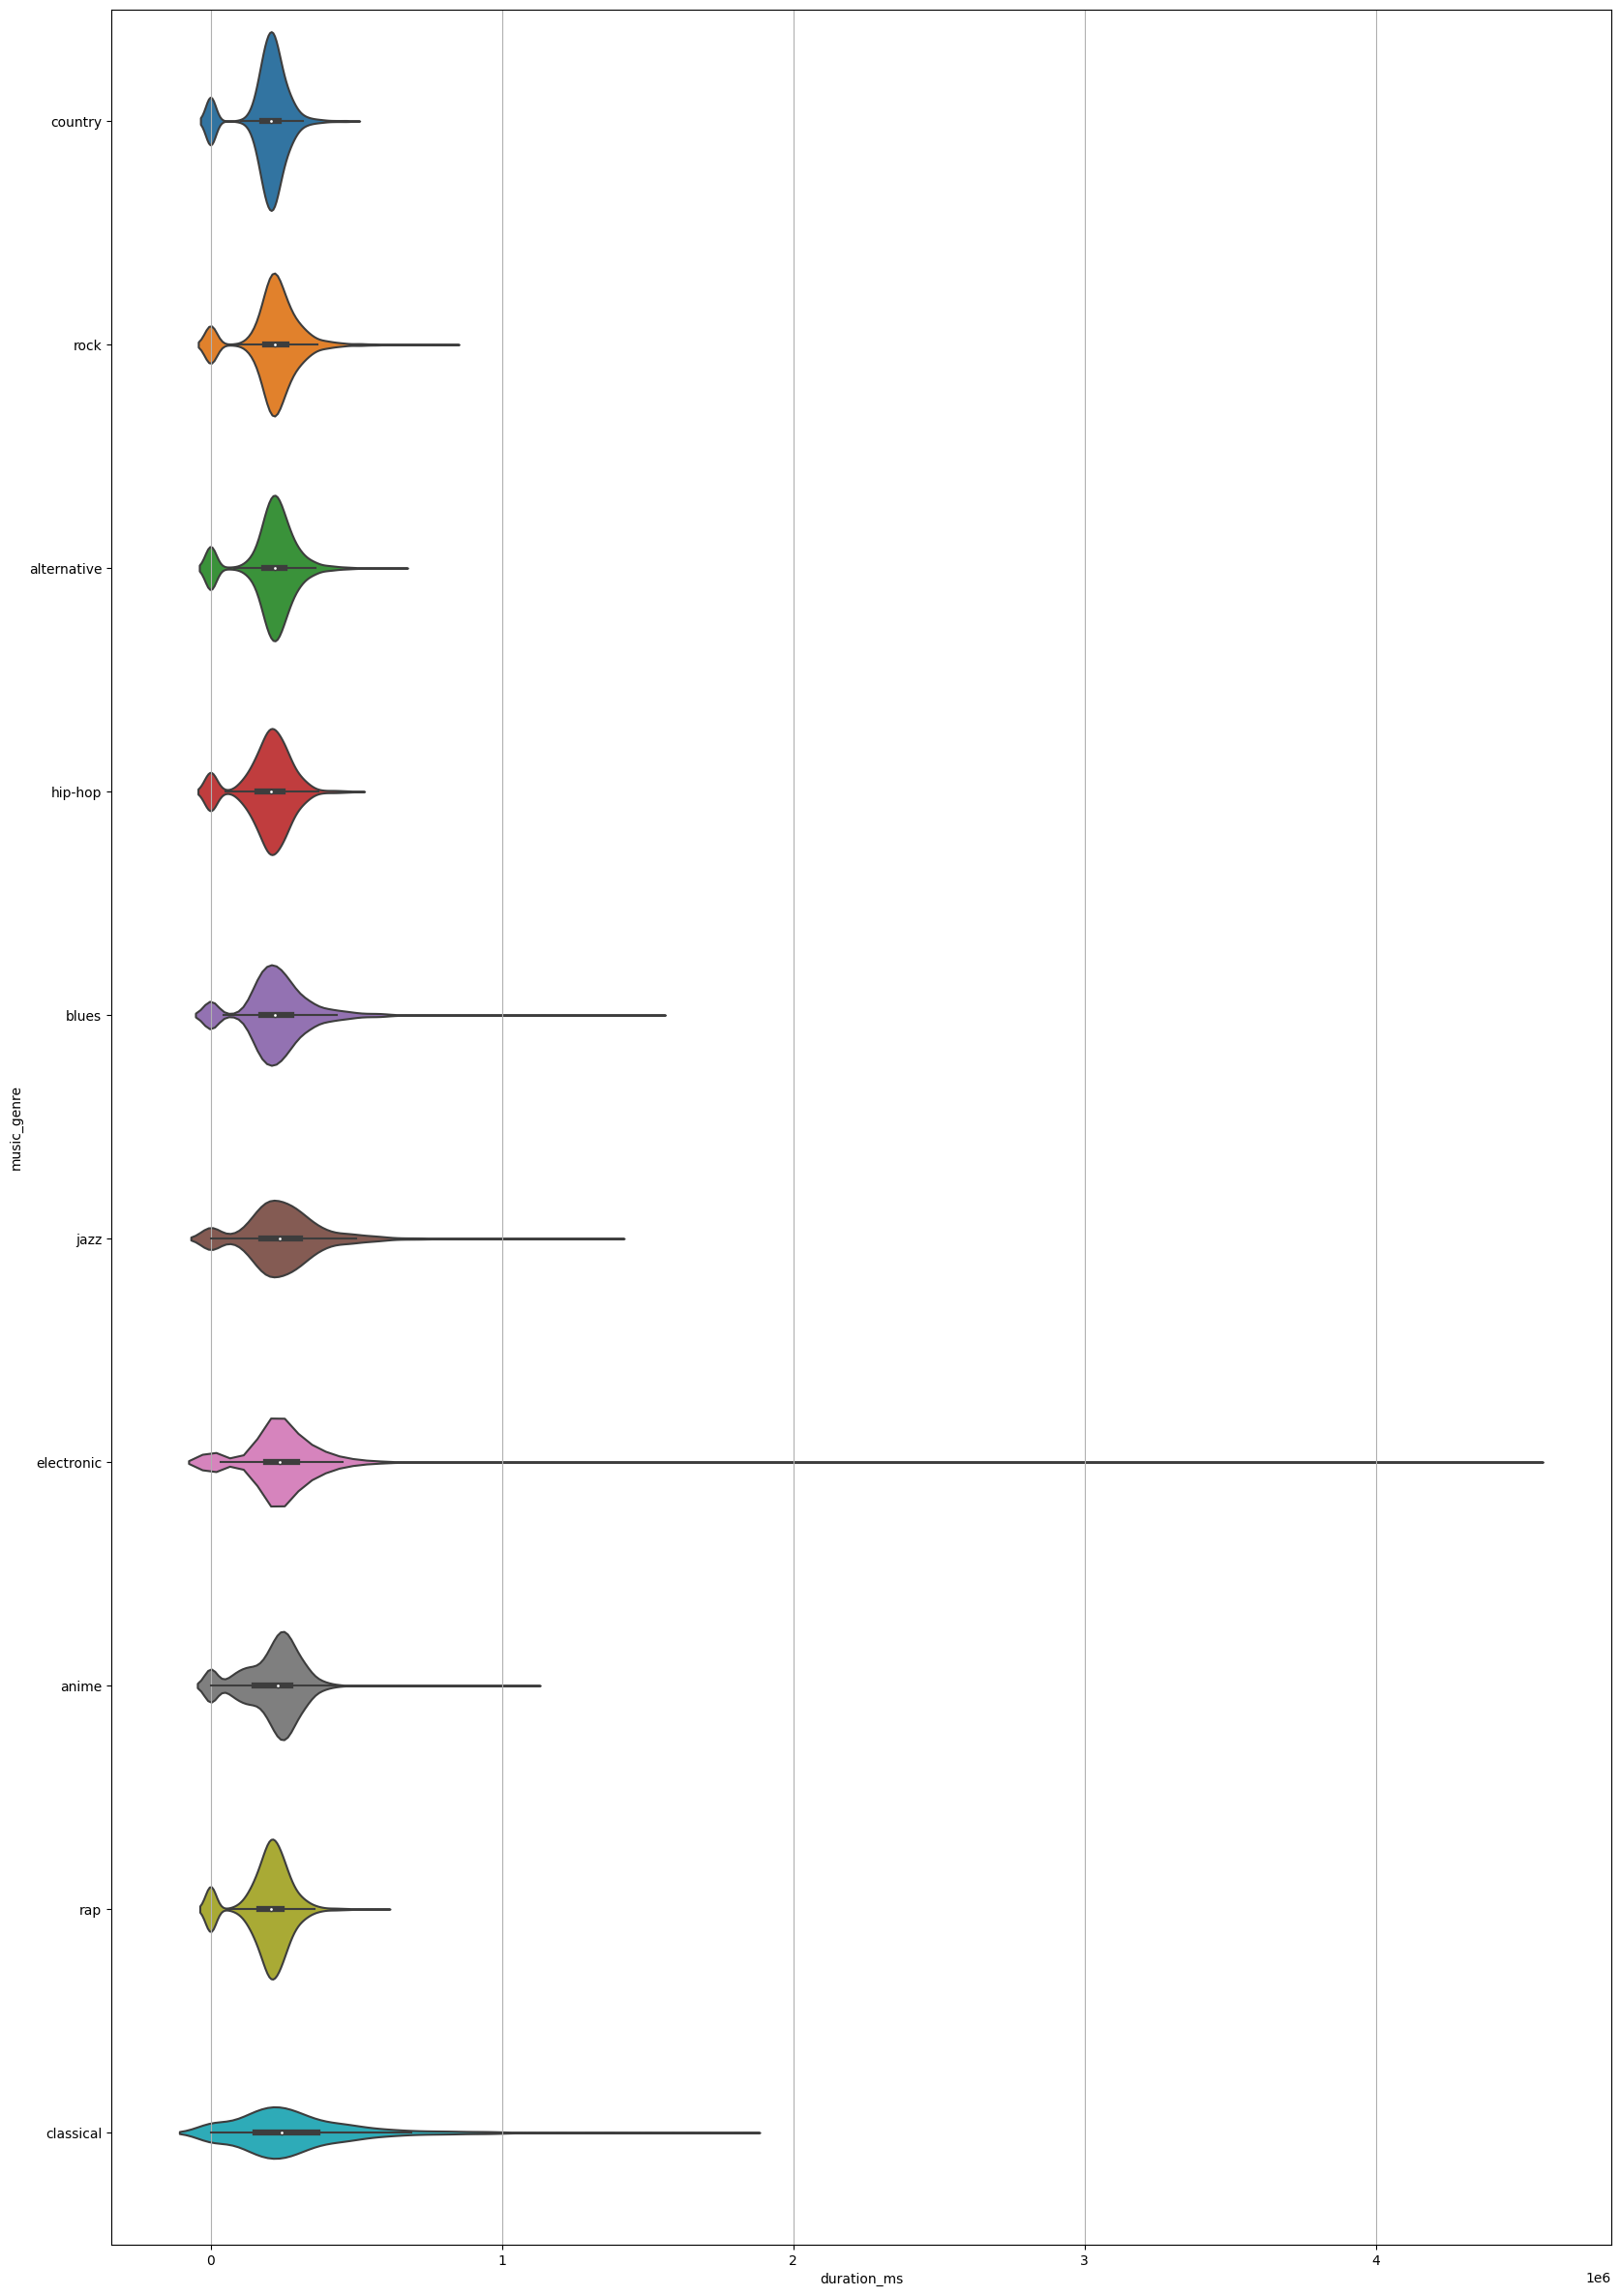

In [27]:
eda.create_category_violinplot(data, 'music_genre', 'duration_ms', True)

Из графиков видно, что распределения для каждой категории очень похожи. Основное отличие заключется в правом хвосте распределения. Дополнительно посмотрим на правый хвост распределения признака. Для этого постороим гистограмму для значений более 800.000. Также посомтрим на всплеск около 0. Скорее всего, там находятся семплы со значением -1. Построим гистограмму для значений менее 100.000

array([[<Axes: title={'center': 'duration_ms'}>]], dtype=object)

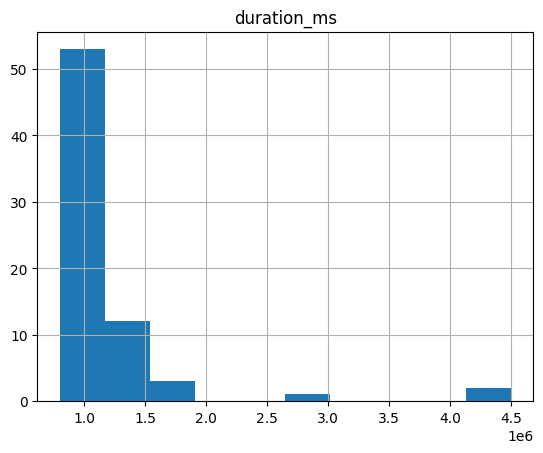

In [28]:
data.query('duration_ms > 800000').hist('duration_ms')

array([[<Axes: title={'center': 'duration_ms'}>]], dtype=object)

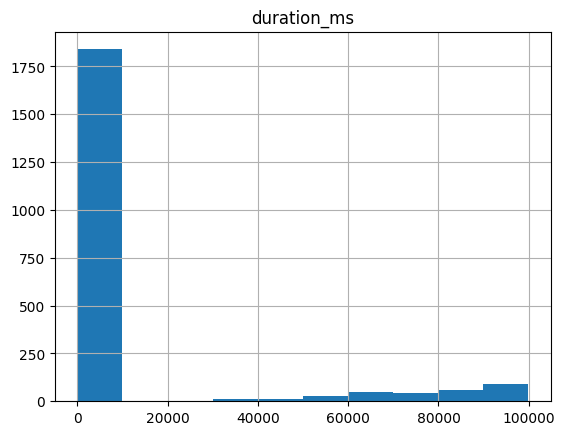

In [29]:
data.query('duration_ms < 100000').hist('duration_ms')

Из первого графика видно, что в правом хвосте есть небольшое количество семплов.  
Из второго графика видно, что действительно всплеск около 0 обусловлен семплами со значением -1.

## 3.6. <a id='toc3_6_'></a>[energy - энергичность](#toc0_)

In [30]:
data['energy'].describe()

count    18754.000000
mean         0.625431
std          0.251477
min          0.001010
25%          0.470000
50%          0.666000
75%          0.831000
max          0.999000
Name: energy, dtype: float64

mean  median      min    max
music_genre                                  
alternative  0.711080  0.7505  0.05560  0.997
anime        0.673693  0.7970  0.00243  0.999
blues        0.616768  0.6380  0.00957  0.998
classical    0.173382  0.1000  0.00101  0.990
country      0.636066  0.6670  0.04270  0.981
electronic   0.738202  0.7710  0.02110  0.999
hip-hop      0.645995  0.6535  0.19900  0.995
jazz         0.471676  0.4710  0.01410  0.990
rap          0.651763  0.6500  0.07930  0.995
rock         0.684443  0.7220  0.02310  0.997

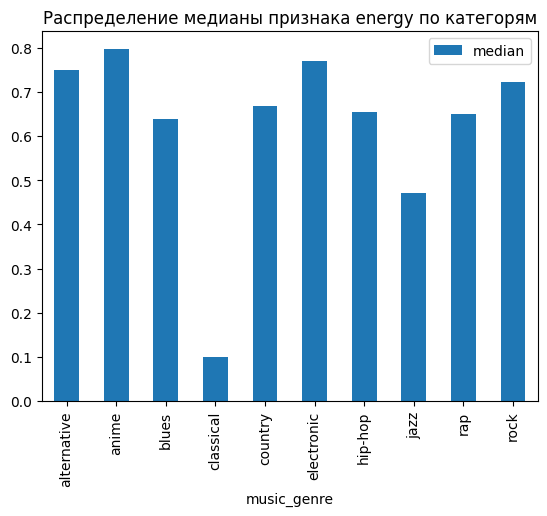

In [31]:
eda.create_pivot_table(data, 'music_genre', 'energy')

Из сводно таблицы и гистограммы видно, что выделяются следующие классы:
1. `classical` - данная категория имеет самое маленькое значение данного параметра. Причем оно значительно меньше остальных
2. Категории `alternative`, `anime`, `electronic`, `rock` имеют значение медианы данного параметра больше 0.7 (0.7505, 0.7970, 0.738202, 0.7220 соответственно)

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


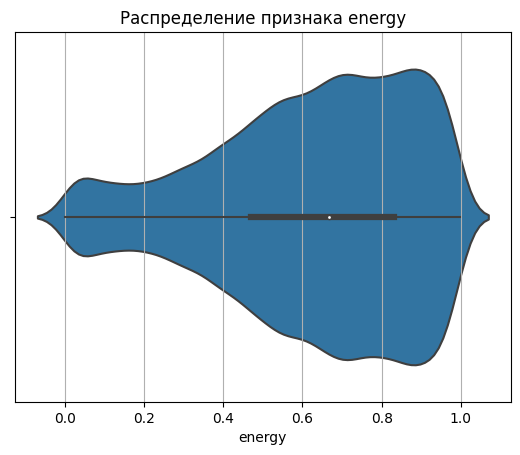

In [32]:
eda.create_violinplot(data, 'energy')

Из графика видно, что распределение скошено влево. Для более подробного изучения данного параметра построим его распределение по категориям

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

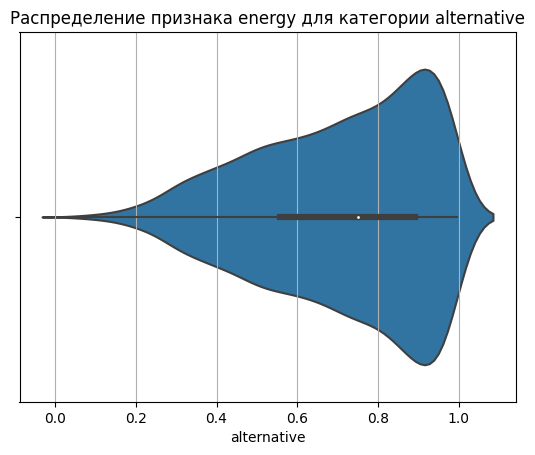

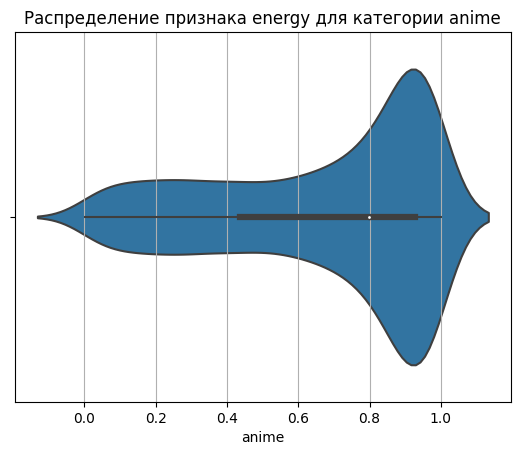

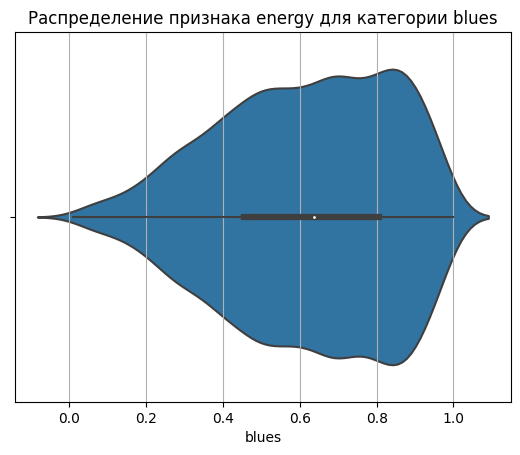

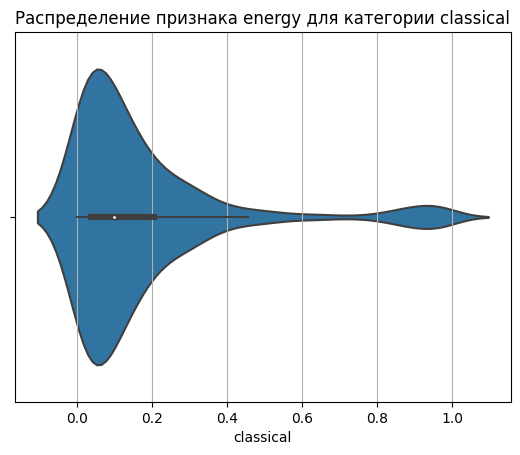

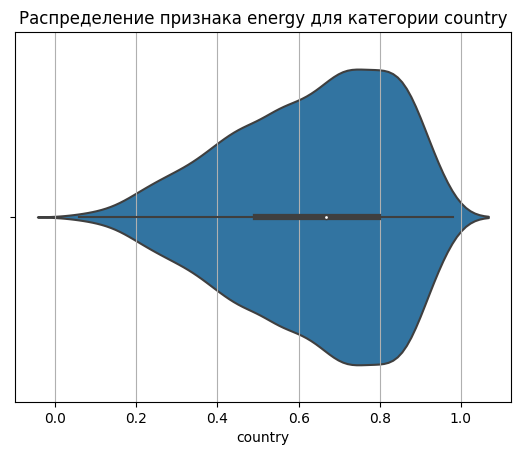

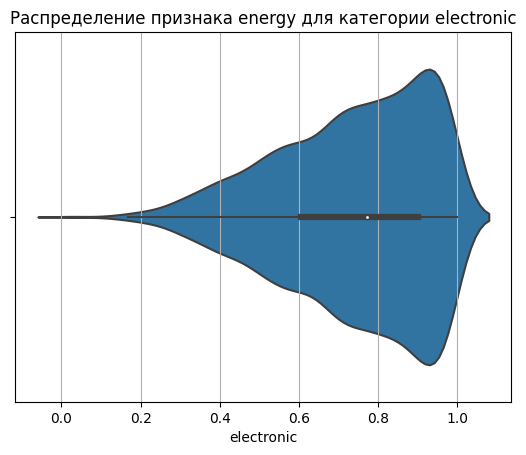

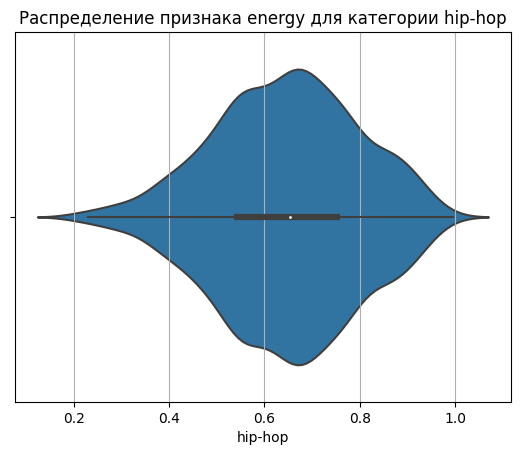

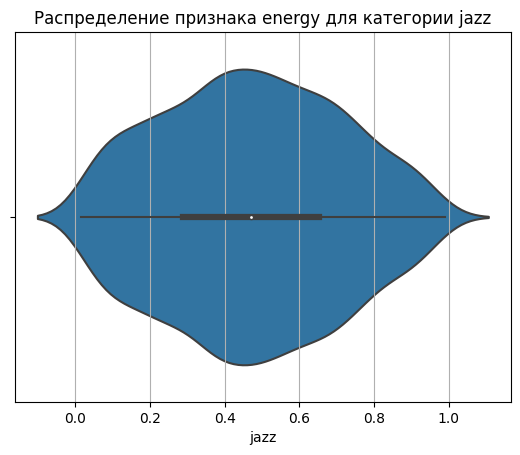

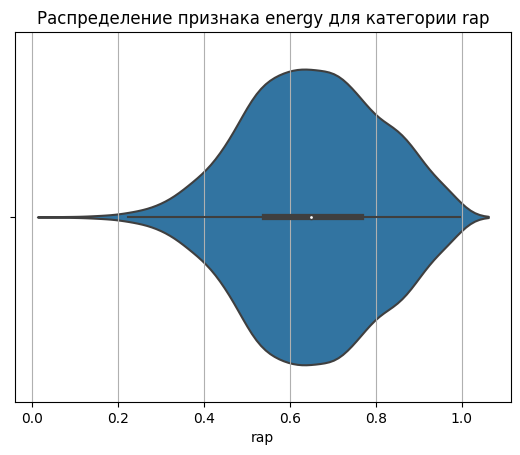

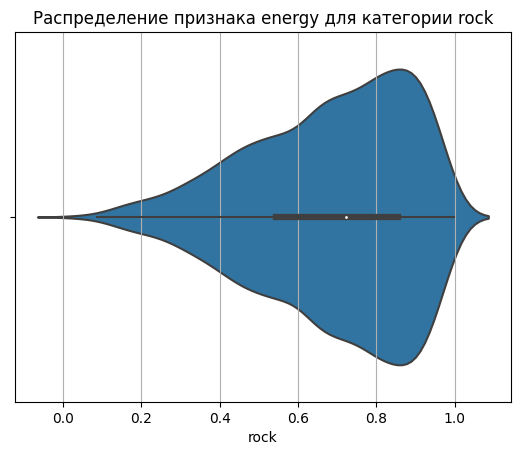

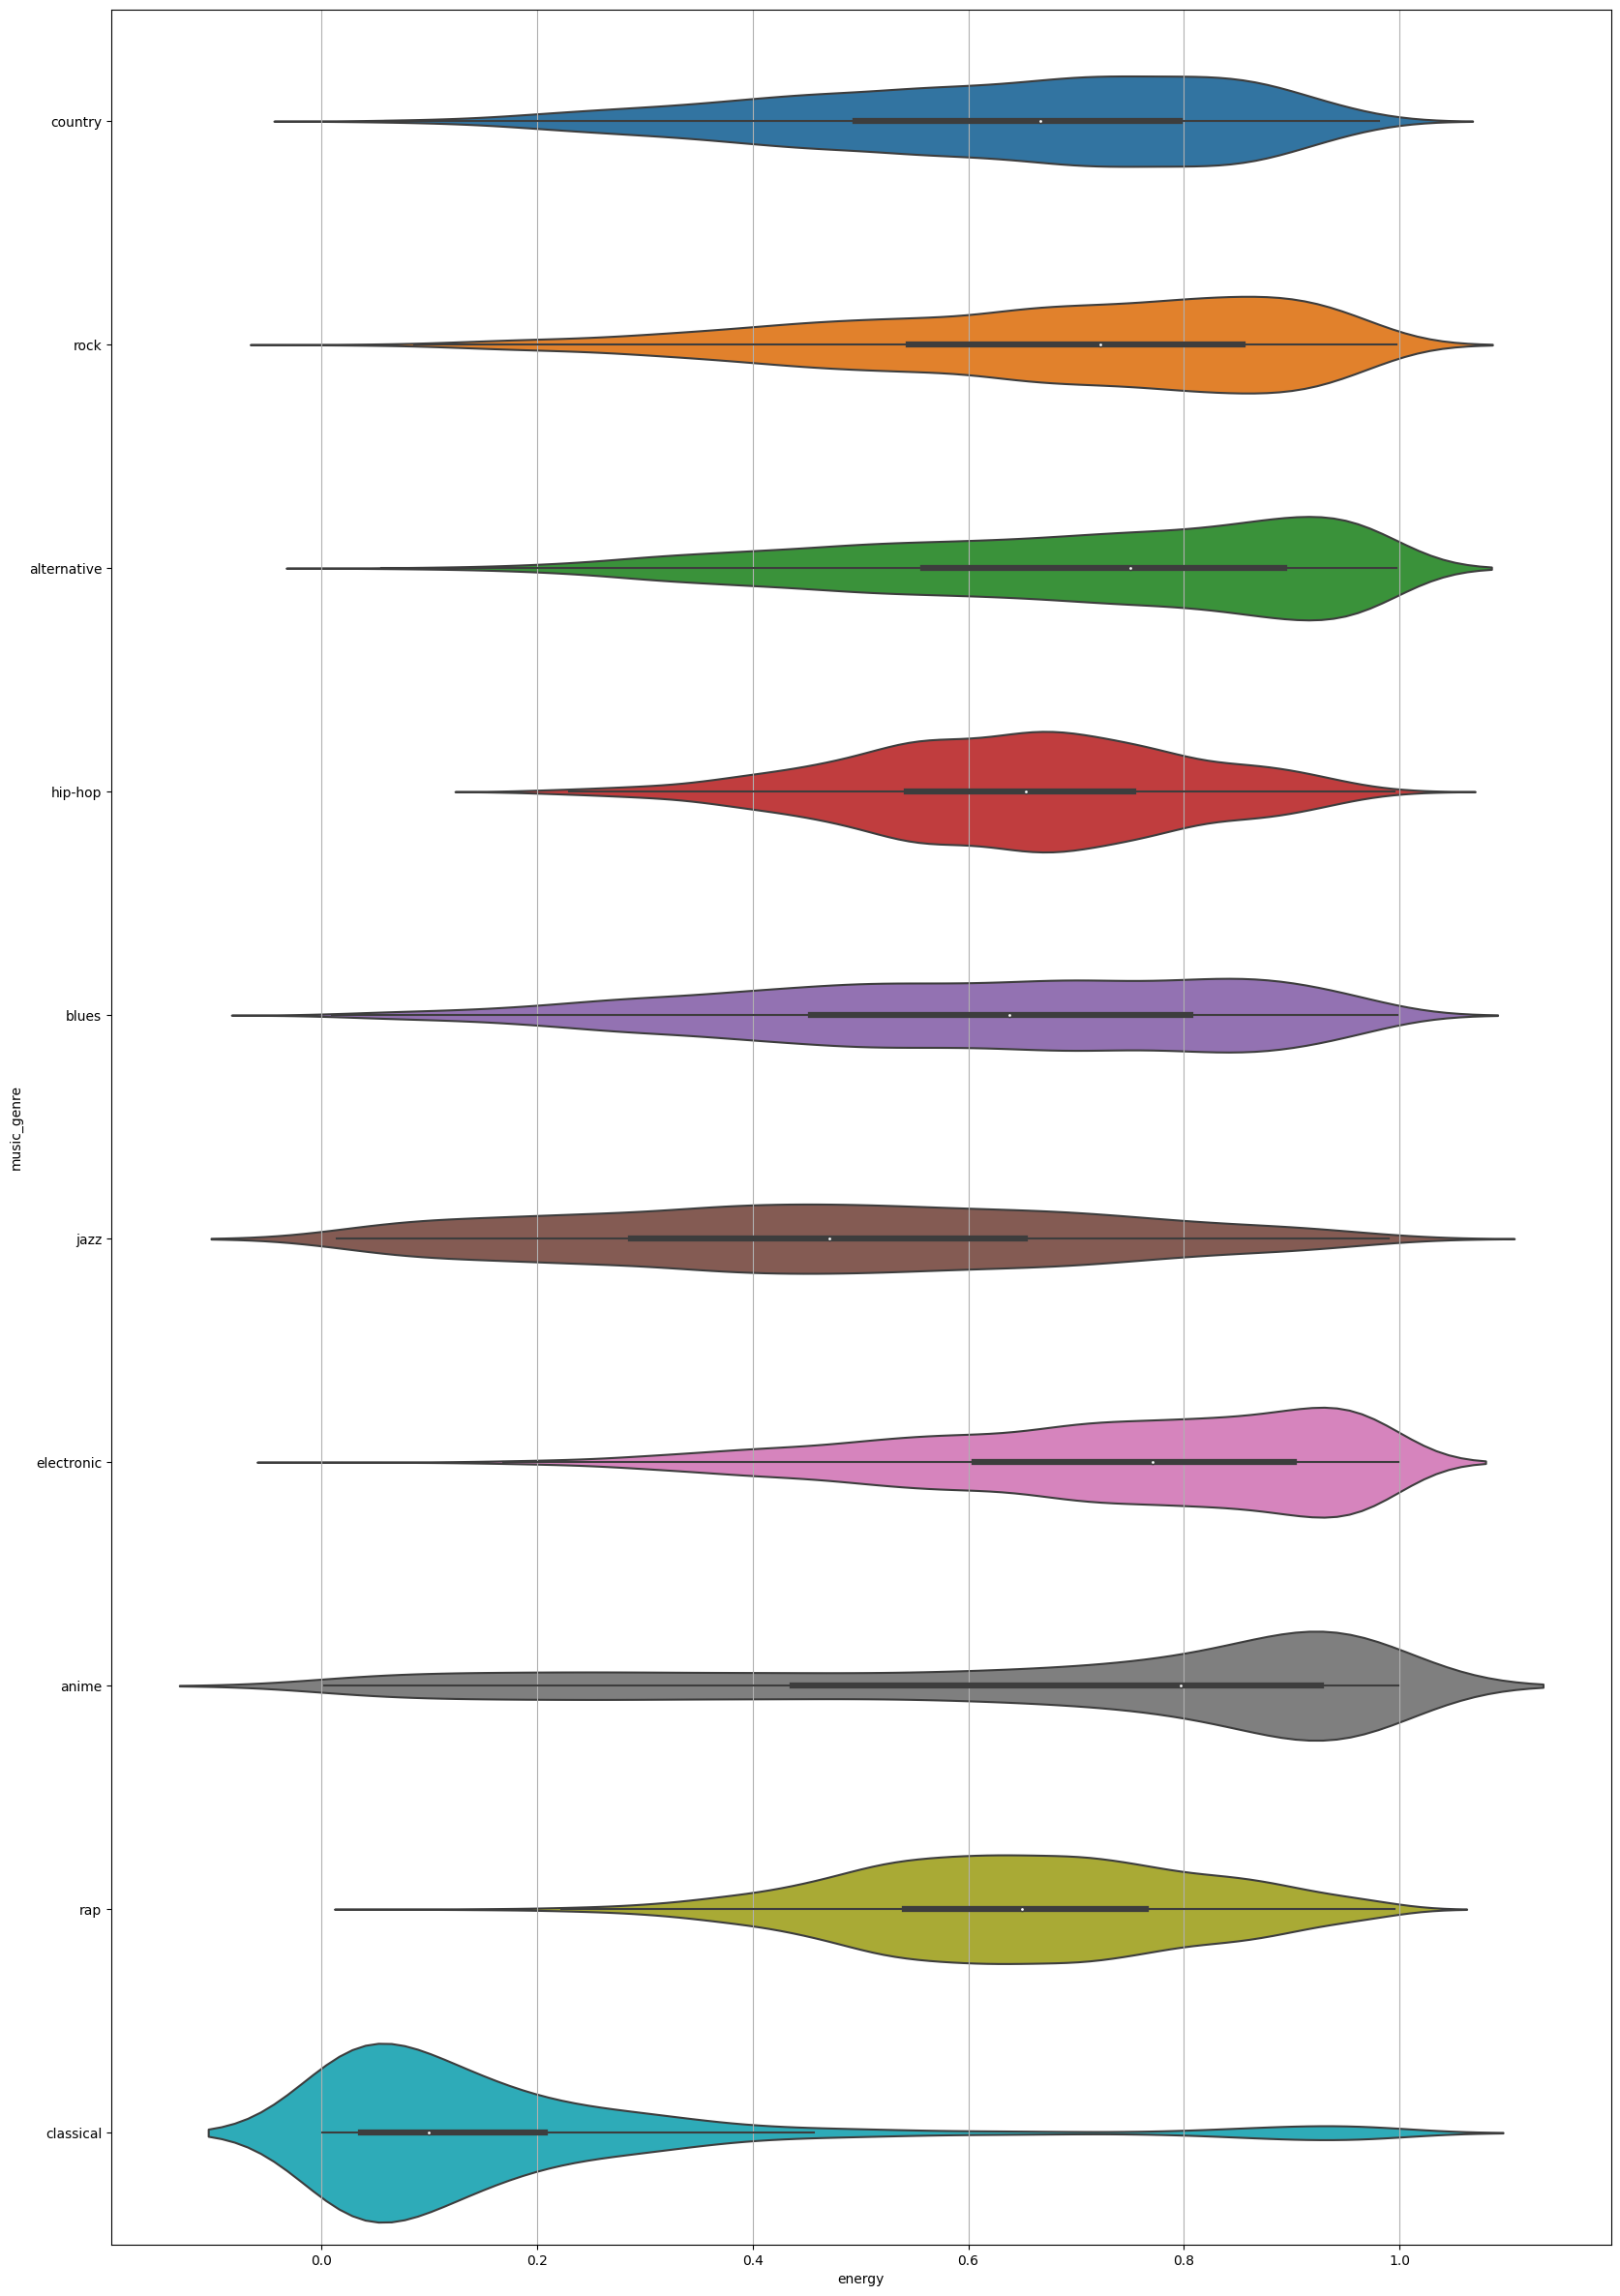

In [33]:
eda.create_category_violinplot(data, 'music_genre', 'energy', True)

На данных графиках можно заметить следующие особенности:
1. Распределение `classical` очень сильно отличается от остальных.
2. Распределения `anime`, `electronic`, `blues`, `alternative`, `rock`, `country` имеют скошенное влево распределение. Причем у категории `anime` самый сильный скос
3. Остальные категории имеют распределение похожее на нормальное и скоса не имеют

## 3.7. <a id='toc3_7_'></a>[instrumentalness - инструментальность](#toc0_)

In [34]:
data['instrumentalness'].describe()

count    18754.000000
mean         0.160718
std          0.307244
min          0.000000
25%          0.000000
50%          0.000146
75%          0.085700
max          0.996000
Name: instrumentalness, dtype: float64

mean    median  min    max
music_genre                                
alternative  0.062033  0.000064  0.0  0.931
anime        0.271038  0.000261  0.0  0.996
blues        0.092925  0.001010  0.0  0.961
classical    0.598319  0.837000  0.0  0.987
country      0.004863  0.000001  0.0  0.778
electronic   0.349890  0.178000  0.0  0.986
hip-hop      0.010386  0.000000  0.0  0.923
jazz         0.362112  0.131000  0.0  0.975
rap          0.008388  0.000000  0.0  0.922
rock         0.052342  0.000048  0.0  0.972

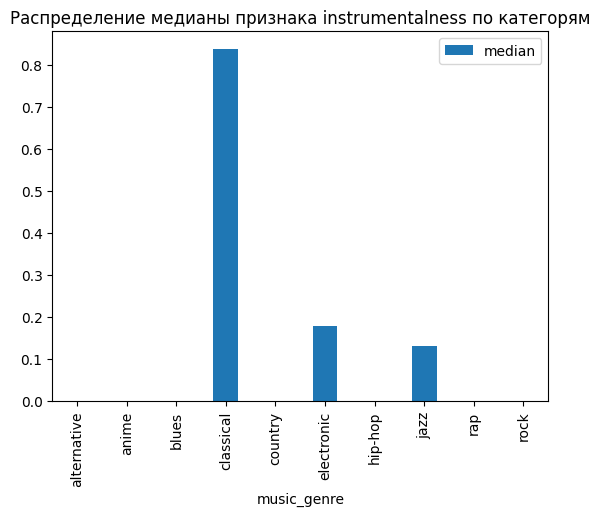

In [35]:
eda.create_pivot_table(data, 'music_genre', 'instrumentalness')

Из сводной таблицы и гистограммы видно, что категория `classical` больше всего выделяется в данном признаке. Медианное значение в данной категории равно 0.837. Категории `electronic` и `jazz` имеют значения медианы 0.178 и 0.131 соответственно. У остальных категорий медиана данного признакак практически равна 0

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


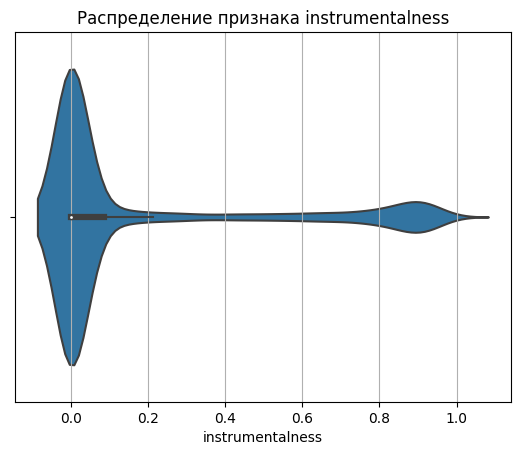

In [36]:
eda.create_violinplot(data, 'instrumentalness')

Данный график подтверждает выводы, сделанные из гистограммы и сводной таблицы - практически все семплы сконцентрированы около 0. Всплеск около 1, скорее всего, представлен категорией `classical`. Чтобы узнать более подробную информацию построим распределение данного признака по категориям

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

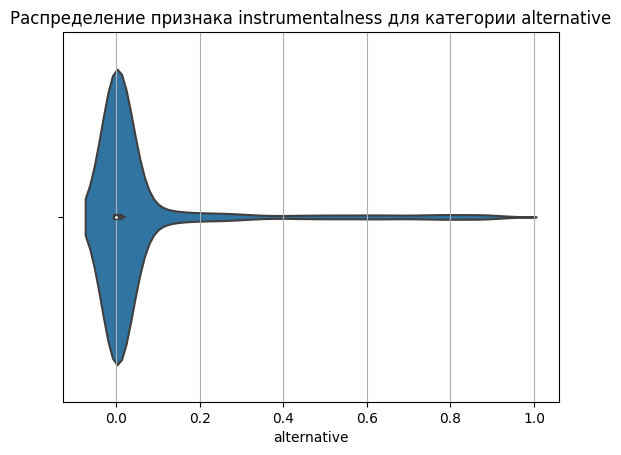

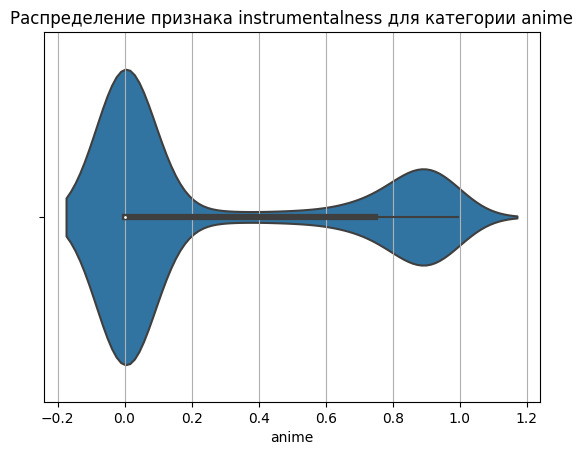

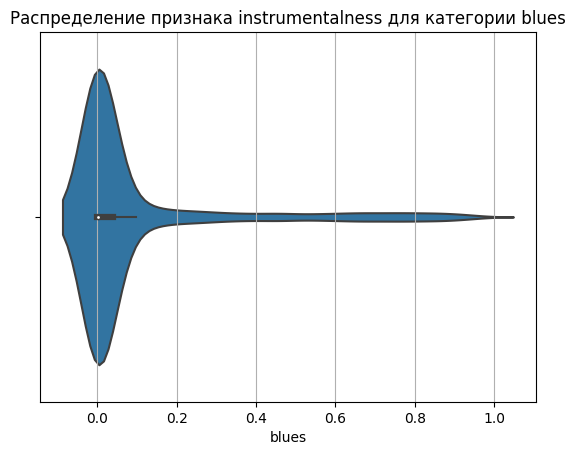

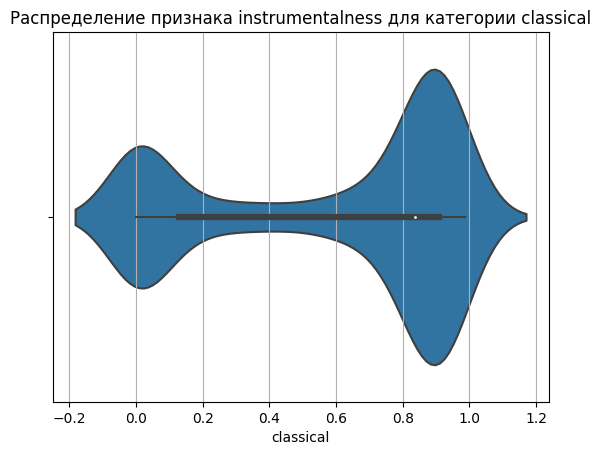

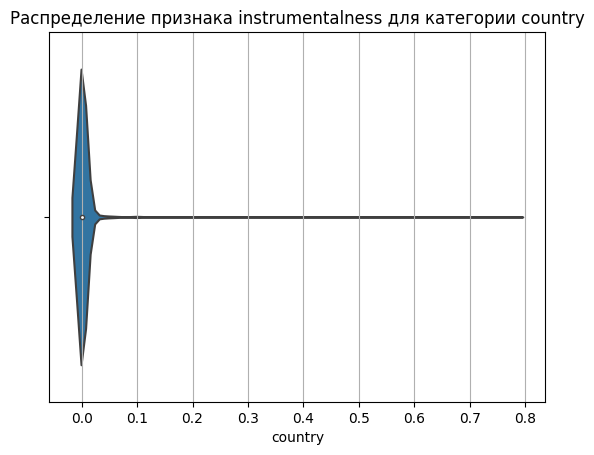

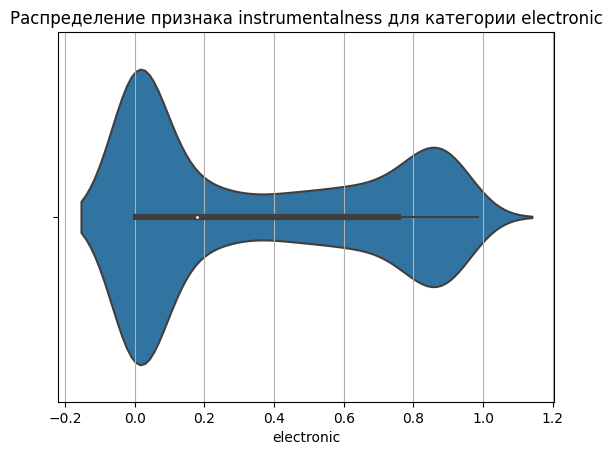

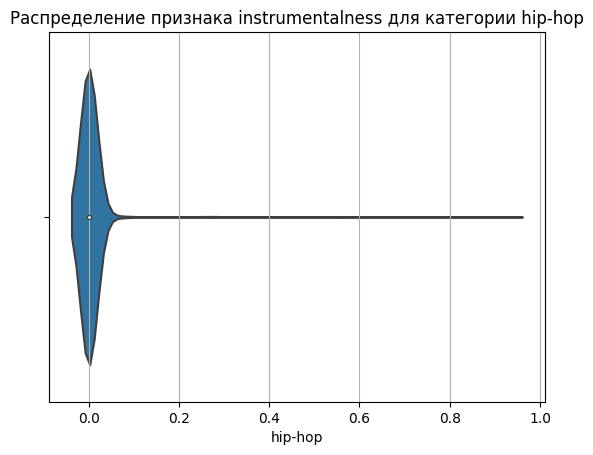

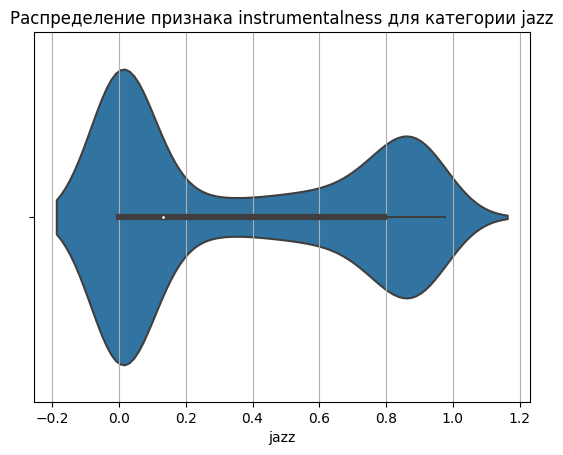

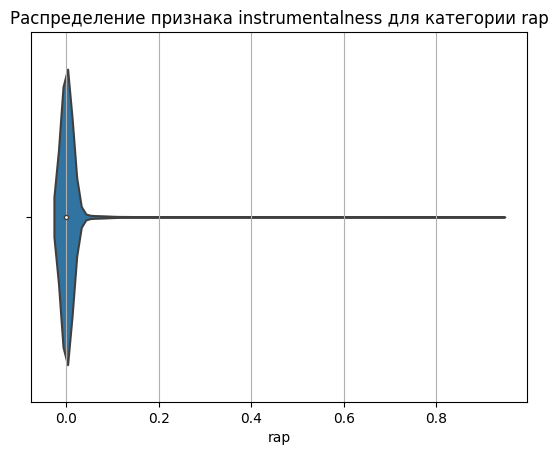

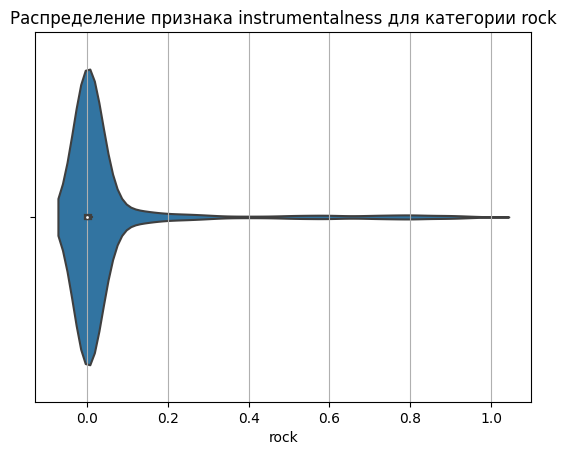

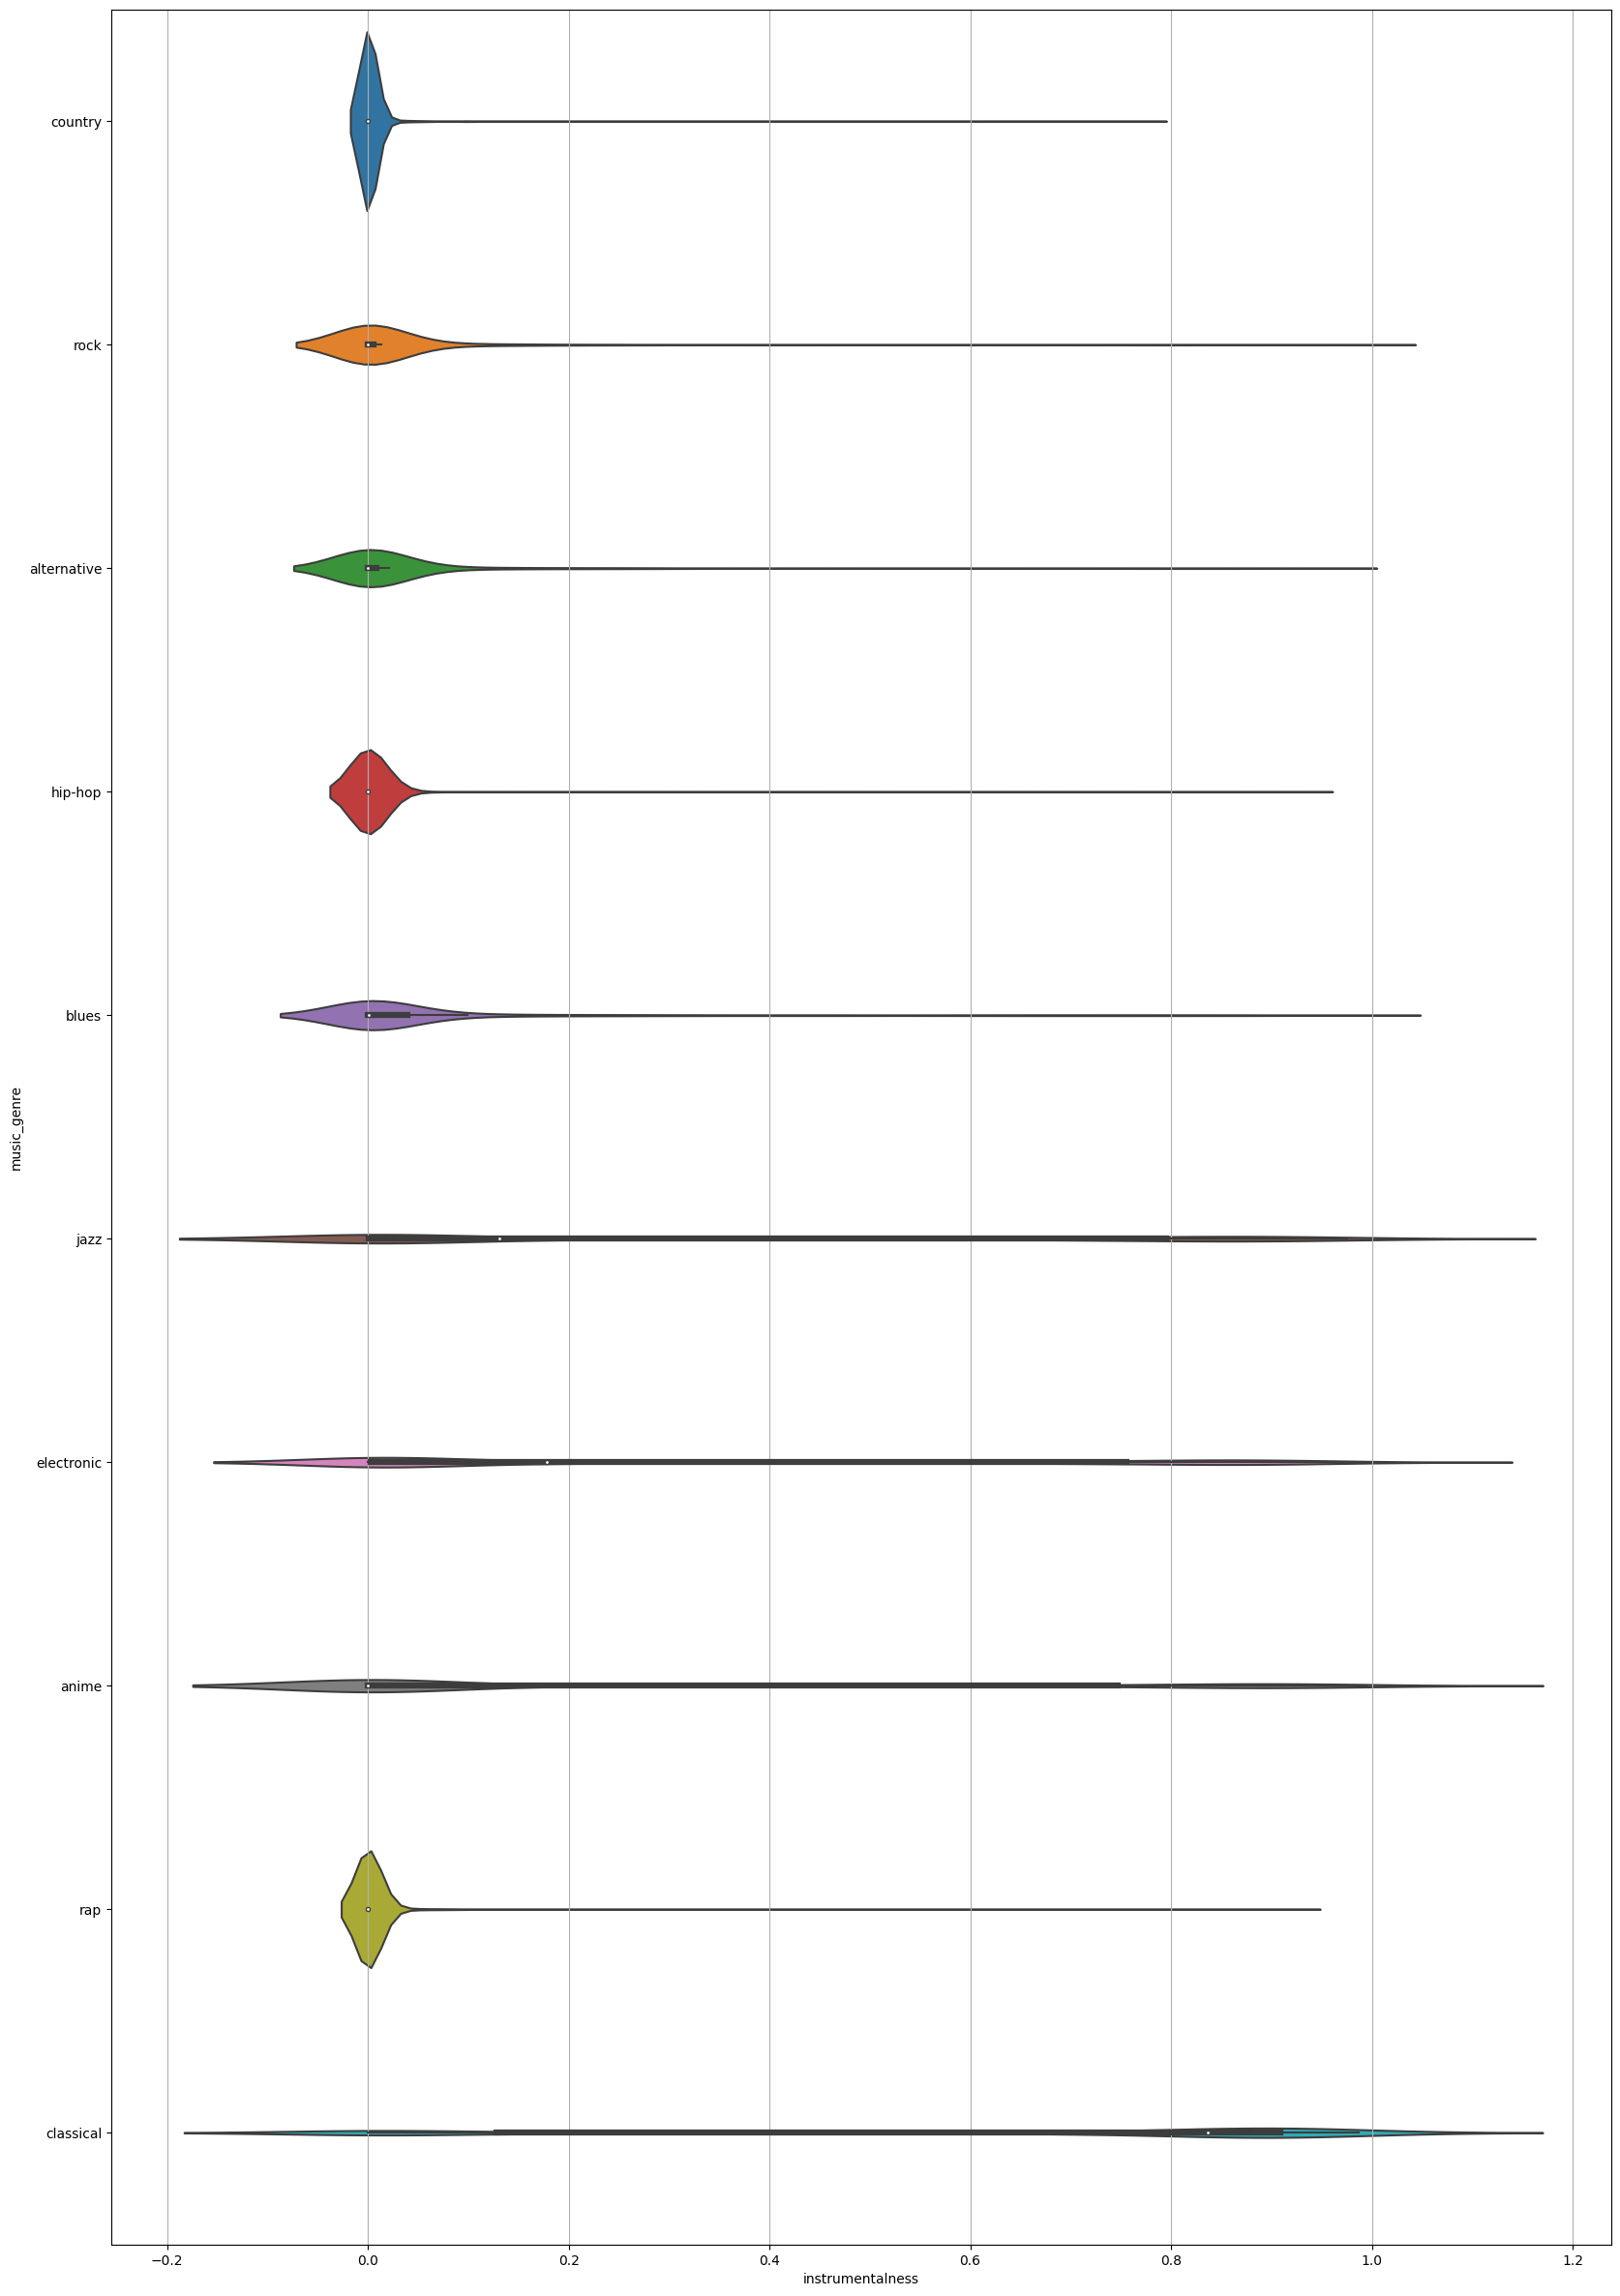

In [37]:
eda.create_category_violinplot(data, 'music_genre', 'instrumentalness', True)

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

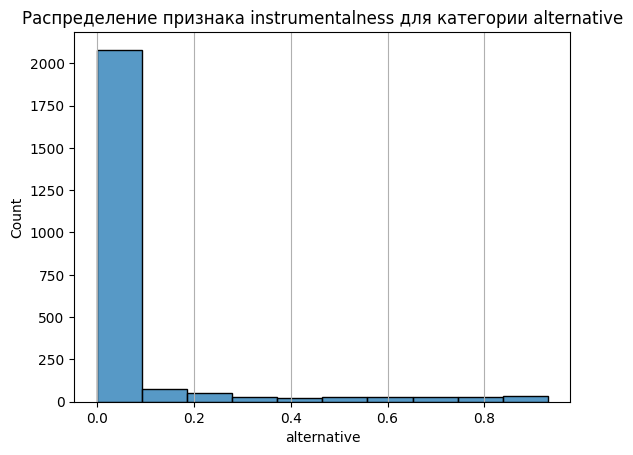

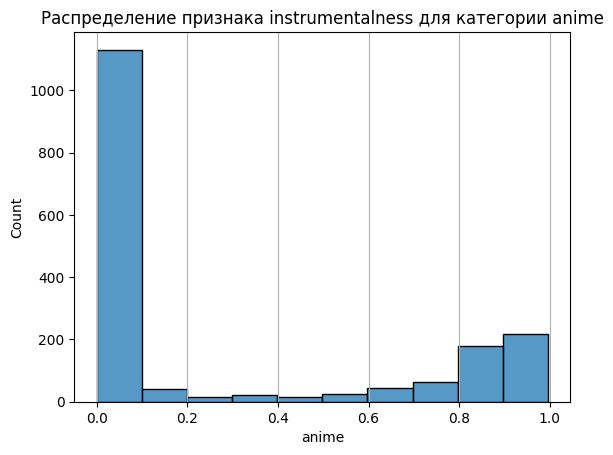

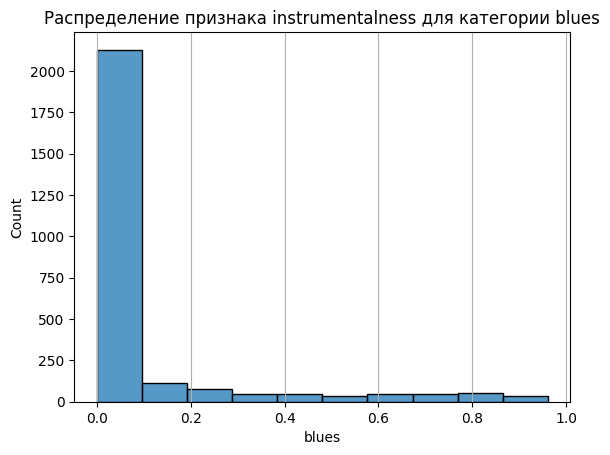

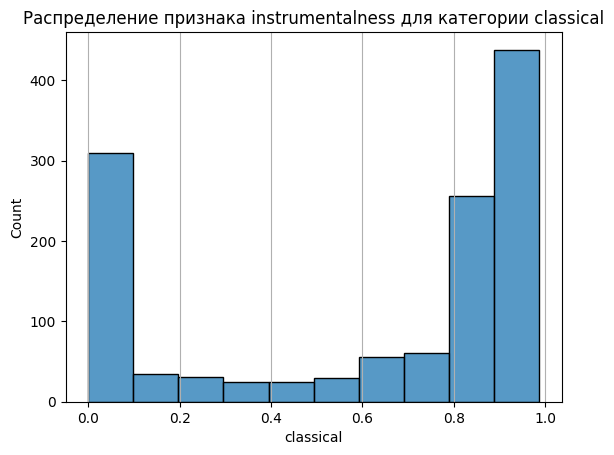

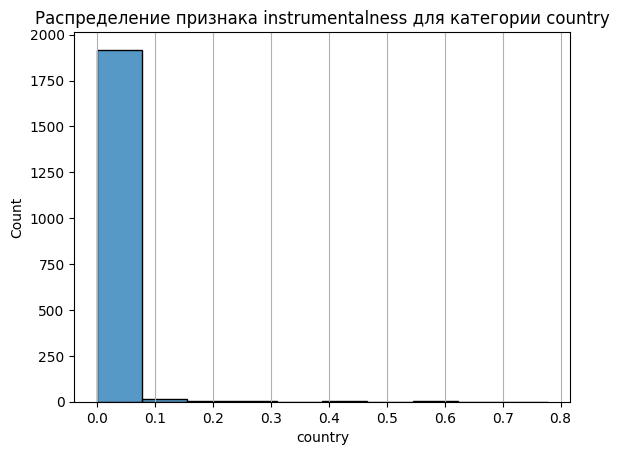

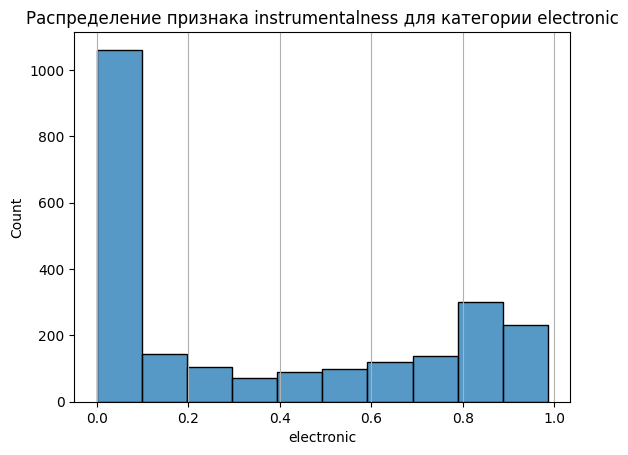

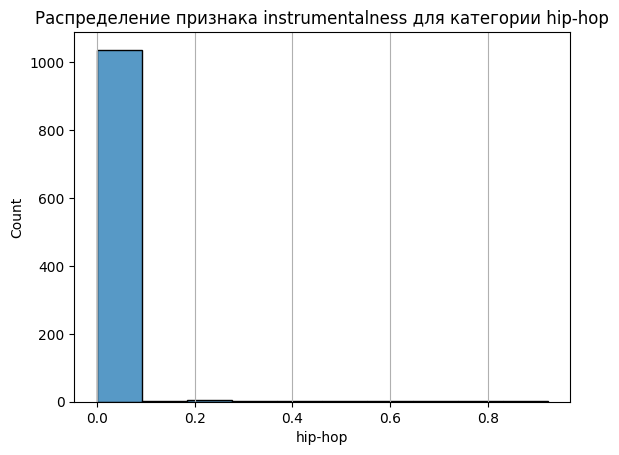

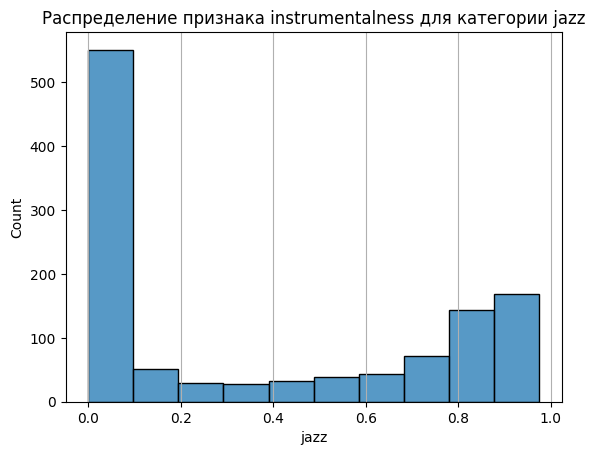

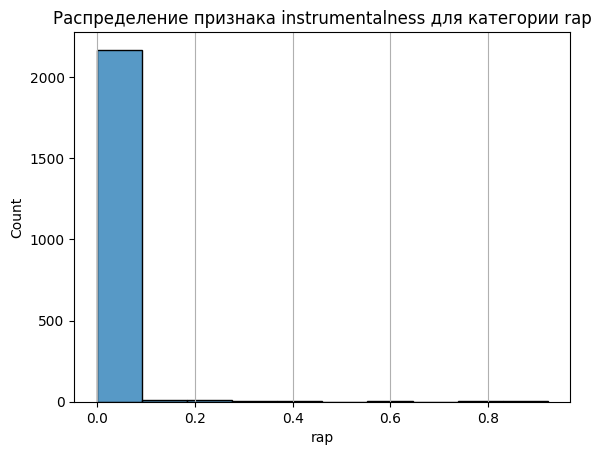

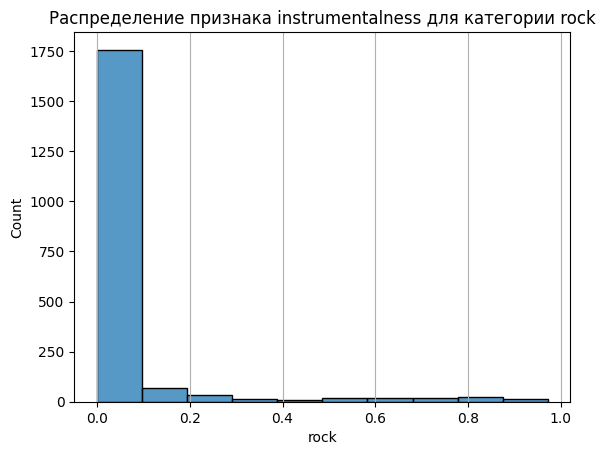

In [38]:
for group_name, group_data in data.groupby('music_genre')['instrumentalness']:
        df = pd.DataFrame(group_data.values, columns=[group_name])
        _, ax = plt.subplots()
        sns.histplot(
            x=df[group_name],
            ax=ax,
            bins=10
        ).set_title(f'Распределение признака instrumentalness '
                    f'для категории {group_name}')
        ax.xaxis.grid(True)

<Axes: >

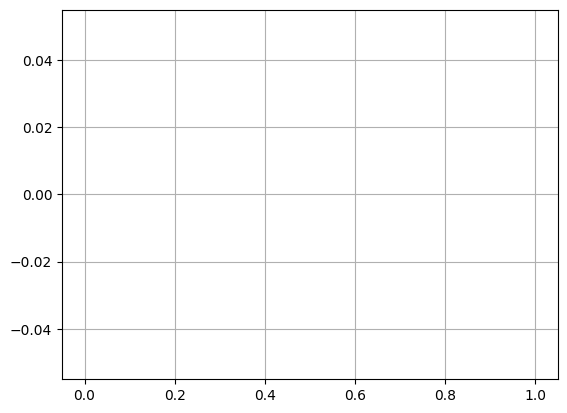

In [39]:
data.loc[data['music_genre'] == 'Rock', 'instrumentalness'].hist()

Полученные графики отражают следующие особенности:
1. Категории `alternative`, `blues`, `country`, `hip-hop`, `jazz`, `rap`, `rock` имеют практическу нулевую инструментальность.
2. Категория `classical` единсвенно имеет основной всплеск около 1. Но также имеет всплеск около 0.
3. Категории `electronic` и `jazz` наоборот имеют основную вершину около 0 и еще одну небольшую вершину около 1.

## 3.8. <a id='toc3_8_'></a>[liveness - привлекательность](#toc0_)

In [40]:
data['liveness'].describe()

count    18754.000000
mean         0.198873
std          0.166665
min          0.013600
25%          0.097400
50%          0.130000
75%          0.254000
max          1.000000
Name: liveness, dtype: float64

mean  median     min    max
music_genre                                 
alternative  0.199319   0.136  0.0212  0.996
anime        0.196737   0.140  0.0169  0.943
blues        0.236436   0.142  0.0136  1.000
classical    0.167823   0.111  0.0365  0.979
country      0.183775   0.129  0.0212  0.982
electronic   0.208284   0.128  0.0194  0.952
hip-hop      0.200065   0.137  0.0278  0.950
jazz         0.172923   0.116  0.0291  0.979
rap          0.197061   0.134  0.0241  0.962
rock         0.190380   0.127  0.0247  0.991

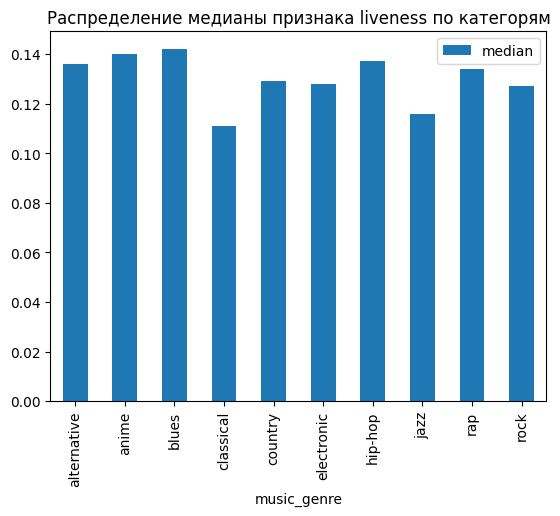

In [41]:
eda.create_pivot_table(data, 'music_genre', 'liveness')

Из сводной таблицы и гистограммы видно, что категории `classical` и `jazz` имеют наименьшее значение медианы данного признака. Остальные категории имеют примерно одинаковые значения медианы

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


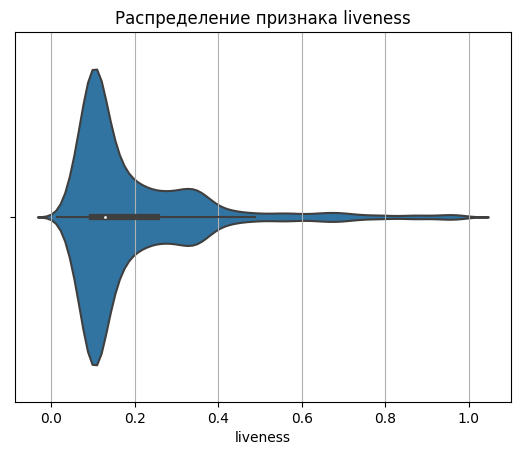

In [42]:
eda.create_violinplot(data, 'liveness')

Из графика видно несколько вершин. Основная около 0.15, поменьше около 0.35 и 2 совсем малеькие. Для получения более подробной информации построим распределение данного признака по категориям

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

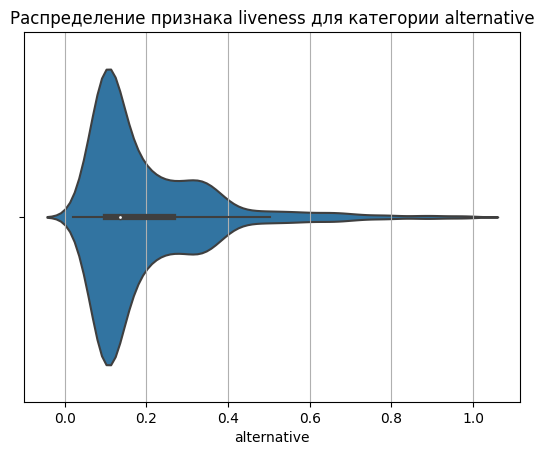

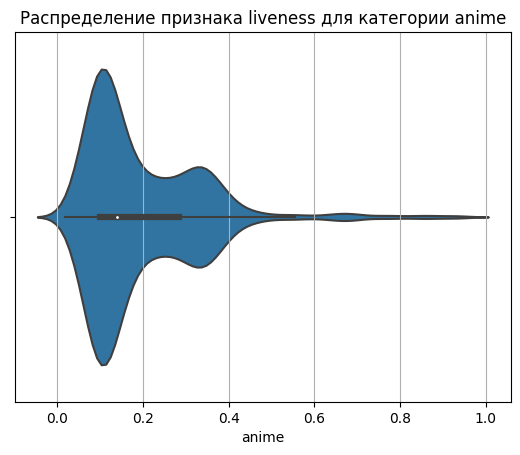

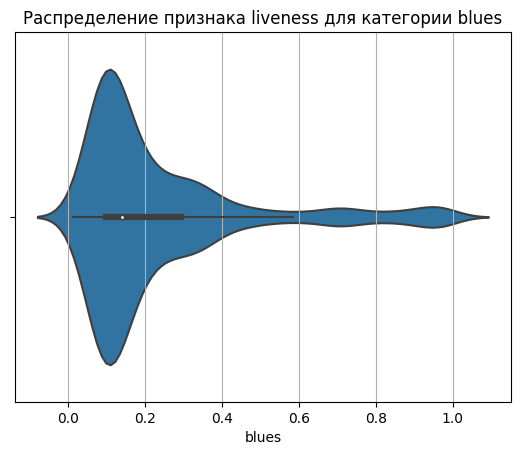

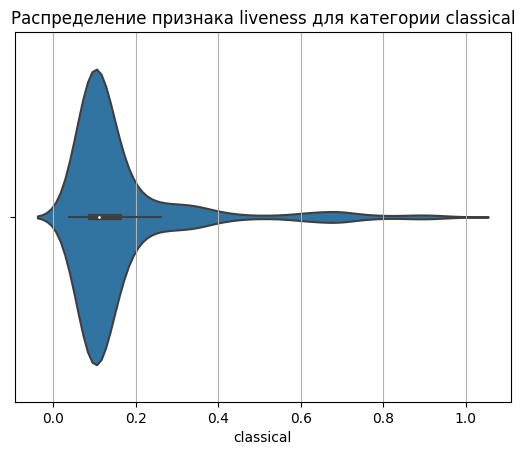

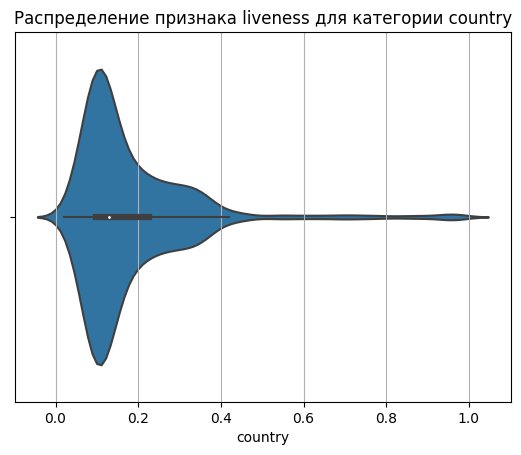

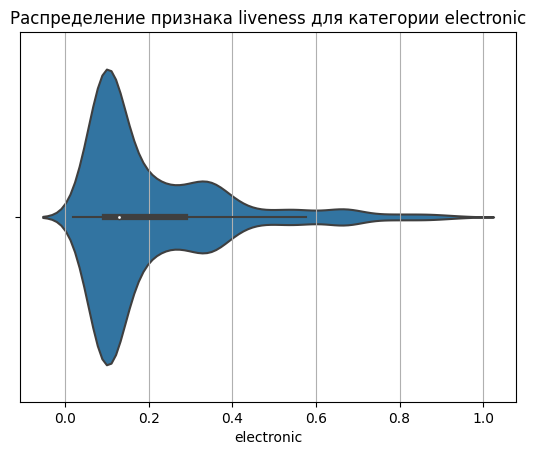

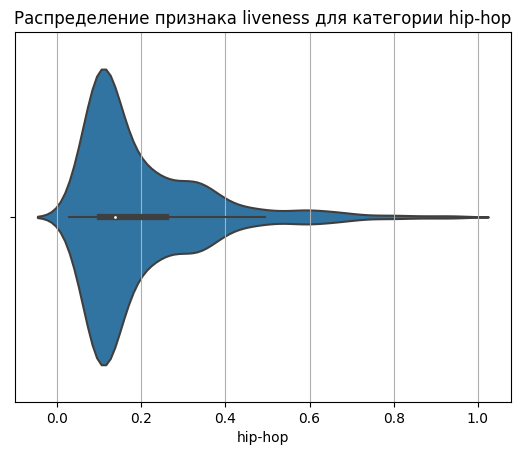

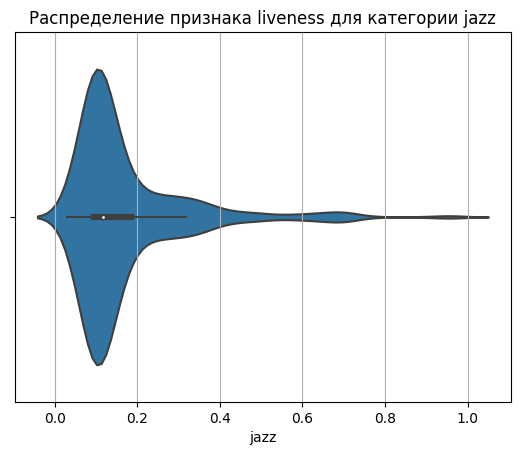

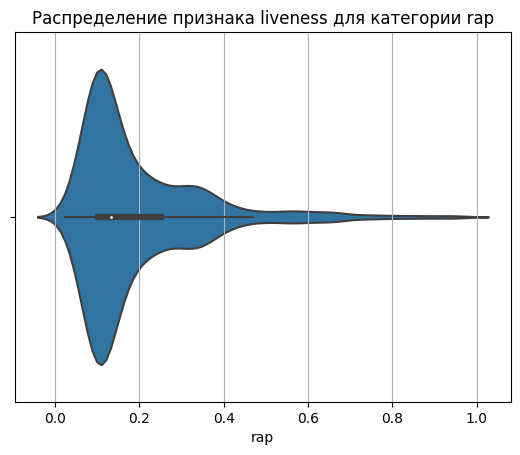

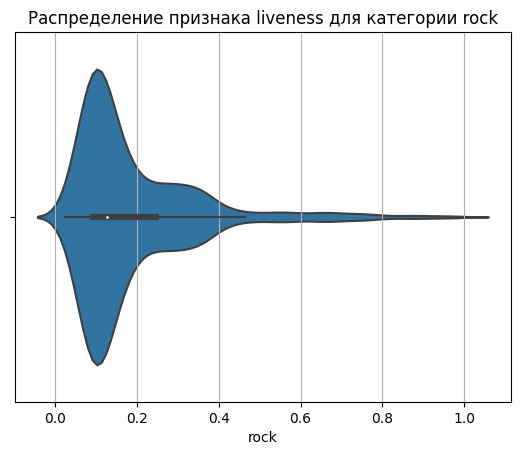

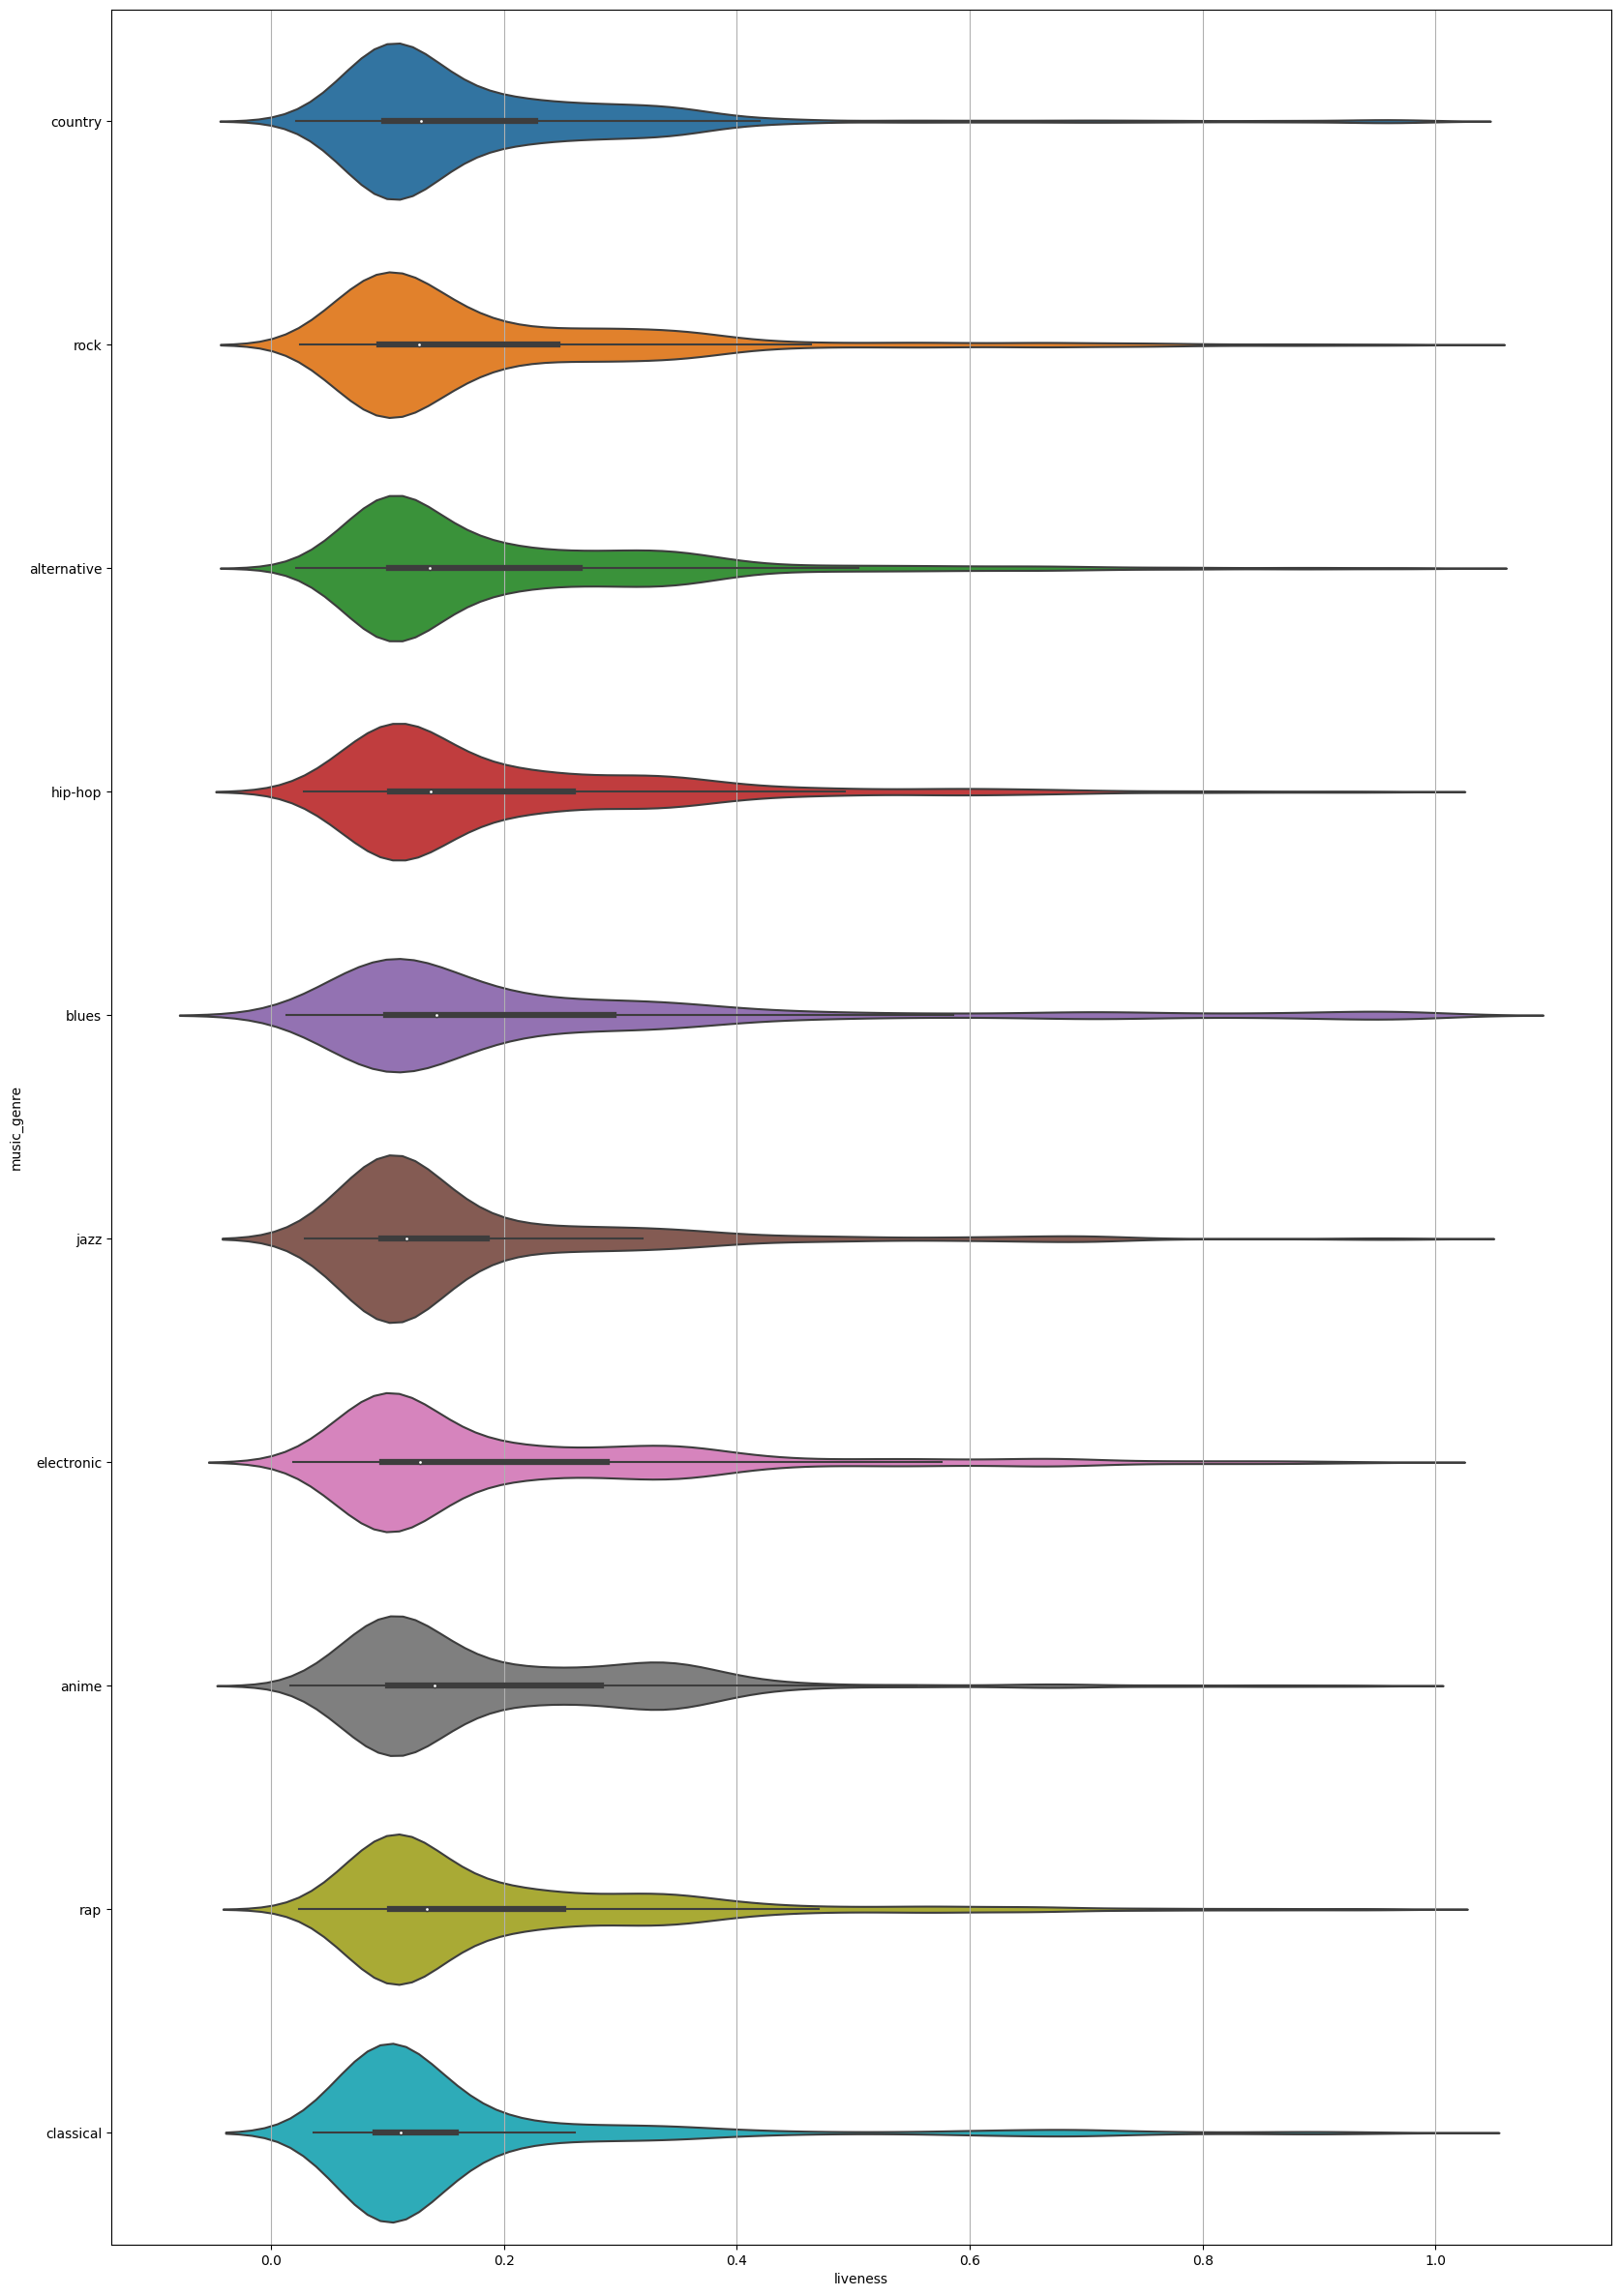

In [43]:
eda.create_category_violinplot(data, 'music_genre', 'liveness', True)

У всех категорий распределение данного признака очень похожи. Из особенностей можно выделить наиболее выраженную вторую вершину и категории `anime`

## 3.9. <a id='toc3_9_'></a>[loudness - громкость](#toc0_)

In [44]:
data['loudness'].describe()

count    18754.000000
mean        -8.553494
std          5.505285
min        -44.406000
25%        -10.254750
50%         -7.044000
75%         -5.052250
max          3.744000
Name: loudness, dtype: float64

mean   median     min    max
music_genre                                   
alternative  -6.555592  -6.0455 -20.741 -0.259
anime        -7.815908  -5.6180 -38.833  0.359
blues        -8.912977  -8.4000 -25.243  3.744
classical   -21.601275 -21.9570 -44.406 -3.358
country      -7.310515  -6.4925 -27.119 -1.723
electronic   -7.008500  -6.4040 -24.798  0.899
hip-hop      -6.838716  -6.5875 -25.602 -0.898
jazz        -11.311024 -10.3895 -29.709 -1.163
rap          -6.657605  -6.3145 -22.589 -1.020
rock         -7.280987  -6.4390 -26.401 -0.759

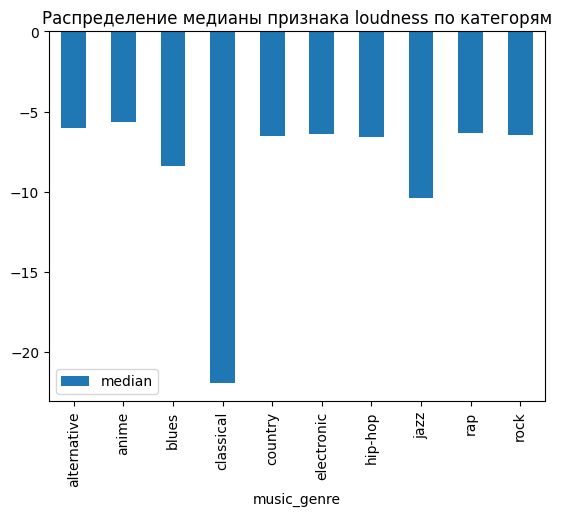

In [45]:
eda.create_pivot_table(data, 'music_genre', 'loudness')

Из сводной таблицы и гистораммы видно, что наиболее выделяются категории `classical`, `jazz`, `blues`. Остальные категории имеют примерно одинаковое значение медианы признака

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


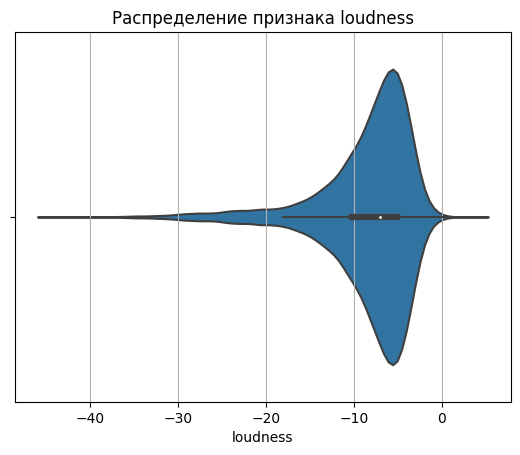

In [46]:
eda.create_violinplot(data, 'loudness')

Из графика видно, что мат ожидание распределение находится около -5 и имеется длинный левый хвост. Построим распределение по категориям

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

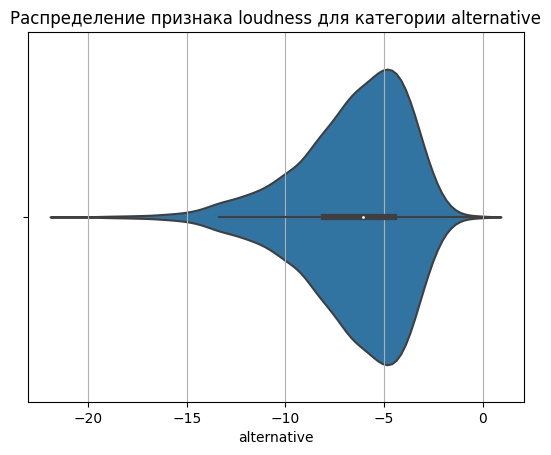

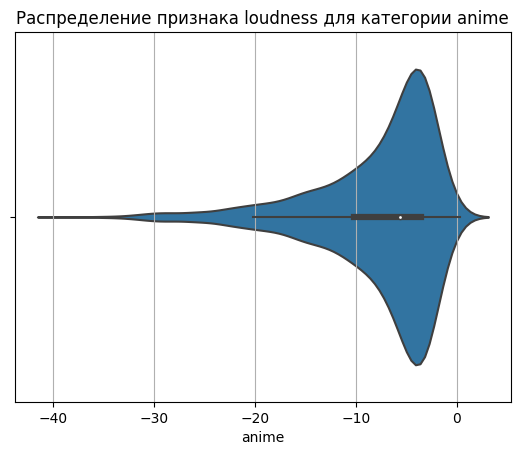

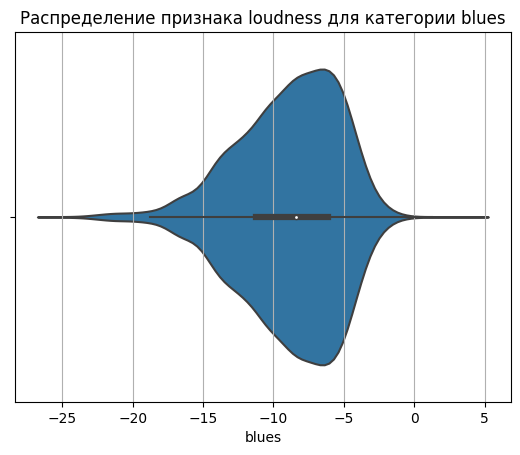

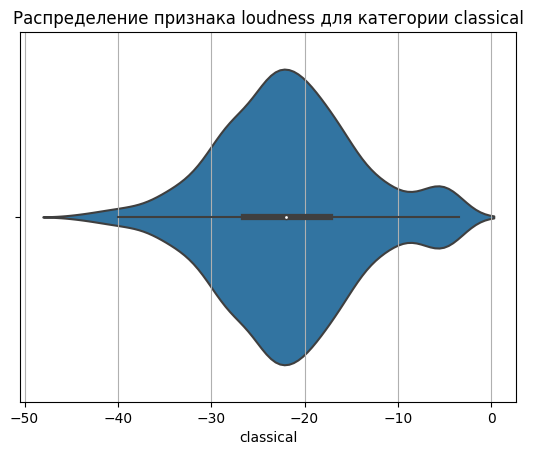

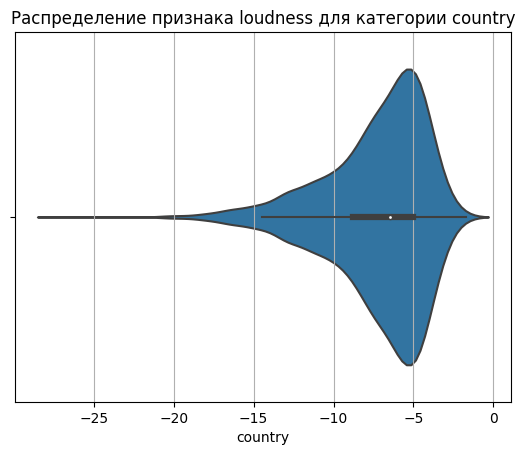

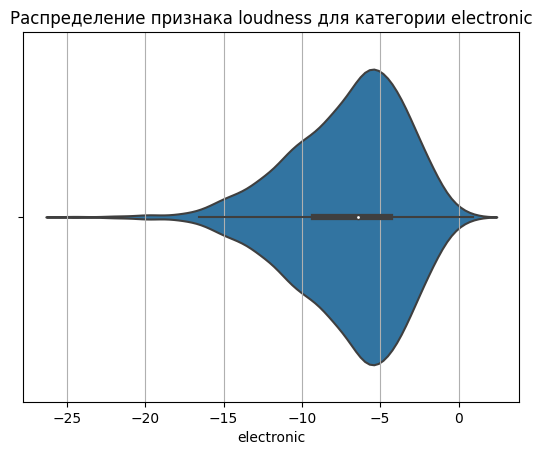

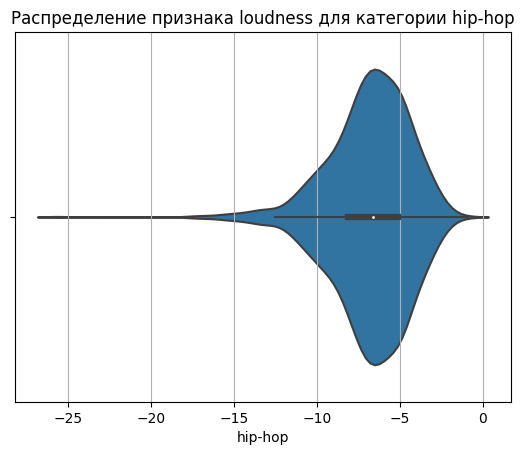

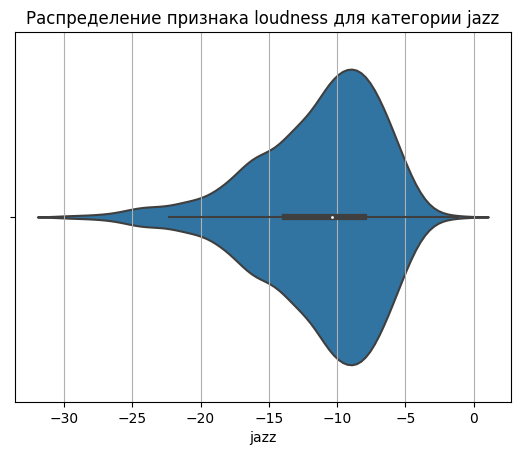

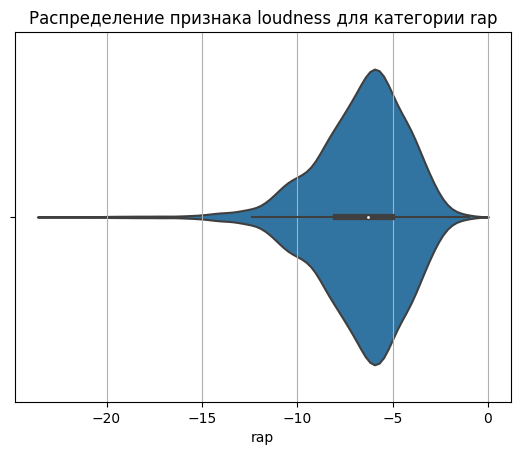

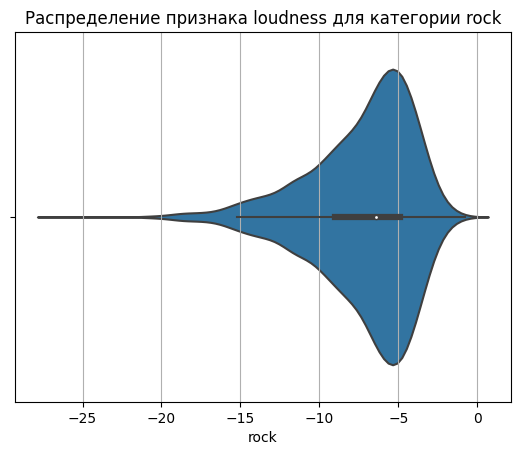

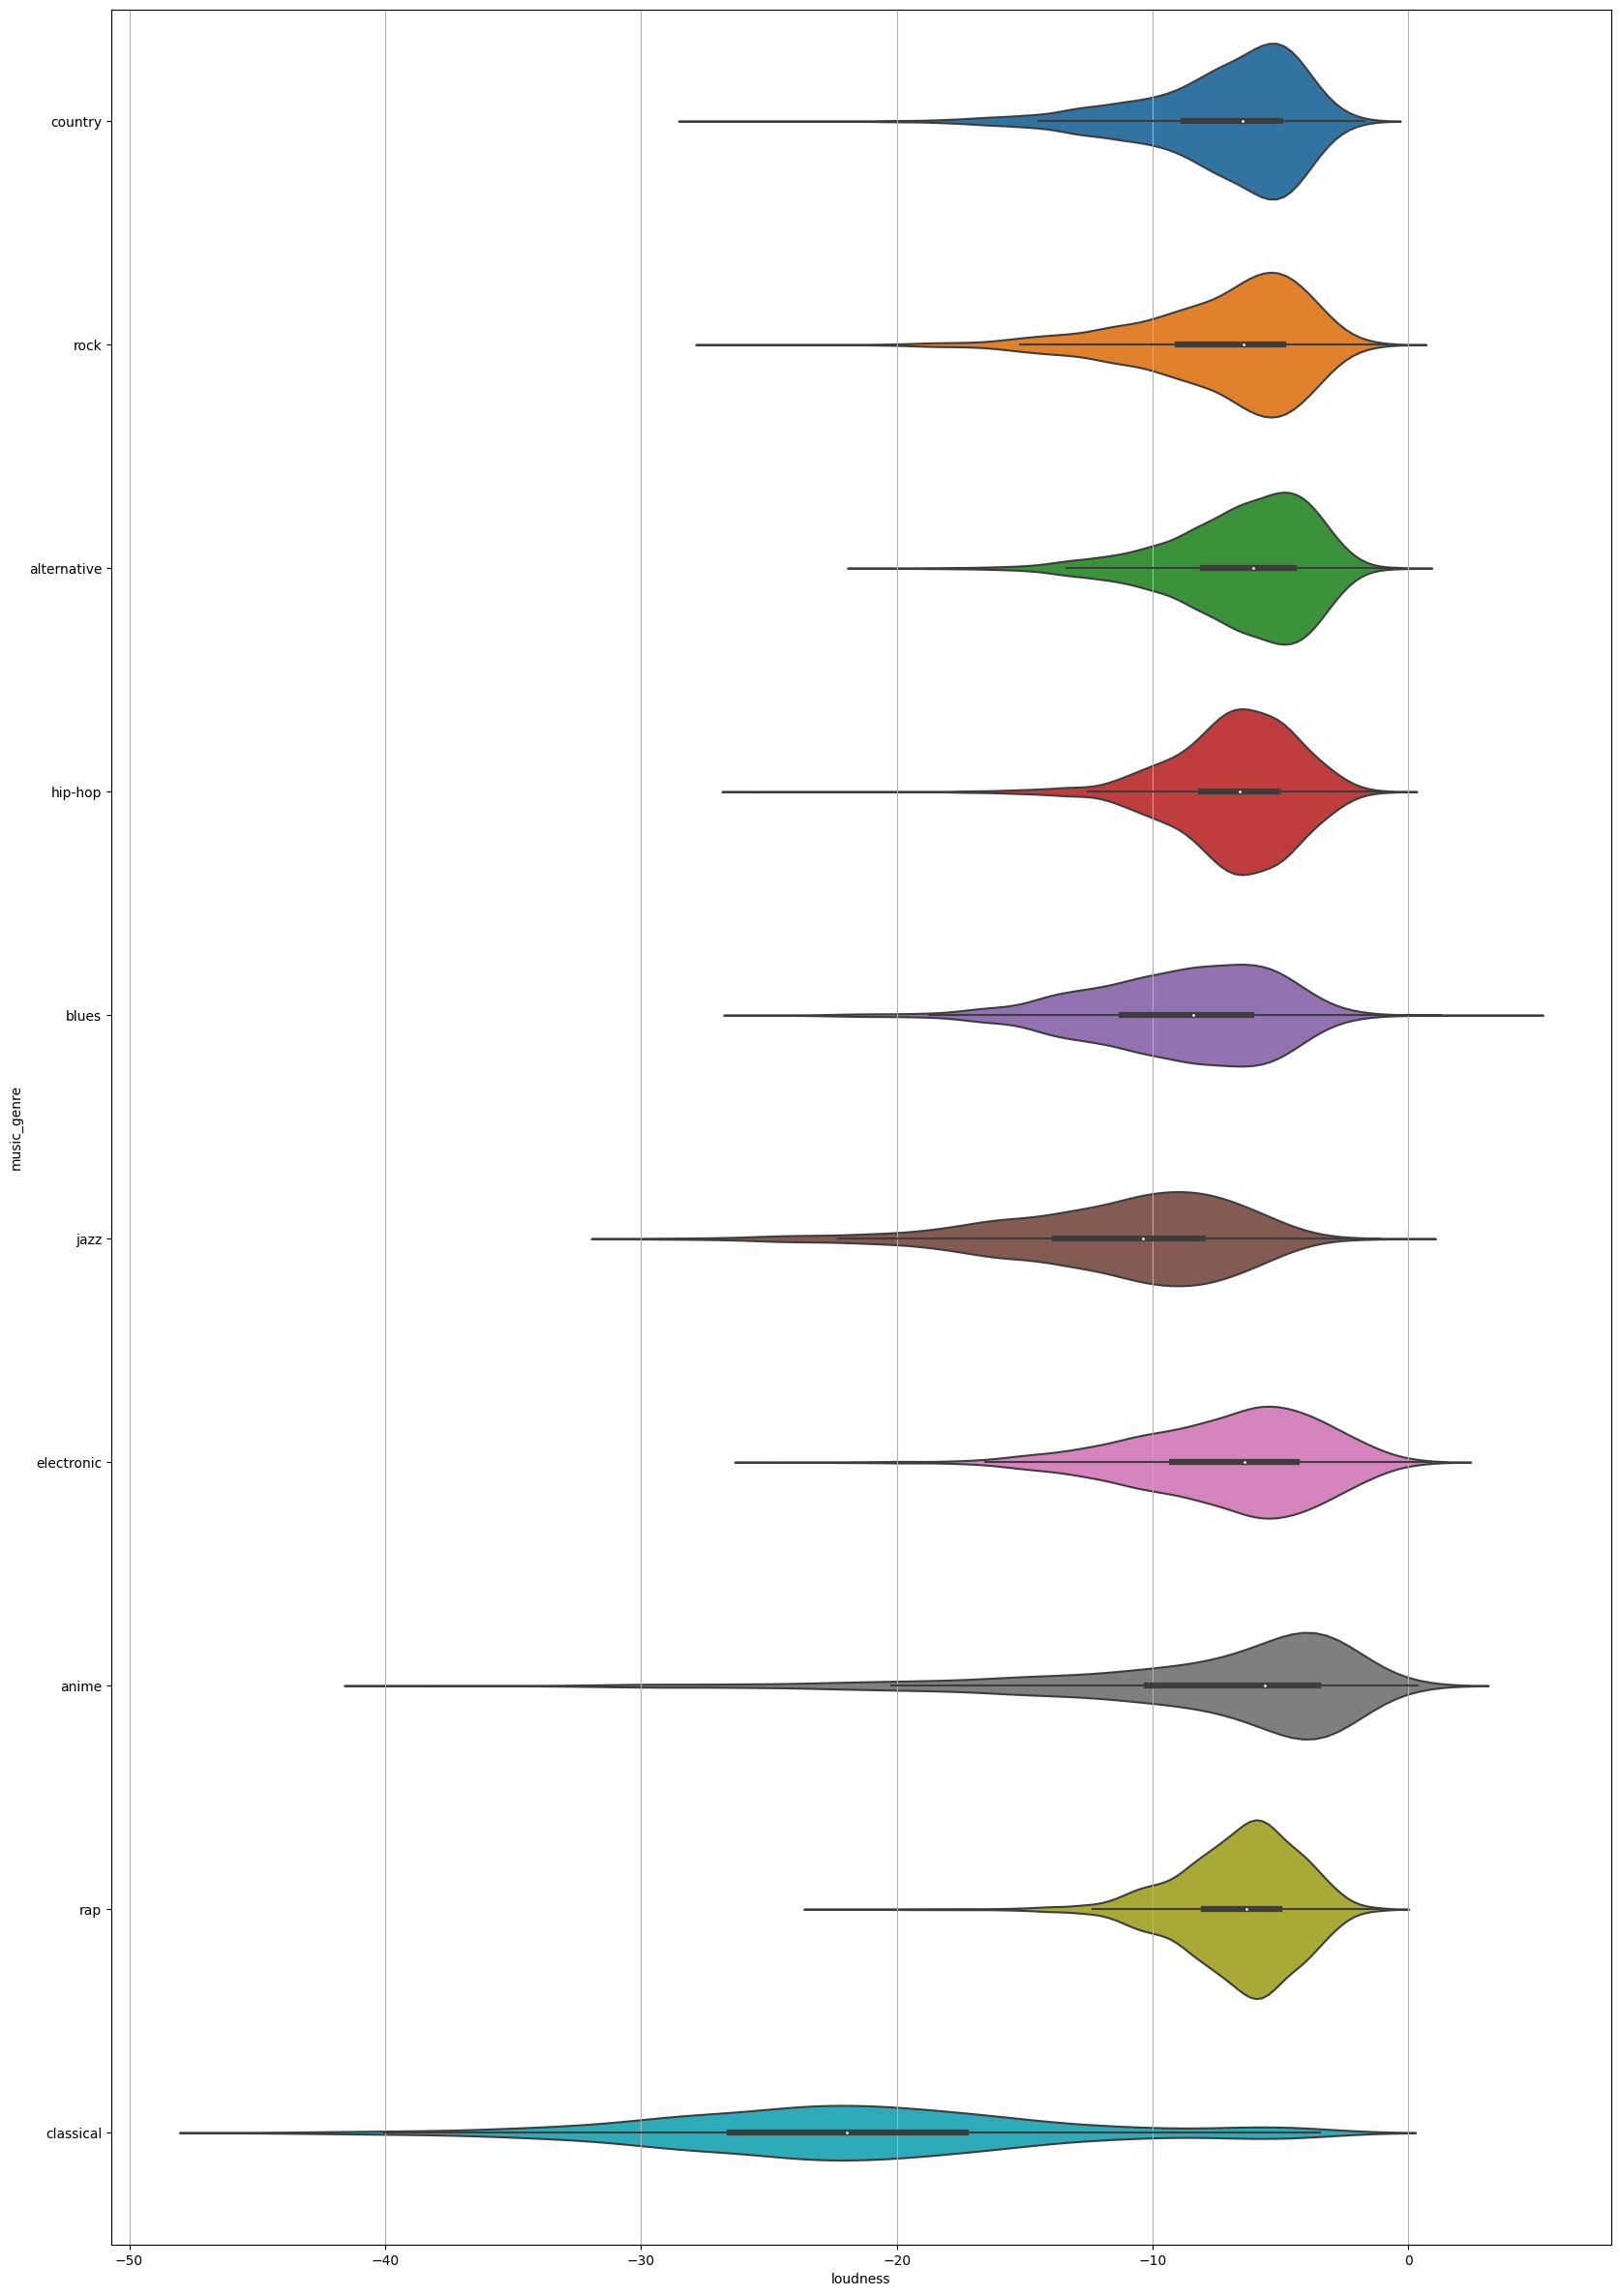

In [47]:
eda.create_category_violinplot(data, 'music_genre', 'loudness', True)

Данный график подтверждает выводы, полученные из сводной таблицы и гистограммы. Для всех категорий, кроме `classical` позожи. Распределения для категорий `jazz` и `blues` похожи на остальные, но имеют меньшее мат ожидание и поэтмоу смещены влево

## 3.10. <a id='toc3_10_'></a>[speechiness - выразительность](#toc0_)

In [48]:
data['speechiness'].describe()

count    18754.000000
mean         0.091178
std          0.097573
min          0.022300
25%          0.035600
50%          0.048950
75%          0.094900
max          0.932000
Name: speechiness, dtype: float64

mean  median     min    max
music_genre                                 
alternative  0.090044  0.0535  0.0232  0.869
anime        0.064464  0.0454  0.0229  0.498
blues        0.061243  0.0432  0.0231  0.812
classical    0.052710  0.0433  0.0244  0.631
country      0.050037  0.0341  0.0223  0.689
electronic   0.099664  0.0574  0.0242  0.739
hip-hop      0.208796  0.1955  0.0260  0.932
jazz         0.070369  0.0435  0.0230  0.714
rap          0.186517  0.1600  0.0229  0.922
rock         0.053641  0.0394  0.0224  0.437

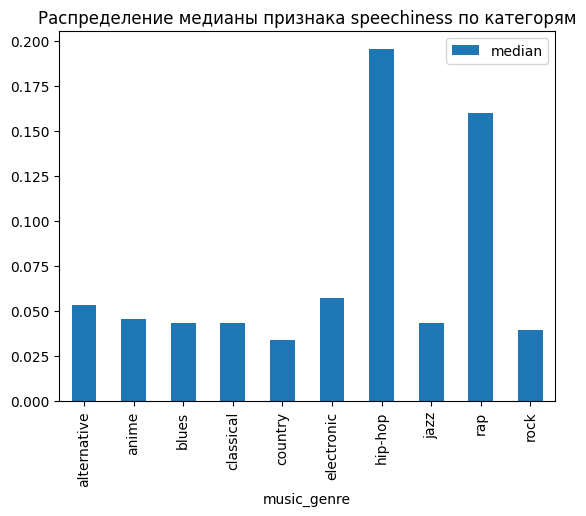

In [49]:
eda.create_pivot_table(data, 'music_genre', 'speechiness')

Из свобной таблицы и гистограммы видно, что категории `hip-hop` и `rap` сильно выделяются из остальных. Их значение медианы данного признака сильно больше, чем у остальных категорий (0.1955 для `hip-hop` и 0.16 для `rap`)

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


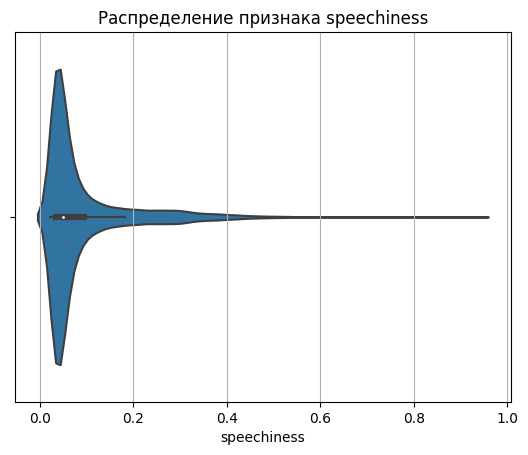

In [50]:
eda.create_violinplot(data, 'speechiness')

Из графика видно, что мат ожидание распределения признака находится около 0. Для получения более подробной информации построим такой график для каждой категории

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

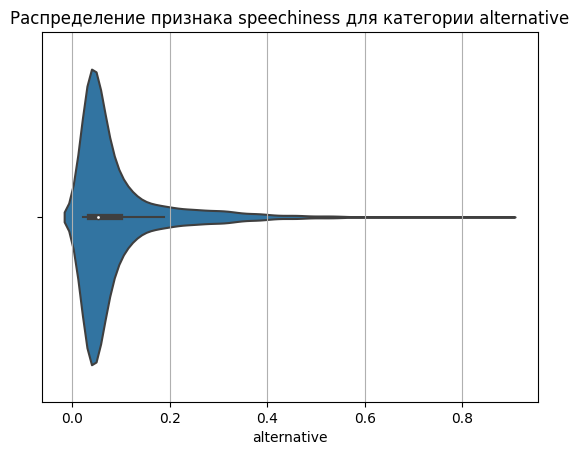

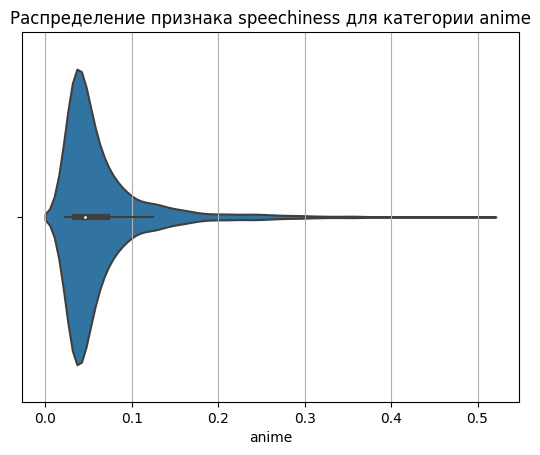

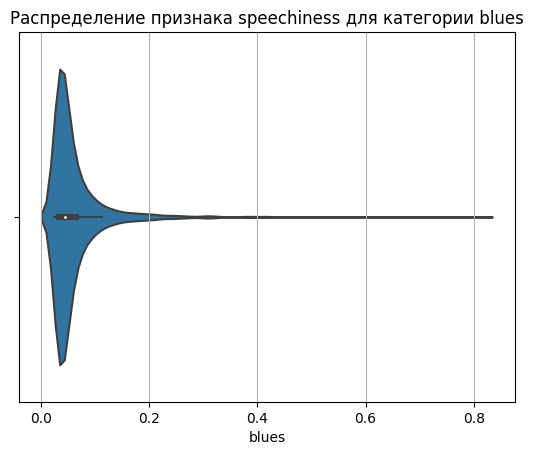

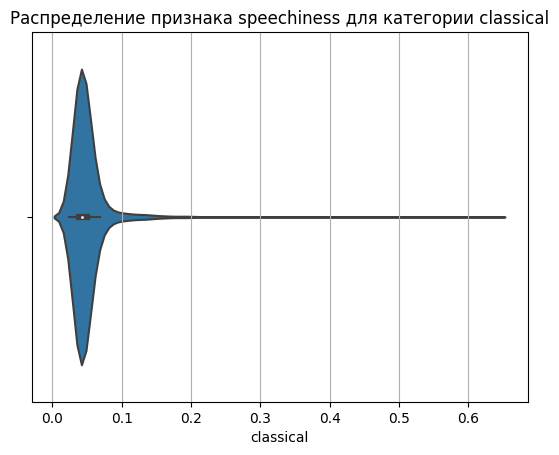

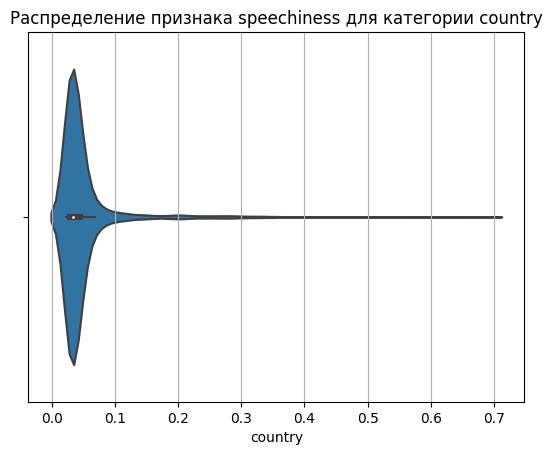

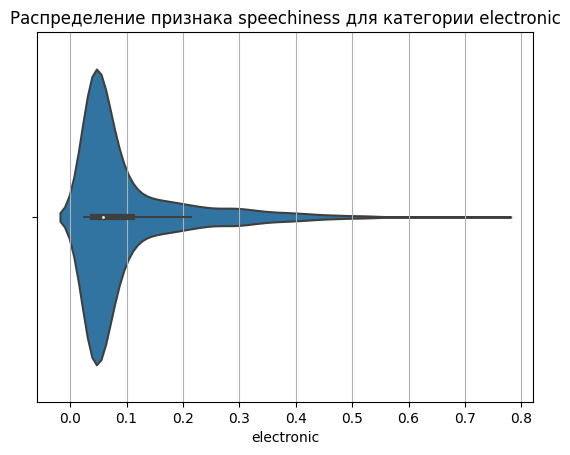

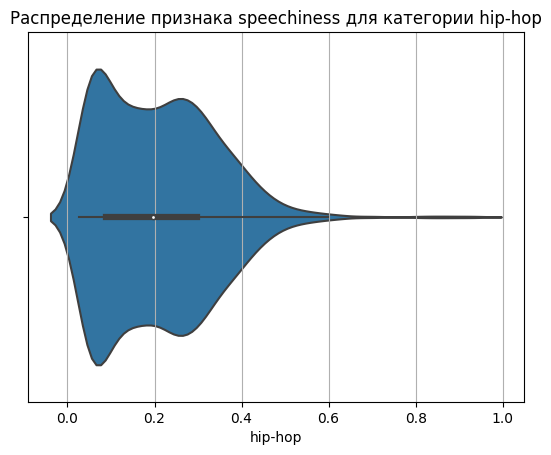

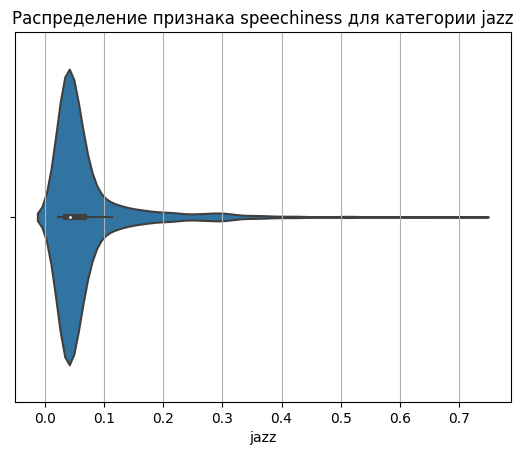

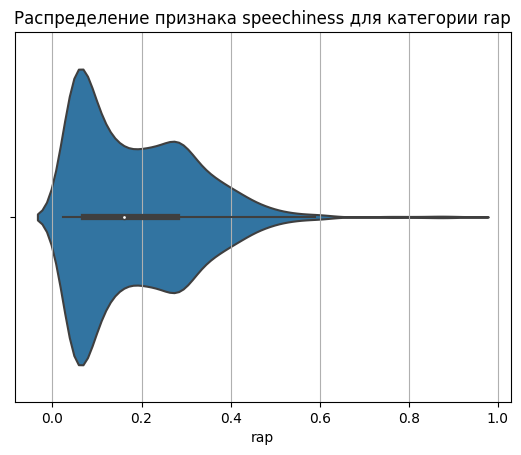

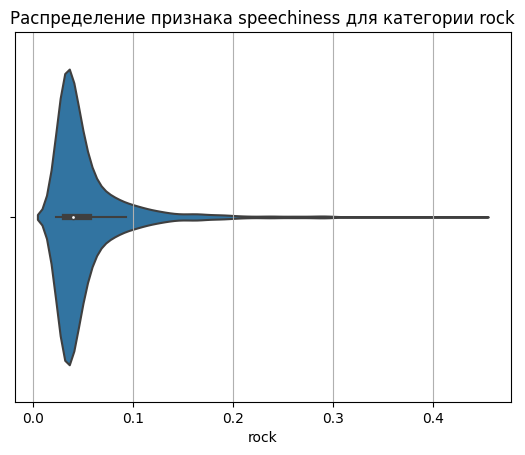

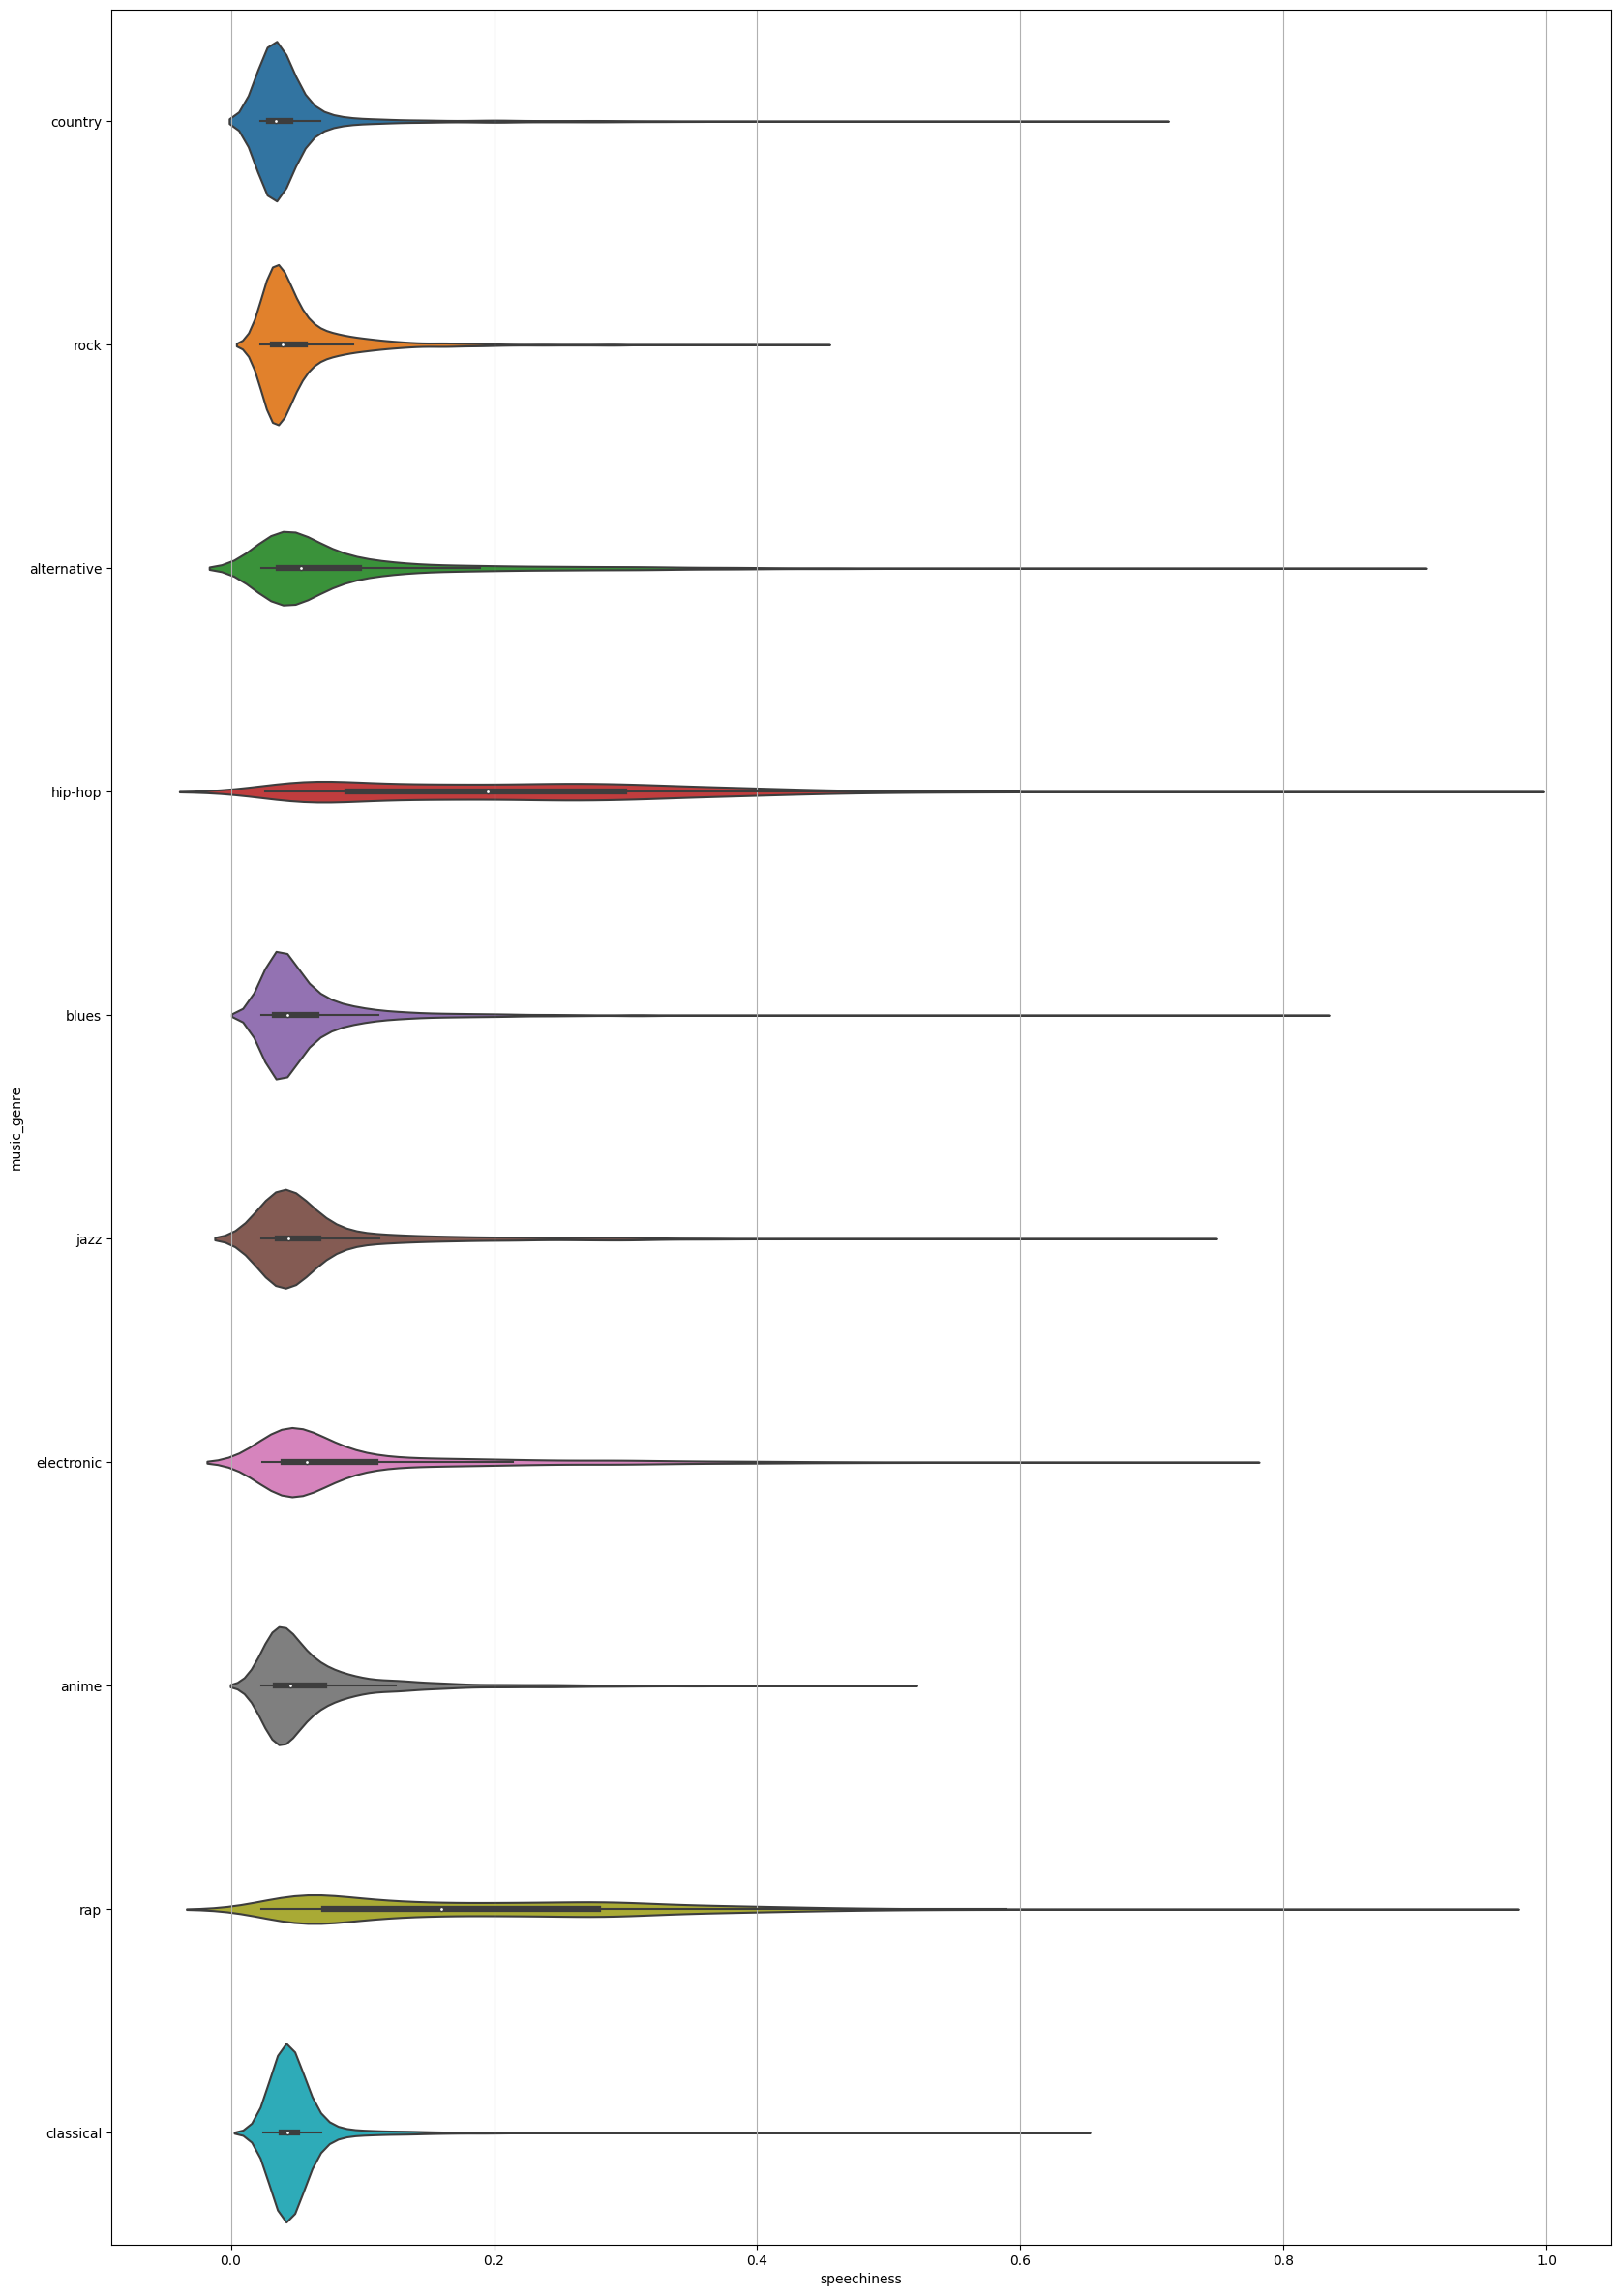

In [51]:
eda.create_category_violinplot(data, 'music_genre', 'speechiness', True)

Из графиков видно, что распределения для всех категорий, кроме `hip-hop` и `rap` очень похожи между собой. Распределения для категорий `hip-hop` и `rap` очень похожи между собой - они имеют 2 вершины.

## 3.11. <a id='toc3_11_'></a>[tempo - темп](#toc0_)

In [52]:
data['tempo'].describe()

count    18754.000000
mean       120.929143
std         30.423797
min         34.765000
25%         95.937250
50%        120.011000
75%        141.949000
max        220.041000
Name: tempo, dtype: float64

mean    median     min      max
music_genre                                       
alternative  122.983862  120.0520  51.316  212.137
anime        126.668986  128.0300  47.704  207.867
blues        121.383258  119.1180  47.587  215.918
classical    102.980021   95.4190  34.856  207.863
country      122.920794  121.5350  58.095  208.307
electronic   126.557267  126.0010  54.951  220.041
hip-hop      120.719383  120.7745  47.917  207.852
jazz         111.415939  105.2670  34.765  208.072
rap          119.966410  120.0305  47.811  206.247
rock         122.327262  120.8910  46.591  219.331

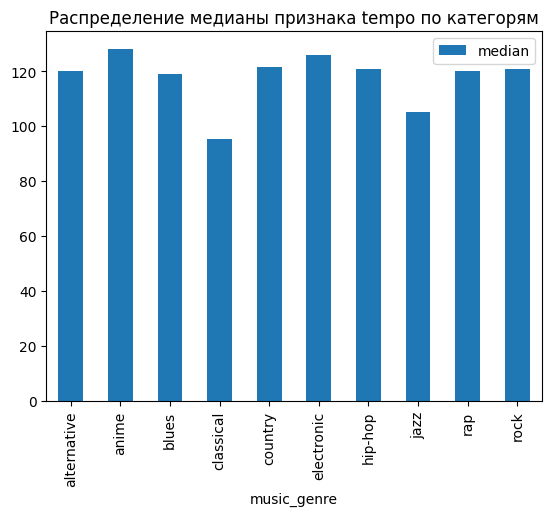

In [53]:
eda.create_pivot_table(data, 'music_genre', 'tempo')

Из сводной таблицы и гистограммы видно, что наименьшую медиану темпа имеют категории `classical` и `jazz` (95.4190 и 105.267) соответственно. Остальные категории имеют примерно равную медиану темпа

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


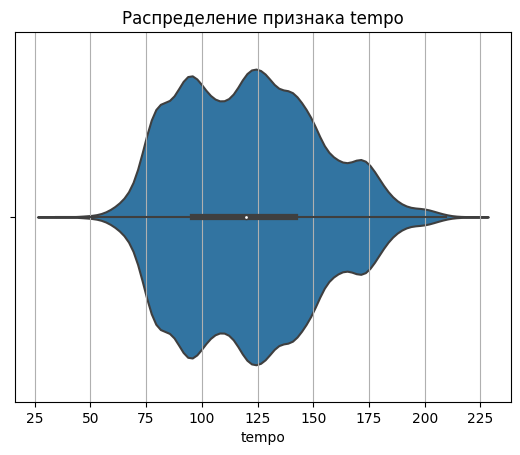

In [54]:
eda.create_violinplot(data, 'tempo')

Из графика видно, что распрееделение признака имеет 3 выраженные вершины. Построим распределение признака по категория для получения более детальной информации

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

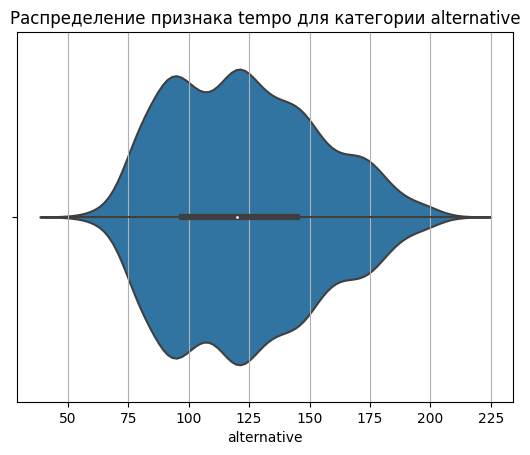

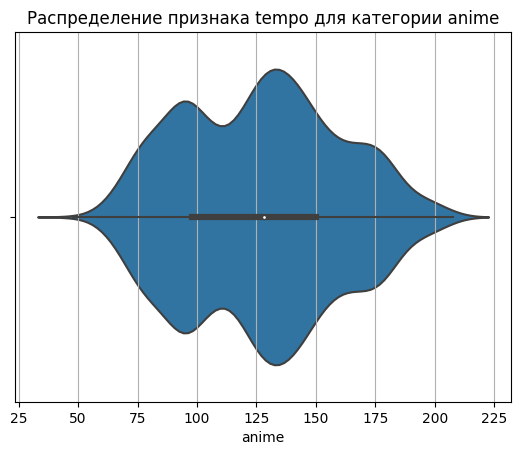

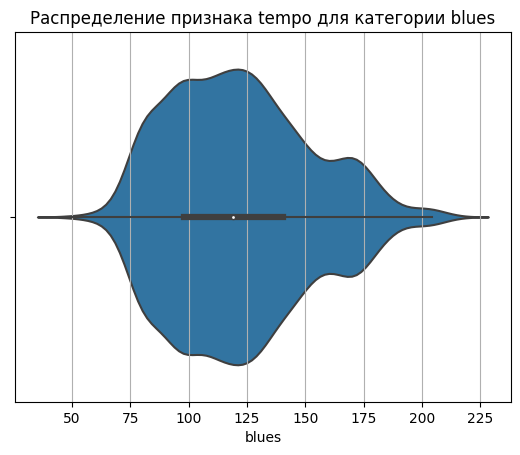

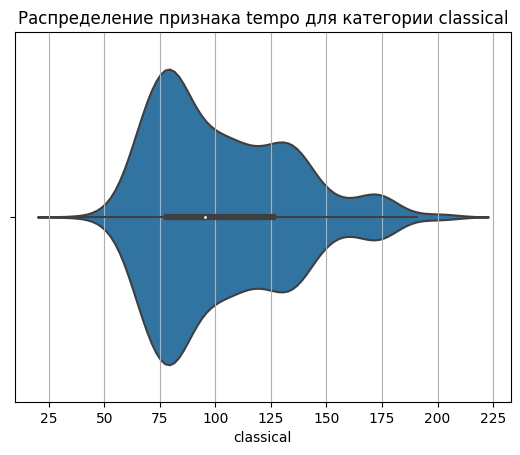

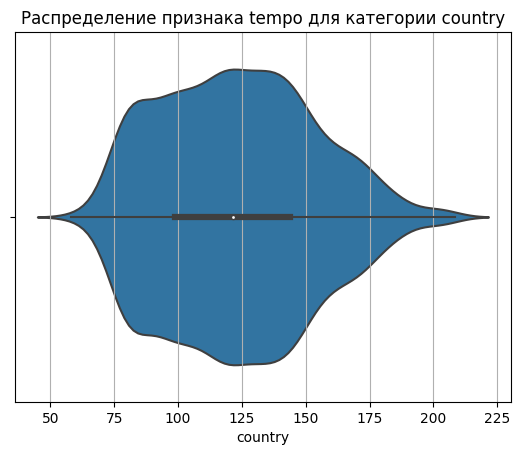

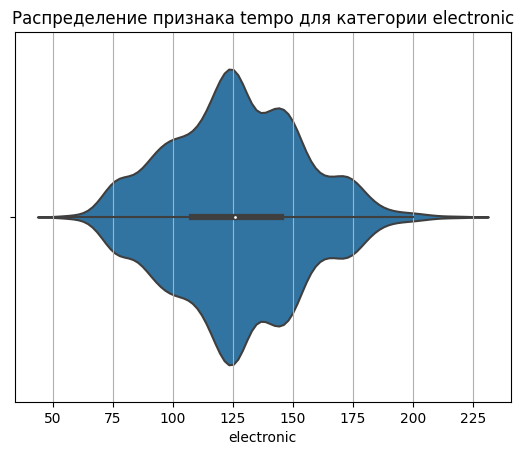

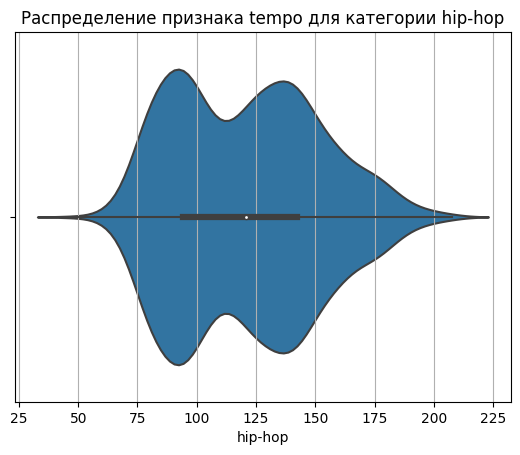

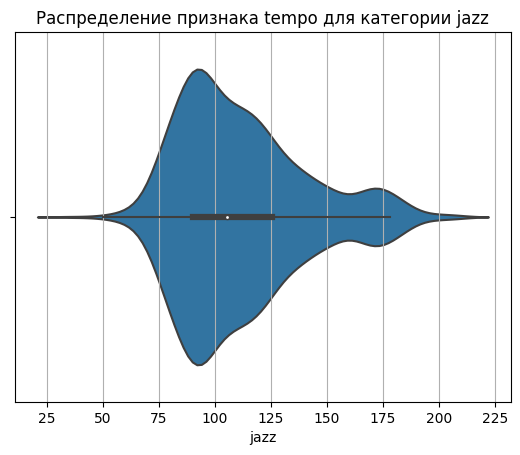

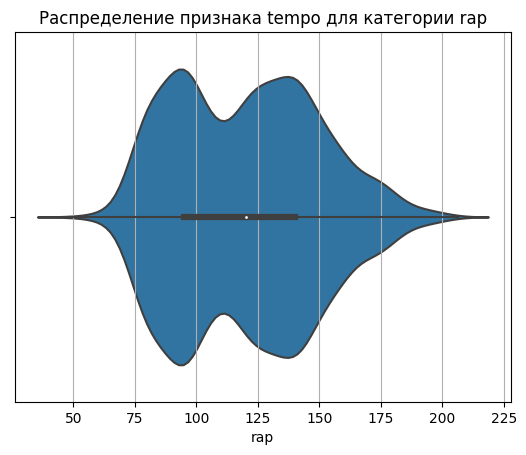

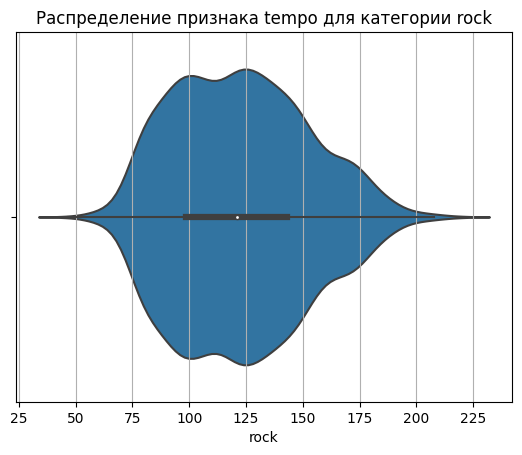

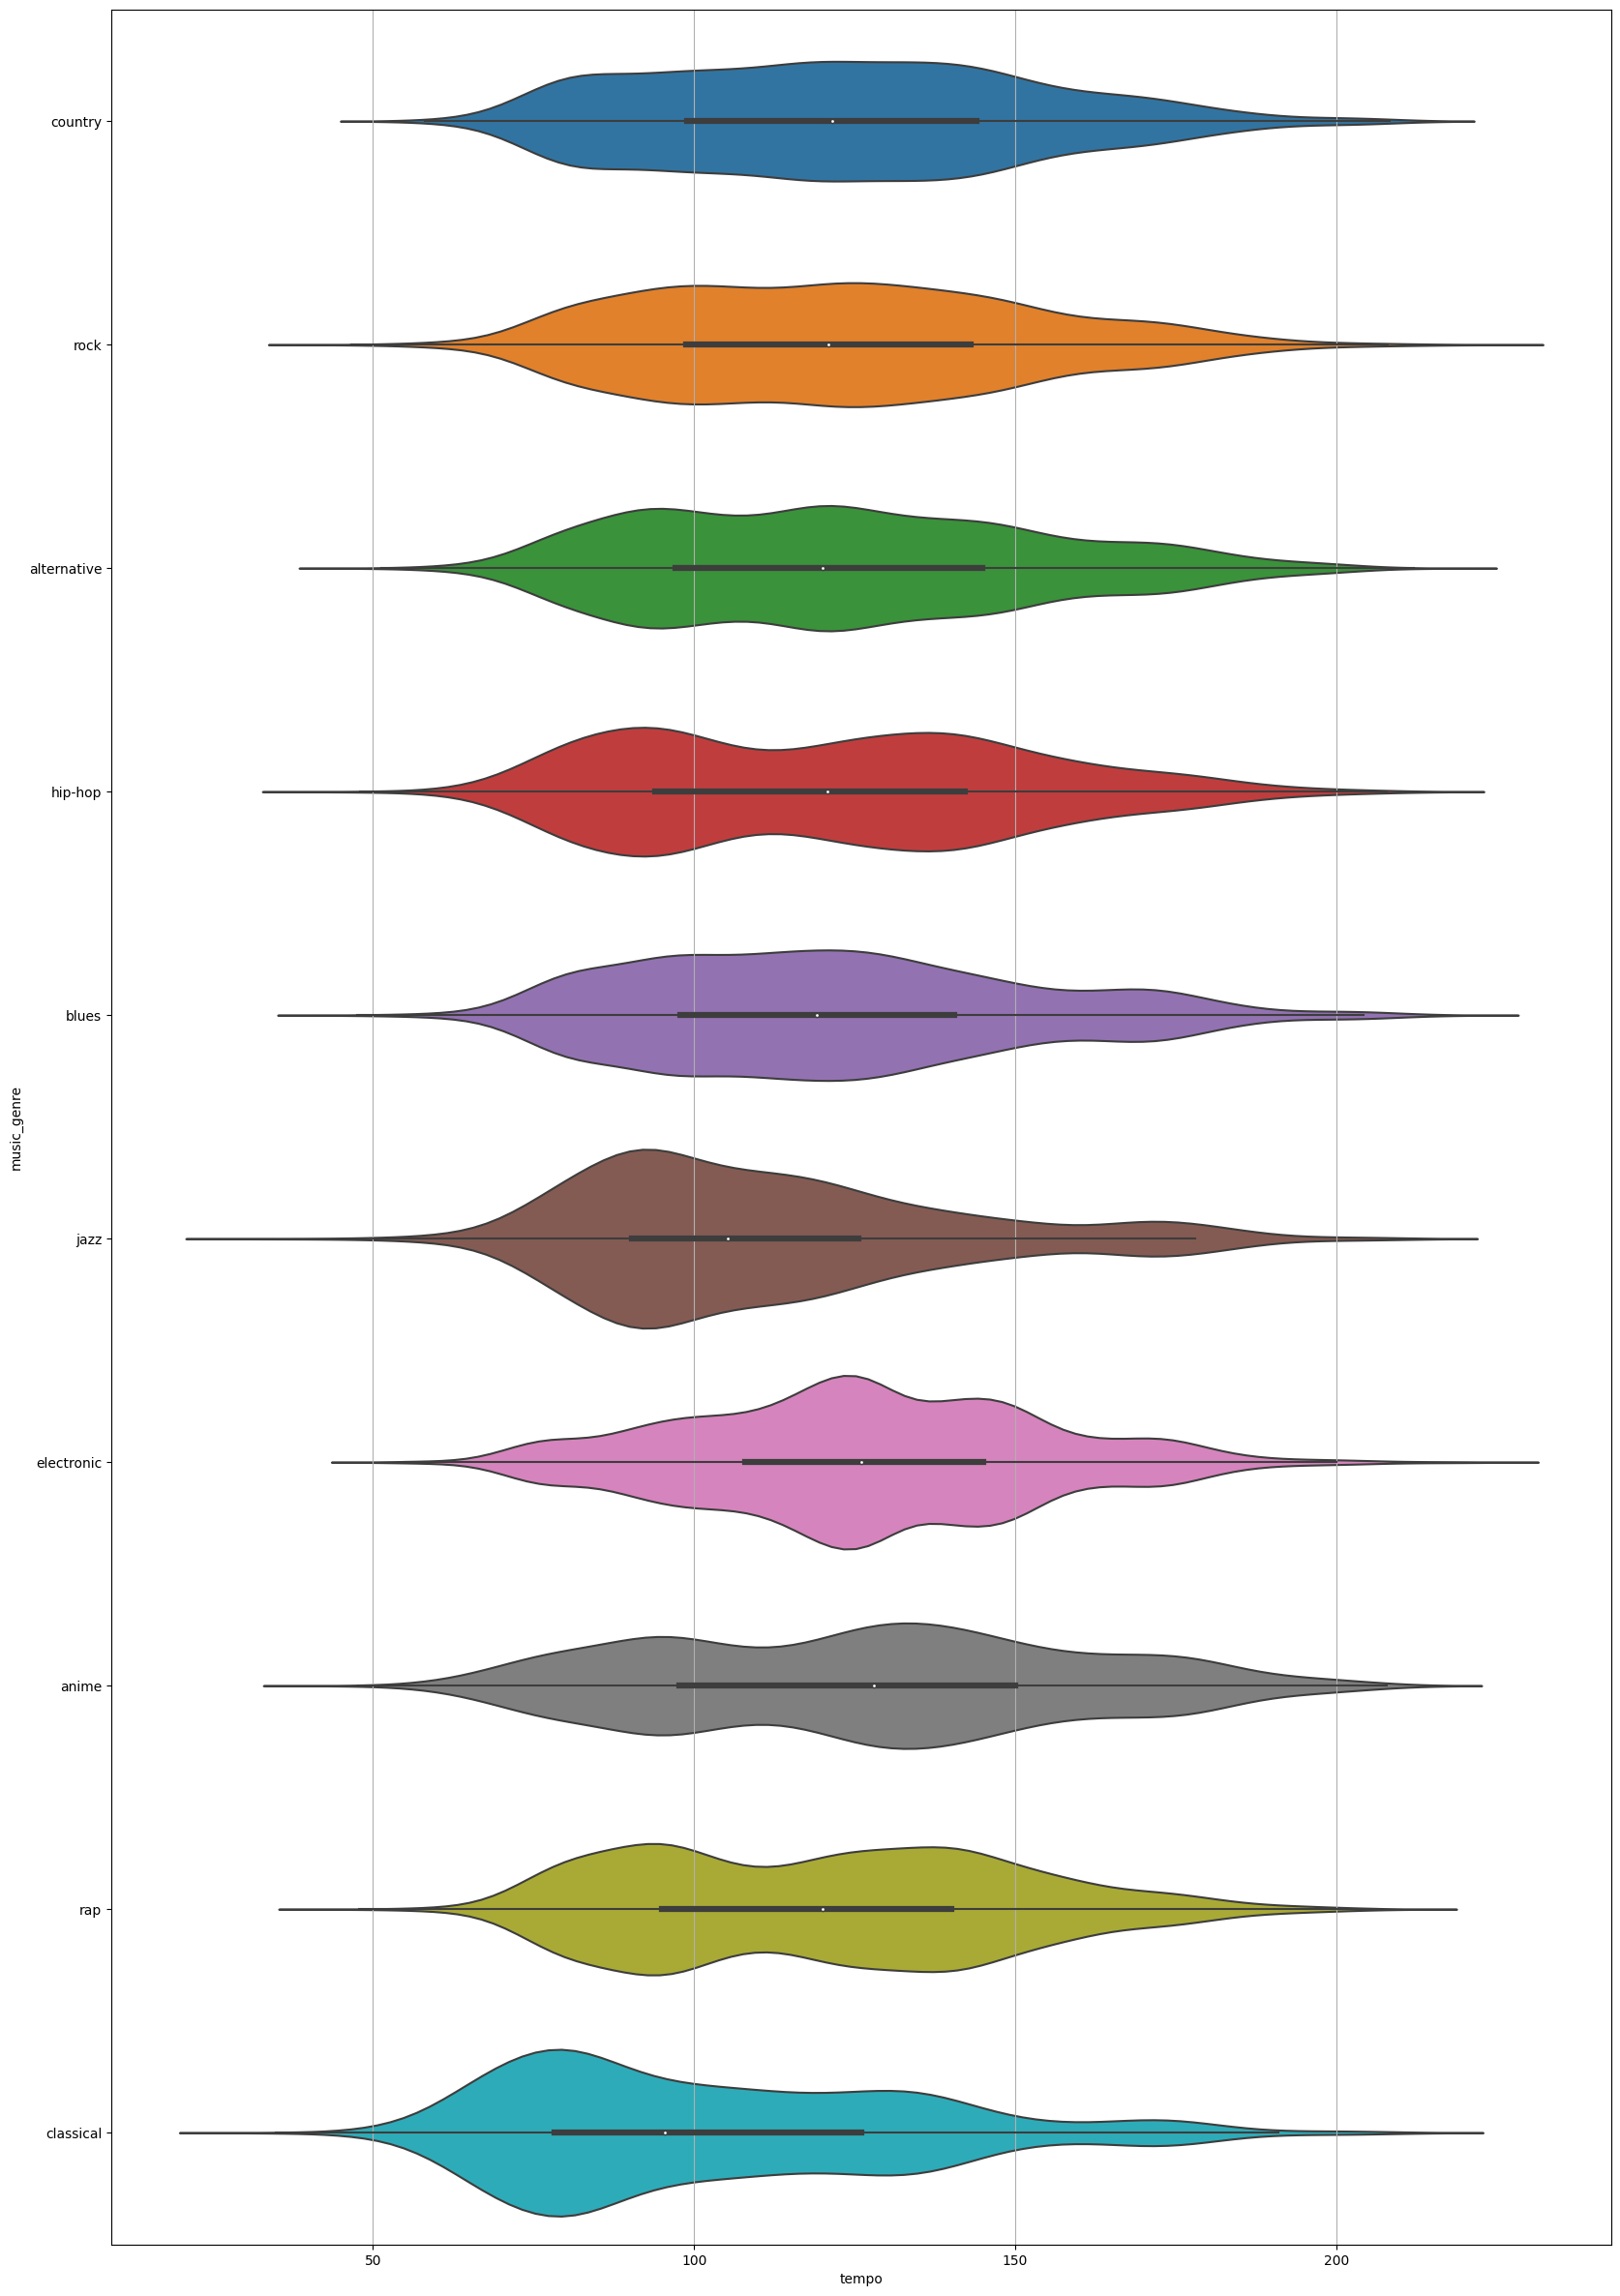

In [55]:
eda.create_category_violinplot(data, 'music_genre', 'tempo', True)

Распределения категорий `classical` и `jazz` выделяются из другихх - одни имеют по одной вершине. Категория `electronic` имеет одну более выраженную и вторую менее выраженную вершины. Категории `blues` и `alternative` имеет одну вершину с большой дисперсией. Остальные распределения похожи между собой

## 3.12. <a id='toc3_12_'></a>[valence - привлекательность произведения для пользователей сервиса](#toc0_)

In [56]:
data['valence'].describe()

count    18754.000000
mean         0.464954
std          0.243685
min          0.000000
25%          0.272000
50%          0.457000
75%          0.654000
max          0.992000
Name: valence, dtype: float64

mean  median     min    max
music_genre                                 
alternative  0.448502   0.432  0.0356  0.973
anime        0.435118   0.435  0.0252  0.986
blues        0.577972   0.586  0.0315  0.985
classical    0.208411   0.138  0.0000  0.938
country      0.541813   0.532  0.0594  0.977
electronic   0.389567   0.361  0.0276  0.992
hip-hop      0.477305   0.470  0.0375  0.979
jazz         0.503568   0.516  0.0289  0.978
rap          0.458624   0.451  0.0336  0.970
rock         0.517865   0.517  0.0277  0.985

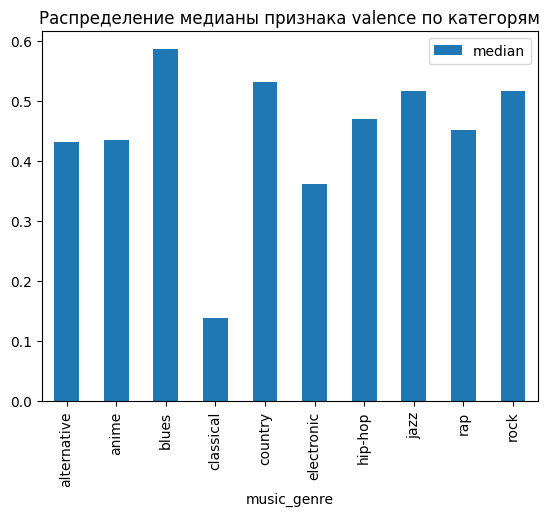

In [57]:
eda.create_pivot_table(data, 'music_genre', 'valence')

Категория `classical` сильно выделяется из остальных. Она имеет наименьшее значение медианы признака (0.138). Также не очень высокое значение медианы имеет категория `electronic` (0.361). Категория `blues` выделятеся самым высоким значением медианы признака (0.586)

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


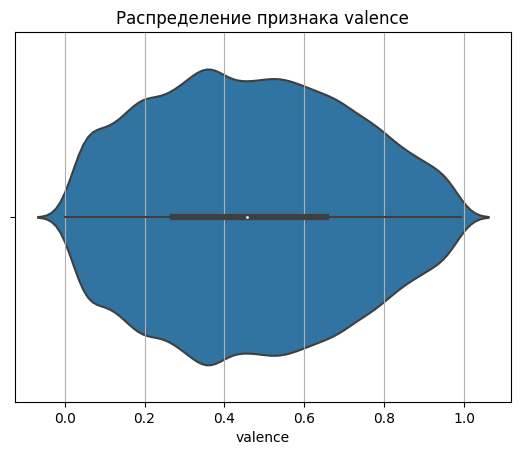

In [58]:
eda.create_violinplot(data, 'valence')

Распределение похоже на нормальное с большое дисперсией. Построим графики по категориям

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


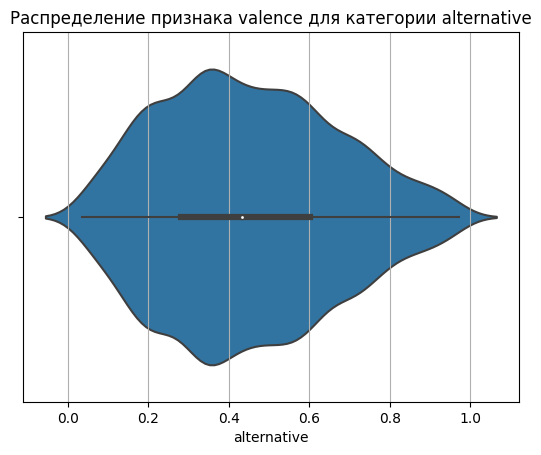

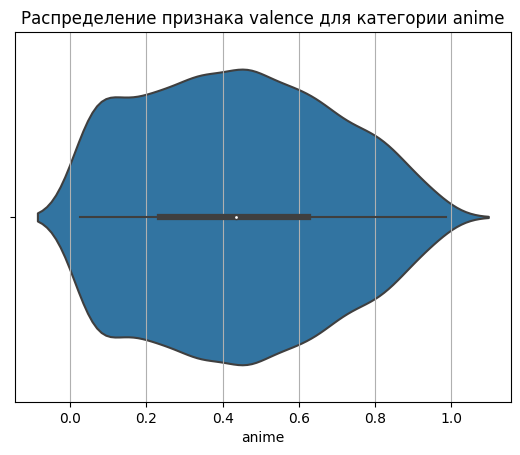

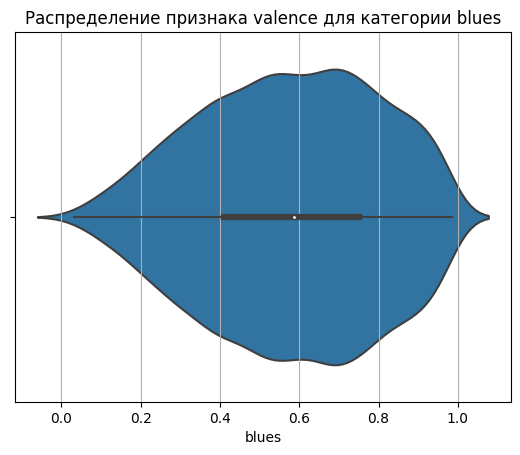

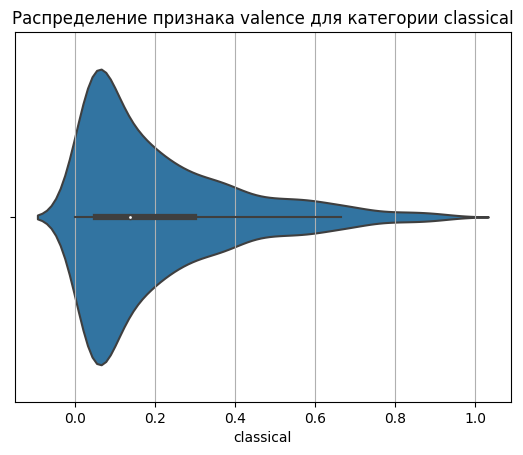

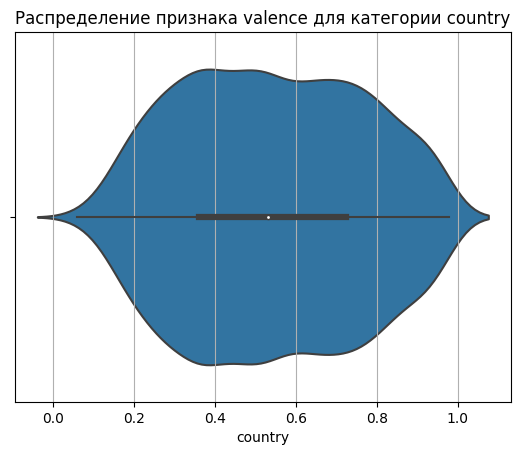

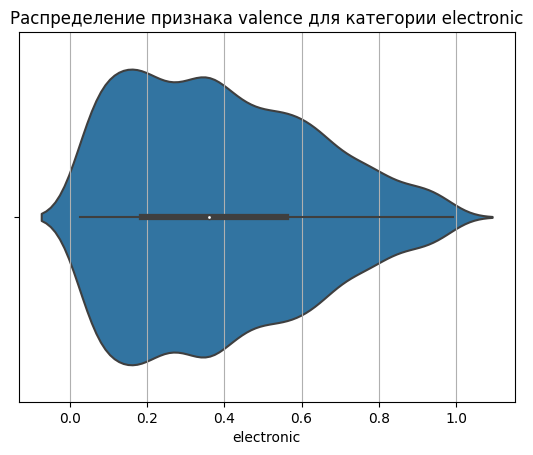

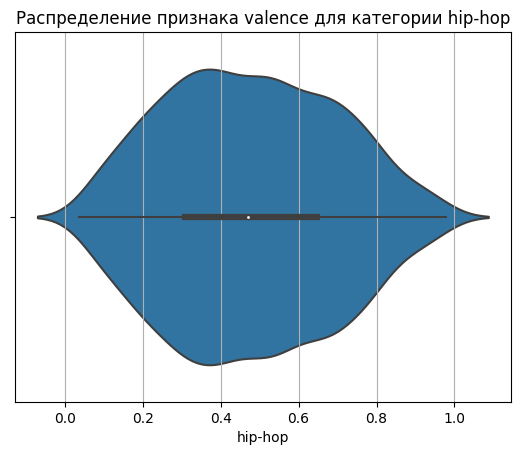

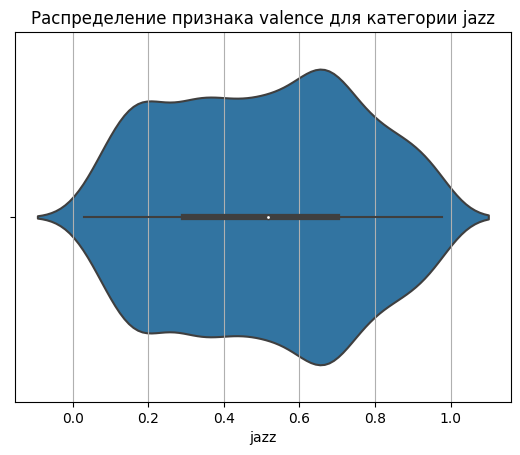

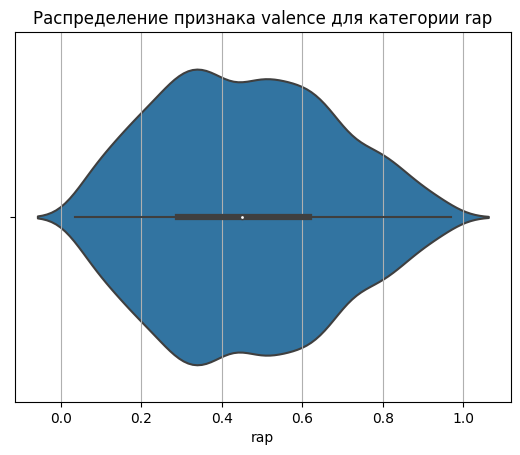

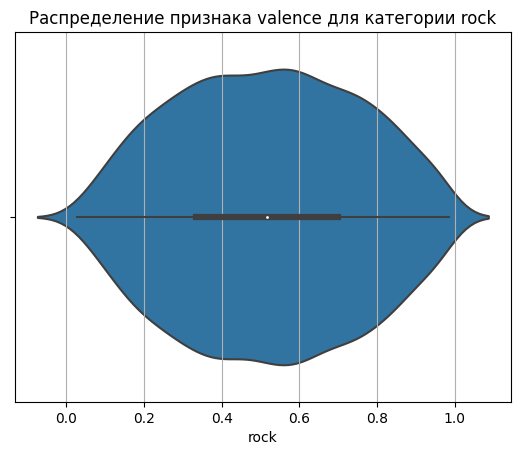

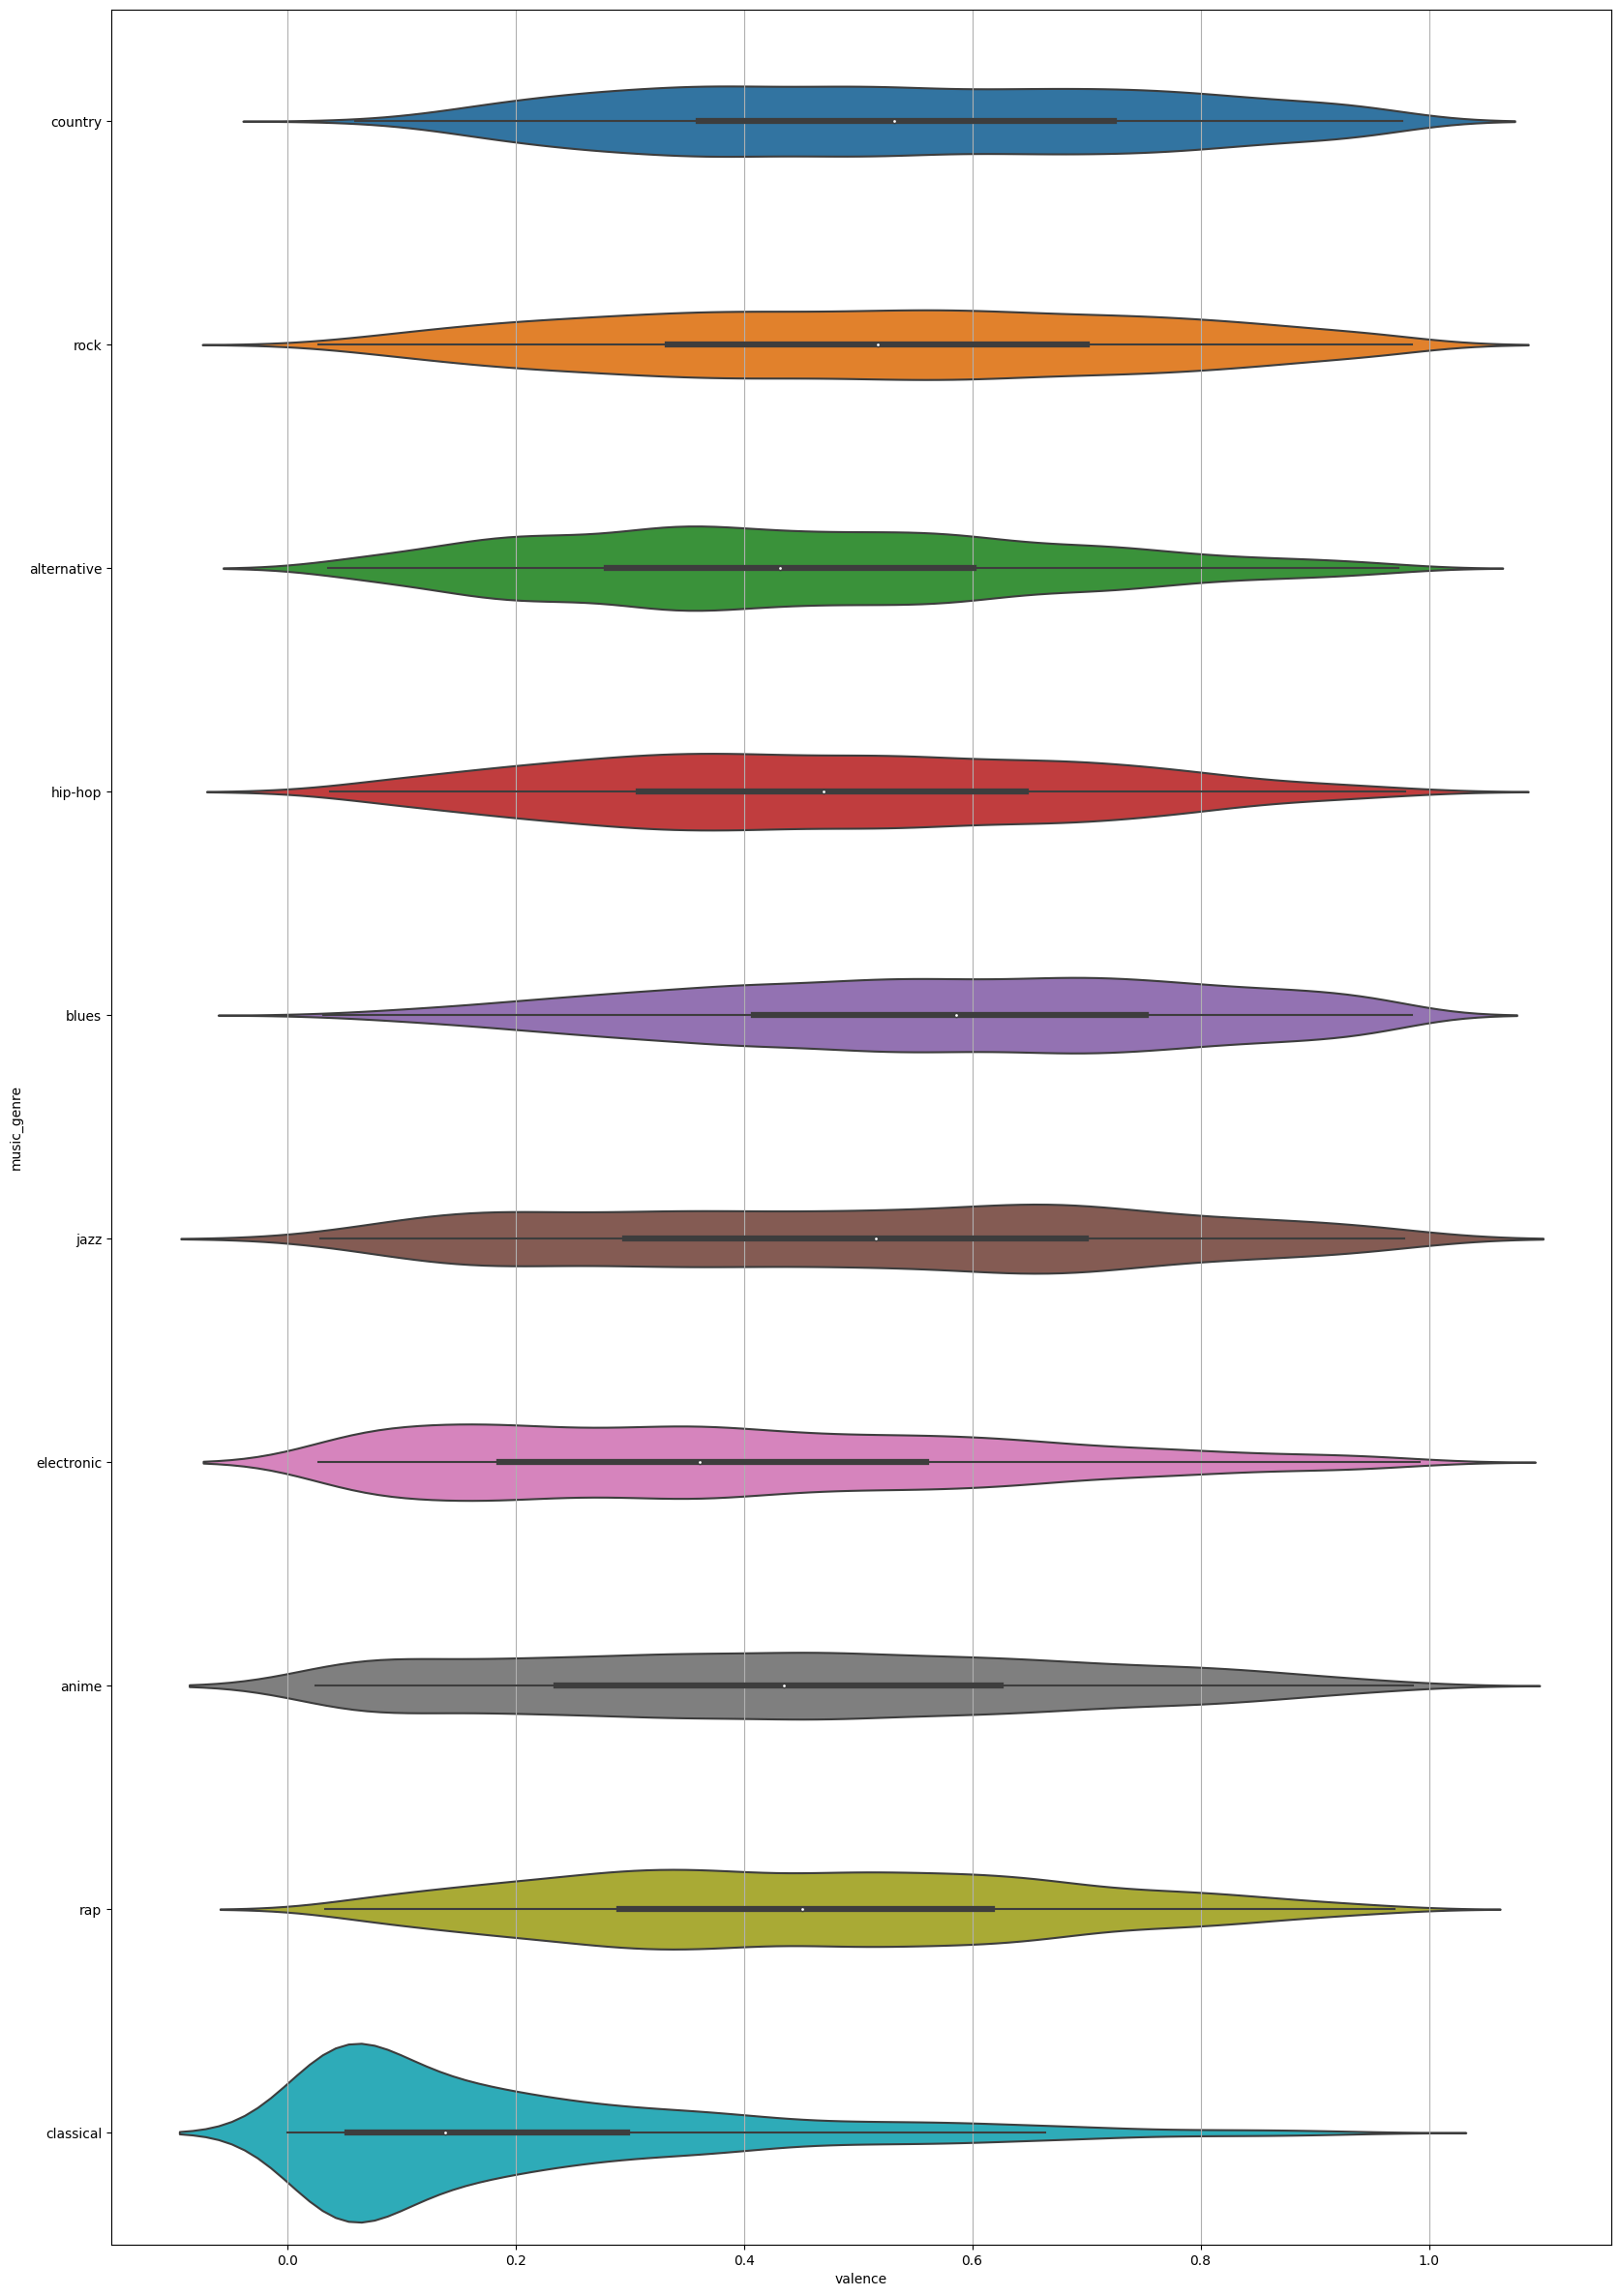

In [59]:
eda.create_category_violinplot(data, 'music_genre', 'valence', True)

За исключением категорий `blues`, `classical`, `electronic` все распределения похожи между собой.
1. Распределение категории `blues` скошено влево
2. Распределения `classical`, `electronic` наоборот скошены вправо

## 3.13. <a id='toc3_13_'></a>[key - базовый ключ (нота) произведения](#toc0_)

In [60]:
data['key'].value_counts()

key
g     2198
c     2052
c#    2022
d     2021
a     1914
f     1539
b     1448
e     1443
g#    1216
a#    1174
f#    1145
d#     582
Name: count, dtype: int64

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


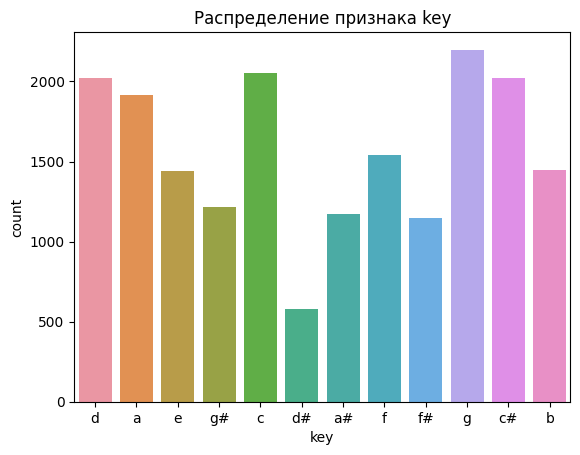

In [61]:
eda.create_countplot(data, 'key')

Из диаграммы видно, что ноты E, G#, D#, A#, F, F#, B используются реже остальных. Реже всего используется нота D# (582 семпла) Самая популярная нота - G (2198 семплов). Посмотрим, как распределеяется признак в различных категориях.

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

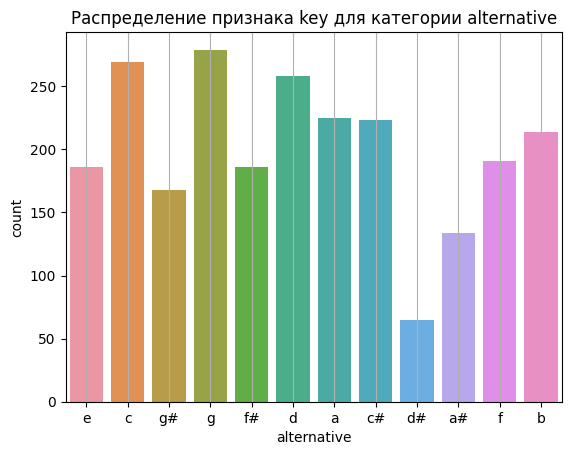

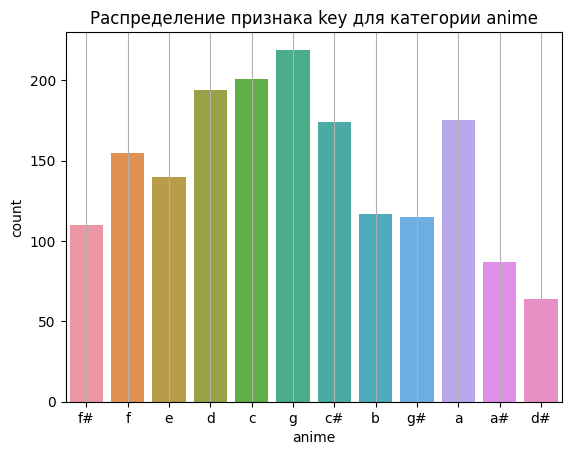

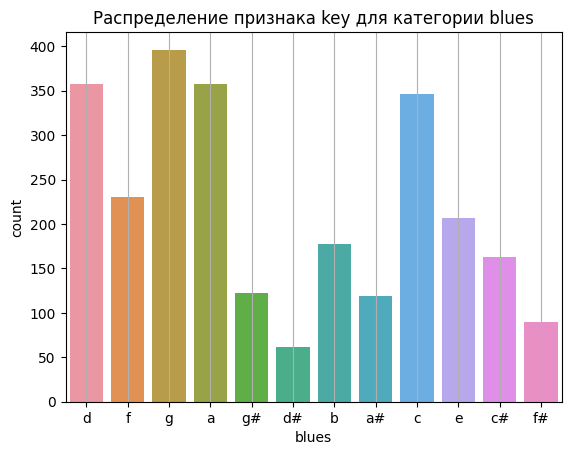

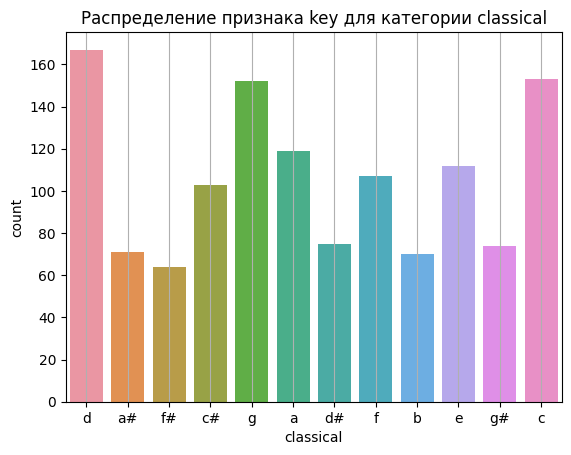

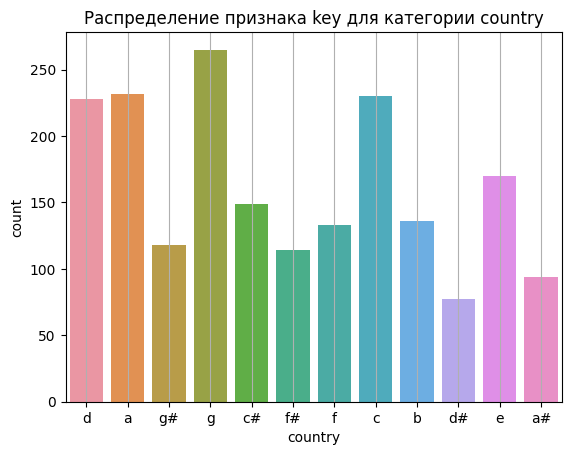

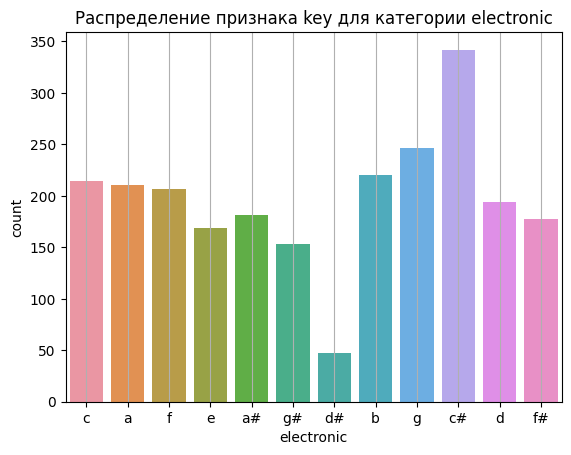

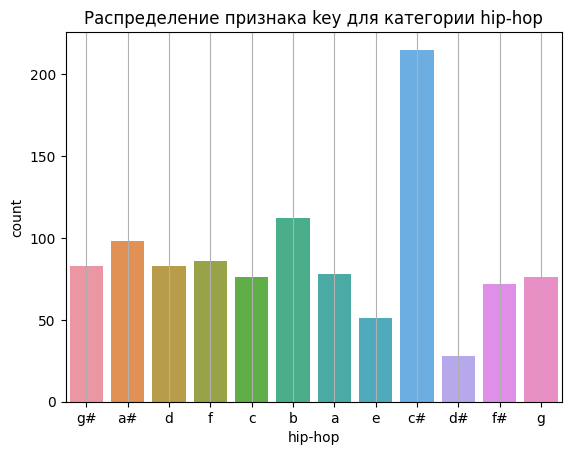

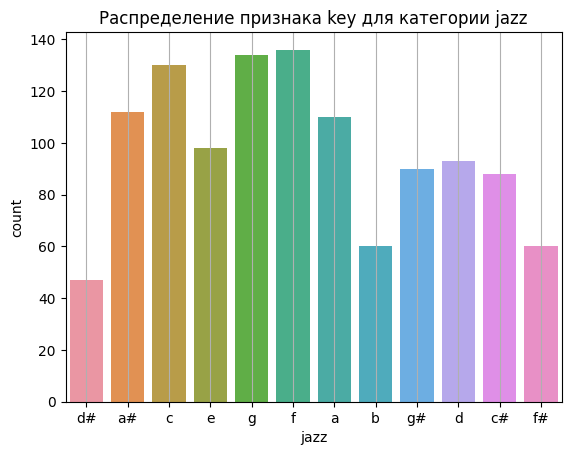

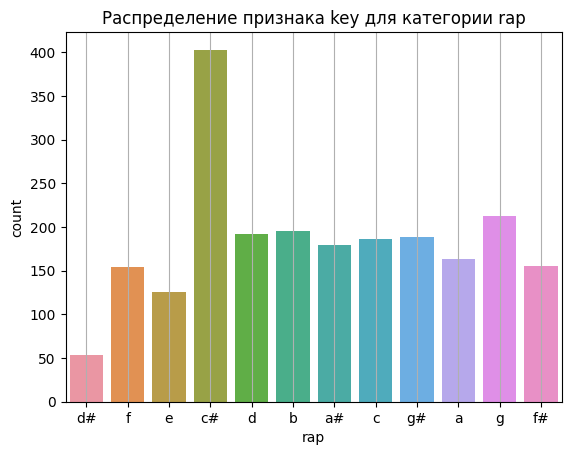

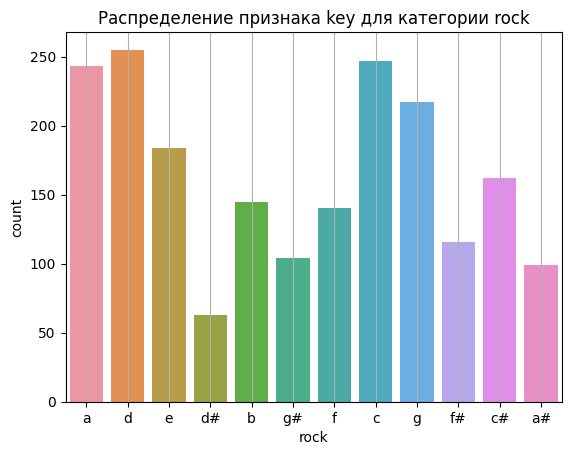

In [62]:
eda.create_category_countplot(data, 'music_genre', 'key')

Из полученных графиков можно подметить следуюзщие особенности категорий:
1. В категориях `alternative` и `anime`, `classical` преобладают базовые ключи C, G, D
2. В категориях `blues` и `counry`, `rock` преобладают базовые ключи C, G, D, A
3. В категориях `electronic` и `hip-hop`, `rap` преобладают базовые ключи С#
4. В категории `jazz` преобладают ключи C, G, F

## 3.14. <a id='toc3_14_'></a>[mode - указывает на модальность (мажорную или минорную) трека](#toc0_)

In [63]:
data['mode'].value_counts()

mode
major    12113
minor     6641
Name: count, dtype: int64

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


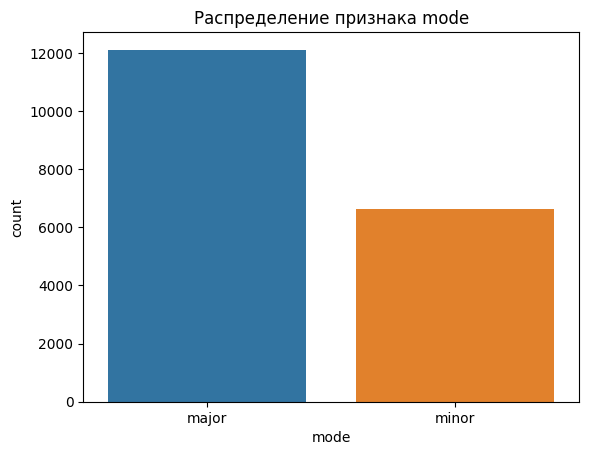

In [64]:
eda.create_countplot(data, 'mode')

Видно, что в песнях сильно преобладает модальность major (12113). Модальность minor встречается лишь в 6641 семплах.  
Посмотрим на распределение модальности в отдельных категориях

d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\practicum\music_genre\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

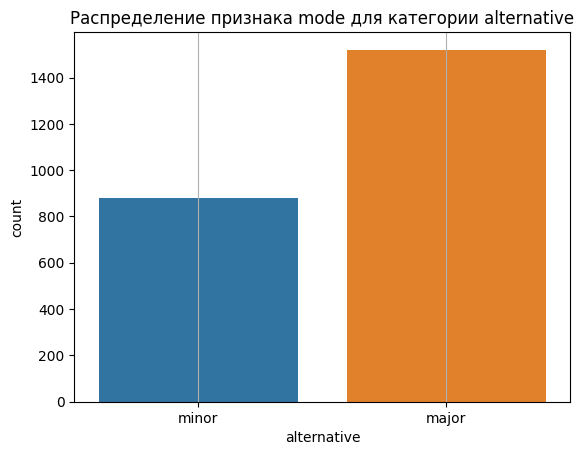

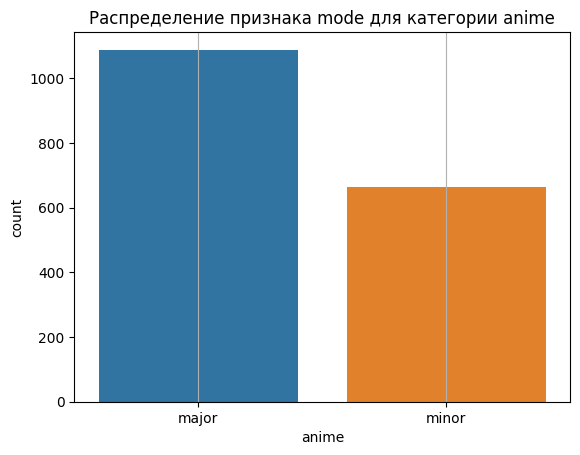

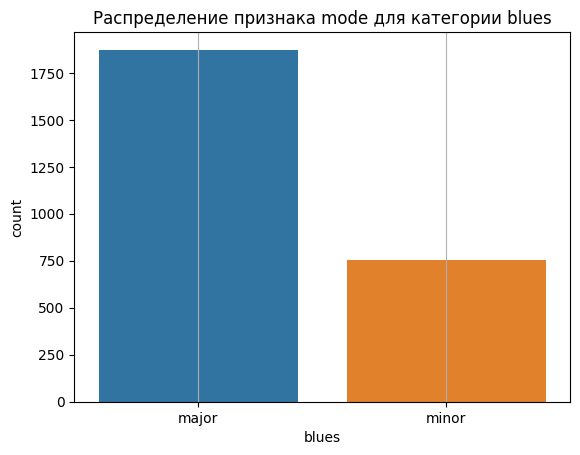

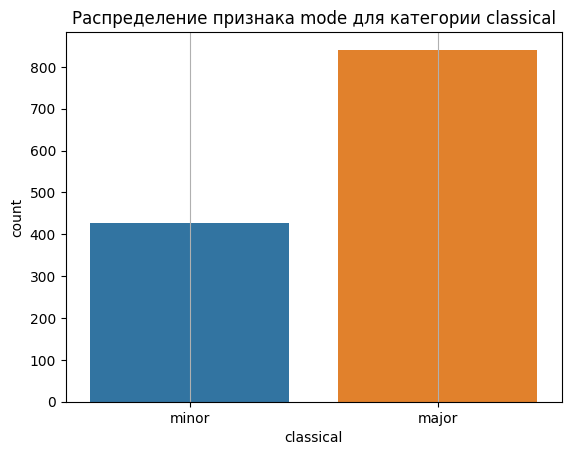

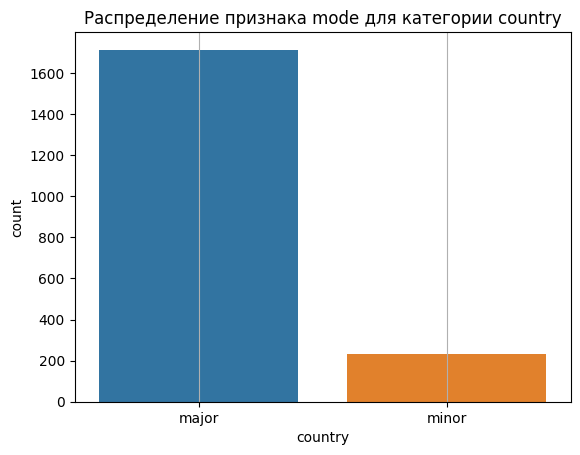

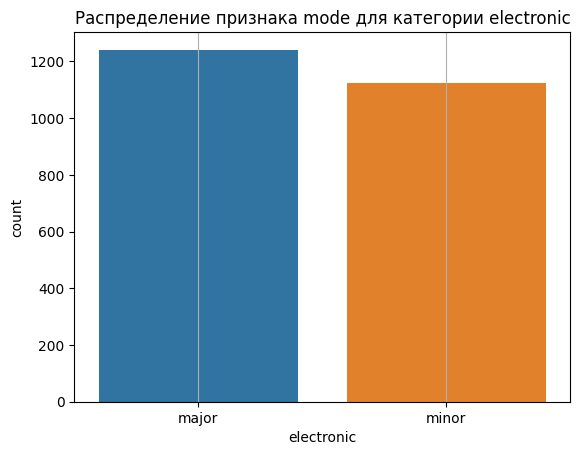

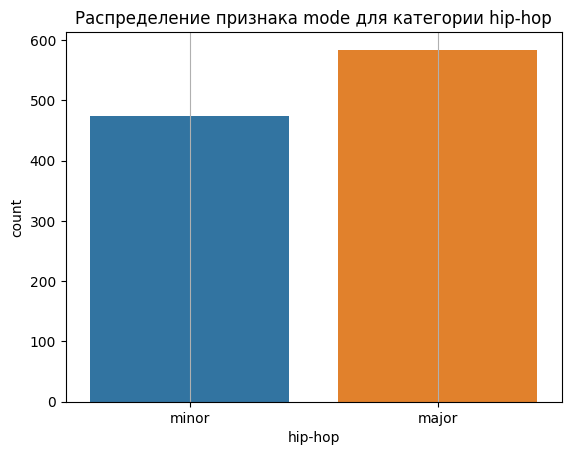

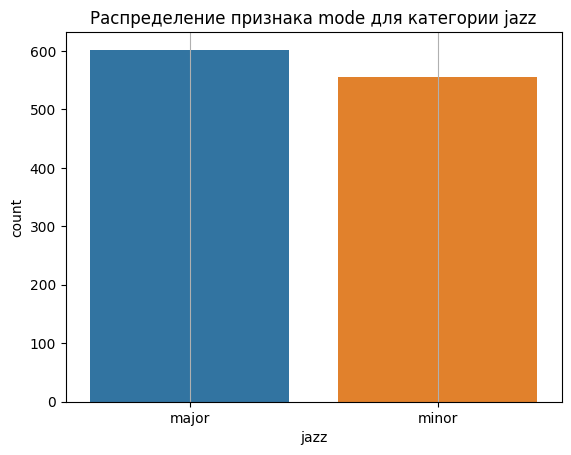

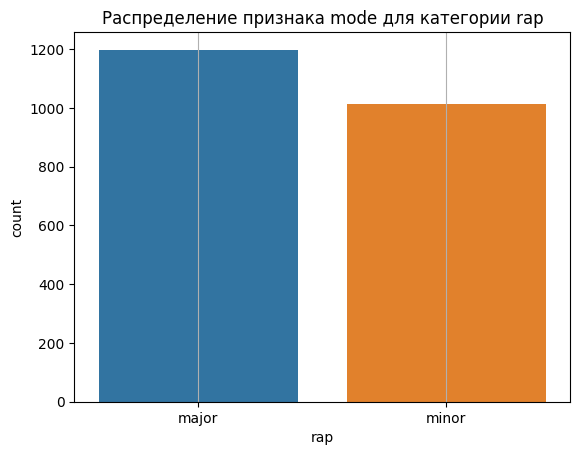

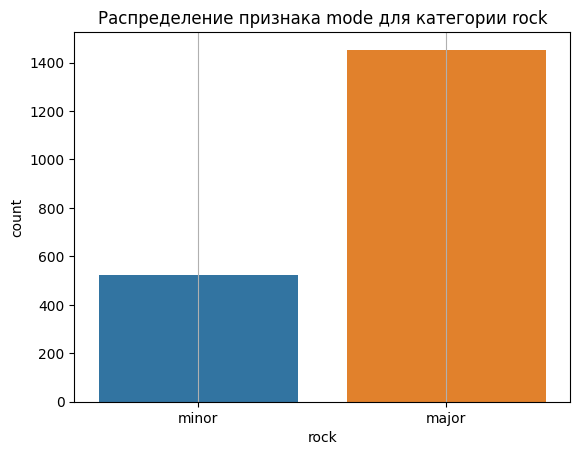

In [65]:
eda.create_category_countplot(data, 'music_genre', 'mode')

Во всех категориях преобладает модальность major. В каких-то категориях разница больше, а в каких-то меньше. Но в целом невозможно сделать какое-то разделение по категориям только по этому признаку

# 4. <a id='toc4_'></a>[Построение baseline](#toc0_)

Получим датасет без колонок:
* `instance_id - уникальный идентификатор трека`
* `track_name - название трека`
* `obtained_date - дата загрузки в сервис`
Так как они никак не помогут в обучении модели

In [66]:
data_baseline = preprocessing.delete_unnecessary_columns(
    utils.get_data(),
    ['instance_id', 'track_name', 'obtained_date']
)

In [67]:
data_baseline.dropna(inplace=True)
data_baseline = data_baseline.query('duration_ms != -1')

In [68]:
features, target = preprocessing.get_features_target(data_baseline)

In [69]:
features_train, features_test, target_train, target_test = preprocessing.get_samples(data_baseline)

In [70]:
categorical_limit = ['mode']
categorical_unlimit = ['key']

In [71]:
encoder_limit = constants.ENCODER_LIMIT.fit(features_train[categorical_limit])
encoder_unlimit = constants.ENCODER_UNLIMIT.fit(features_train[categorical_unlimit])
!

In [72]:
features_train = preprocessing.ohe(features_train, encoder_limit, categorical_limit)
features_train = preprocessing.ohe(features_train, encoder_unlimit, categorical_unlimit)
features_test = preprocessing.ohe(features_test, encoder_limit, categorical_limit)
features_test = preprocessing.ohe(features_test, encoder_unlimit, categorical_unlimit)

In [73]:
numeric = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [74]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
!

In [75]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [76]:
train_model.research_model(
    constants.MODEL_LOG_REGRESSION,
    constants.GSCV_LOG_REGRESSION_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

params  mean_train_score  \
76  {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373843   
60   {'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373879   
52   {'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373876   
44   {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373896   
68   {'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373868   
36    {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373873   
20    {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373911   
28    {'C': 25, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373901   
12     {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.373515   
4    {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.371074   

    mean_test_score  
76         0.366496  
60         0.366494  
52         0.366494  
44         0.366494  
68         0.366490  
36         0.366465  
20         0.366417  
28         0.366415  
12         0.366226  
4          0.364933

params	mean_train_score	mean_test_score  
76	{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}	0.373843	0.366496  
60	{'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}	0.373879	0.366494  
52	{'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}	0.373876	0.366494  
44	{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}	0.373896	0.366494  
68	{'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}	0.373868	0.366490  

In [77]:
train_model.research_model(
    constants.MODEL_TREE,
    constants.GSCV_TREE_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
8   {'max_depth': 9}          0.486083         0.372794
9  {'max_depth': 10}          0.536658         0.368470
7   {'max_depth': 8}          0.439160         0.361885
6   {'max_depth': 7}          0.402937         0.353825
5   {'max_depth': 6}          0.362168         0.331058
4   {'max_depth': 5}          0.332263         0.312589
3   {'max_depth': 4}          0.298658         0.286413
2   {'max_depth': 3}          0.236056         0.230261
1   {'max_depth': 2}          0.144078         0.142420
0   {'max_depth': 1}          0.098633         0.097606

params	mean_train_score	mean_test_score  
8	{'max_depth': 9}	0.486083	0.372794  
9	{'max_depth': 10}	0.536658	0.368470  
7	{'max_depth': 8}	0.439160	0.361885  
6	{'max_depth': 7}	0.402937	0.353825  
5	{'max_depth': 6}	0.362168	0.331058  

In [78]:
train_model.research_model(
    constants.MODEL_RAND_FOREST,
    constants.GSCV_RAND_FOREST_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
373  {'max_depth': 10, 'n_estimators': 21}          0.588044         0.401826
382  {'max_depth': 10, 'n_estimators': 66}          0.594250         0.401604
384  {'max_depth': 10, 'n_estimators': 76}          0.595291         0.401067
383  {'max_depth': 10, 'n_estimators': 71}          0.594681         0.400911
381  {'max_depth': 10, 'n_estimators': 61}          0.594668         0.400674
380  {'max_depth': 10, 'n_estimators': 56}          0.594300         0.400668
378  {'max_depth': 10, 'n_estimators': 46}          0.592803         0.400356
385  {'max_depth': 10, 'n_estimators': 81}          0.595958         0.399972
386  {'max_depth': 10, 'n_estimators': 86}          0.596371         0.399890
379  {'max_depth': 10, 'n_estimators': 51}          0.592255         0.399714

params	mean_train_score	mean_test_score  
373	{'max_depth': 10, 'n_estimators': 21}	0.588044	0.401826  
382	{'max_depth': 10, 'n_estimators': 66}	0.594250	0.401604  
384	{'max_depth': 10, 'n_estimators': 76}	0.595291	0.401067  
383	{'max_depth': 10, 'n_estimators': 71}	0.594681	0.400911  
381	{'max_depth': 10, 'n_estimators': 61}	0.594668	0.400674  

Лучшее качество показала модель случайного леса с глубиной 10 и количеством решателей 21. Метрика `f1beta` на валидационной выборке равно 0.402

# 5. <a id='toc5_'></a>[Эксперимент: борьба с дисбалансов с помощью `class_weight='balanced'`](#toc0_)

In [79]:
model_linear_balanced = LogisticRegression(
    class_weight='balanced',
    max_iter=500, 
    random_state=constants.RANDOM_STATE,
    n_jobs=-1
)

In [80]:
train_model.research_model(
    model_linear_balanced,
    constants.GSCV_LOG_REGRESSION_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(


d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

params  mean_train_score  \
35  {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}          0.388806   
27  {'C': 25, 'penalty': 'l1', 'solver': 'liblinear'}          0.388728   
77  {'C': 1000, 'penalty': 'l2', 'solver': 'liblin...          0.388814   
69  {'C': 750, 'penalty': 'l2', 'solver': 'libline...          0.388814   
61  {'C': 500, 'penalty': 'l2', 'solver': 'libline...          0.388814   
53  {'C': 250, 'penalty': 'l2', 'solver': 'libline...          0.388831   
75  {'C': 1000, 'penalty': 'l1', 'solver': 'liblin...          0.388846   
67  {'C': 750, 'penalty': 'l1', 'solver': 'libline...          0.388832   
59  {'C': 500, 'penalty': 'l1', 'solver': 'libline...          0.388846   
51  {'C': 250, 'penalty': 'l1', 'solver': 'libline...          0.388820   

    mean_test_score  
35         0.380662  
27         0.380649  
77         0.380613  
69         0.380613  
61         0.380613  
53         0.380613  
75         0.380531  
67         0.380531  
59         0.380530  
51         0.380530

params	mean_train_score	mean_test_score  
35	{'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}	0.388806	0.380662  
27	{'C': 25, 'penalty': 'l1', 'solver': 'liblinear'}	0.388728	0.380649  
77	{'C': 1000, 'penalty': 'l2', 'solver': 'liblin...	0.388814	0.380613  
69	{'C': 750, 'penalty': 'l2', 'solver': 'libline...	0.388814	0.380613  
61	{'C': 500, 'penalty': 'l2', 'solver': 'libline...	0.388814	0.380613  

In [81]:
model_tree_balanced = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=constants.RANDOM_STATE
)

In [82]:
train_model.research_model(
    model_tree_balanced,
    constants.GSCV_TREE_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
9  {'max_depth': 10}          0.526934         0.381629
8   {'max_depth': 9}          0.481460         0.375295
7   {'max_depth': 8}          0.445357         0.368801
6   {'max_depth': 7}          0.408657         0.363146
5   {'max_depth': 6}          0.352726         0.323271
4   {'max_depth': 5}          0.317885         0.297737
3   {'max_depth': 4}          0.257962         0.246093
2   {'max_depth': 3}          0.191522         0.185901
1   {'max_depth': 2}          0.128522         0.126925
0   {'max_depth': 1}          0.086102         0.085532

params	mean_train_score	mean_test_score  
9	{'max_depth': 10}	0.526934	0.381629  
8	{'max_depth': 9}	0.481460	0.375295  
7	{'max_depth': 8}	0.445357	0.368801  
6	{'max_depth': 7}	0.408657	0.363146  
5	{'max_depth': 6}	0.352726	0.323271  

In [83]:
model_rand_forest_balanced = RandomForestClassifier(
    class_weight='balanced',
    random_state=constants.RANDOM_STATE,
    n_jobs=-1,
)

In [84]:
train_model.research_model(
    model_rand_forest_balanced,
    constants.GSCV_RAND_FOREST_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
396  {'max_depth': 10, 'n_estimators': 136}          0.667423         0.420135
398  {'max_depth': 10, 'n_estimators': 146}          0.666233         0.419244
399  {'max_depth': 10, 'n_estimators': 151}          0.667239         0.419232
395  {'max_depth': 10, 'n_estimators': 131}          0.666570         0.419203
397  {'max_depth': 10, 'n_estimators': 141}          0.666590         0.418865
387   {'max_depth': 10, 'n_estimators': 91}          0.664352         0.418803
400  {'max_depth': 10, 'n_estimators': 156}          0.666460         0.418506
401  {'max_depth': 10, 'n_estimators': 161}          0.666902         0.418118
394  {'max_depth': 10, 'n_estimators': 126}          0.666435         0.418024
390  {'max_depth': 10, 'n_estimators': 106}          0.664379         0.418016

params	mean_train_score	mean_test_score  
396	{'max_depth': 10, 'n_estimators': 136}	0.667423	0.420135  
398	{'max_depth': 10, 'n_estimators': 146}	0.666233	0.419244  
399	{'max_depth': 10, 'n_estimators': 151}	0.667239	0.419232  
395	{'max_depth': 10, 'n_estimators': 131}	0.666570	0.419203  
397	{'max_depth': 10, 'n_estimators': 141}	0.666590	0.418865  

Использование весов для классов в качестве борьбы с дисбалансом позволило увеличить целевую метрику. Лучшая модель по прежнему модель случайного леса с максимальной глубиной 10 и количеством решателей 136. Метрика `f1beta` равно 0.420

# 6. <a id='toc6_'></a>[Эксперимент: борьба с дисбалансов с помощью `upsample`](#toc0_)

In [85]:
data = preprocessing.delete_unnecessary_columns(
    utils.get_data(),
    ['instance_id', 'track_name', 'obtained_date']
)

In [86]:
data.dropna(inplace=True)
data = data.query('duration_ms != -1')

In [87]:
features_train, features_test, target_train, target_test = preprocessing.get_samples(data)

In [88]:
categorical_limit = ['mode']
categorical_unlimit = ['key']

In [89]:
encoder_limit = constants.ENCODER_LIMIT.fit(features_train[categorical_limit])
encoder_unlimit = constants.ENCODER_UNLIMIT.fit(features_train[categorical_unlimit])
!

In [90]:
features_train = preprocessing.ohe(features_train, encoder_limit, categorical_limit)
features_train = preprocessing.ohe(features_train, encoder_unlimit, categorical_unlimit)
features_test = preprocessing.ohe(features_test, encoder_limit, categorical_limit)
features_test = preprocessing.ohe(features_test, encoder_unlimit, categorical_unlimit)

In [91]:
numeric = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [92]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
!

In [93]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [94]:
features_train, target_train = preprocessing.upsample(features_train, target_train)

In [95]:
train_model.research_model(
    constants.MODEL_LOG_REGRESSION,
    constants.GSCV_LOG_REGRESSION_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(


d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

params  mean_train_score  \
12     {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.395859   
20    {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396153   
4    {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.395507   
28    {'C': 25, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396178   
60   {'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396186   
52   {'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396154   
44   {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396206   
76  {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396188   
68   {'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396175   
36    {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}          0.396199   

    mean_test_score  
12         0.386654  
20         0.386432  
4          0.386431  
28         0.386318  
60         0.386317  
52         0.386316  
44         0.386316  
76         0.386315  
68         0.386315  
36         0.386315

params	mean_train_score	mean_test_score  
12	{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}	0.395859	0.386654  
20	{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}	0.396153	0.386432  
4	{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}	0.395507	0.386431  
28	{'C': 25, 'penalty': 'l2', 'solver': 'lbfgs'}	0.396178	0.386318  
60	{'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}	0.396186	0.386317  

In [96]:
train_model.research_model(
    constants.MODEL_TREE,
    constants.GSCV_TREE_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
9  {'max_depth': 10}          0.541190         0.412445
8   {'max_depth': 9}          0.498290         0.406696
7   {'max_depth': 8}          0.453733         0.393944
6   {'max_depth': 7}          0.419864         0.381099
5   {'max_depth': 6}          0.377938         0.353988
4   {'max_depth': 5}          0.320802         0.306421
3   {'max_depth': 4}          0.269397         0.261303
2   {'max_depth': 3}          0.205363         0.202959
1   {'max_depth': 2}          0.150699         0.147622
0   {'max_depth': 1}          0.101219         0.100984

params	mean_train_score	mean_test_score  
9	{'max_depth': 10}	0.541190	0.412445  
8	{'max_depth': 9}	0.498290	0.406696  
7	{'max_depth': 8}	0.453733	0.393944  
6	{'max_depth': 7}	0.419864	0.381099  
5	{'max_depth': 6}	0.377938	0.353988  

In [97]:
train_model.research_model(
    constants.MODEL_RAND_FOREST,
    constants.GSCV_RAND_FOREST_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
405  {'max_depth': 10, 'n_estimators': 181}          0.655135         0.470477
402  {'max_depth': 10, 'n_estimators': 166}          0.654520         0.470376
397  {'max_depth': 10, 'n_estimators': 141}          0.654918         0.470072
398  {'max_depth': 10, 'n_estimators': 146}          0.654343         0.470023
404  {'max_depth': 10, 'n_estimators': 176}          0.654352         0.469887
407  {'max_depth': 10, 'n_estimators': 191}          0.655309         0.469821
403  {'max_depth': 10, 'n_estimators': 171}          0.654200         0.469553
406  {'max_depth': 10, 'n_estimators': 186}          0.655347         0.469526
400  {'max_depth': 10, 'n_estimators': 156}          0.653705         0.469417
408  {'max_depth': 10, 'n_estimators': 196}          0.655381         0.469241

params	mean_train_score	mean_test_score  
405	{'max_depth': 10, 'n_estimators': 181}	0.655135	0.470477  
402	{'max_depth': 10, 'n_estimators': 166}	0.654520	0.470376  
397	{'max_depth': 10, 'n_estimators': 141}	0.654918	0.470072  
398	{'max_depth': 10, 'n_estimators': 146}	0.654343	0.470023  
404	{'max_depth': 10, 'n_estimators': 176}	0.654352	0.469887  

Метод upsample лучше показал себя в качестве метода борьбы с дисбалансов. Метрика выросла. Лучшая модель - модель случайного леса с глубиной 10 и количеством решателй 181. Метрика `f1beta` равно 0.470

# 7. <a id='toc7_'></a>[Эксперимент: борьба с дисбалансов с помощью `upsample` и удаление выбросов](#toc0_)

In [113]:
data = preprocessing.delete_unnecessary_columns(
    utils.get_data(),
    ['instance_id', 'track_name', 'obtained_date']
)

In [114]:
data.dropna(inplace=True)
data = data.query('duration_ms != -1')

In [115]:
numeric_columns = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [116]:
data = preprocessing.removing_outliers_by_category(data, numeric_columns)

In [118]:
features_train, features_test, target_train, target_test = preprocessing.get_samples(data)

In [119]:
categorical_limit = ['mode']
categorical_unlimit = ['key']

In [120]:
encoder_limit = constants.ENCODER_LIMIT.fit(features_train[categorical_limit])
encoder_unlimit = constants.ENCODER_UNLIMIT.fit(features_train[categorical_unlimit])
!

In [121]:
features_train = preprocessing.ohe(features_train, encoder_limit, categorical_limit)
features_train = preprocessing.ohe(features_train, encoder_unlimit, categorical_unlimit)
features_test = preprocessing.ohe(features_test, encoder_limit, categorical_limit)
features_test = preprocessing.ohe(features_test, encoder_unlimit, categorical_unlimit)

In [122]:
numeric = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [123]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
!

In [124]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [125]:
features_train, target_train = preprocessing.upsample(features_train, target_train)

In [126]:
train_model.research_model(
    constants.MODEL_LOG_REGRESSION,
    constants.GSCV_LOG_REGRESSION_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

params  mean_train_score  \
68     {'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}          0.496246   
60     {'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}          0.494366   
52     {'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}          0.494386   
76    {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}          0.494657   
44     {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}          0.492100   
36      {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}          0.491480   
28      {'C': 25, 'penalty': 'l2', 'solver': 'lbfgs'}          0.490315   
20      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.488506   
12       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.484033   
59  {'C': 500, 'penalty': 'l1', 'solver': 'libline...          0.481029   

    mean_test_score  
68         0.482279  
60         0.480994  
52         0.480993  
76         0.480393  
44         0.479644  
36         0.478527  
28         0.477945  
20         0.474372  
12         0.469563  
59         0.467052

params	mean_train_score	mean_test_score  
68	{'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}	0.496246	0.482279  
60	{'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}	0.494366	0.480994  
52	{'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}	0.494386	0.480993  
76	{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}	0.494657	0.480393  
44	{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}	0.492100	0.479644  

In [127]:
train_model.research_model(
    constants.MODEL_TREE,
    {
        'max_depth': range(1, 11)
    },
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
9  {'max_depth': 10}          0.606520         0.494087
8   {'max_depth': 9}          0.568450         0.485065
7   {'max_depth': 8}          0.525882         0.468872
6   {'max_depth': 7}          0.485694         0.446199
5   {'max_depth': 6}          0.445673         0.415367
4   {'max_depth': 5}          0.400109         0.384117
3   {'max_depth': 4}          0.329566         0.323277
2   {'max_depth': 3}          0.249052         0.247545
1   {'max_depth': 2}          0.175442         0.173509
0   {'max_depth': 1}          0.110517         0.109620

params	mean_train_score	mean_test_score  
9	{'max_depth': 10}	0.606520	0.494087  
8	{'max_depth': 9}	0.568450	0.485065  
7	{'max_depth': 8}	0.525882	0.468872  
6	{'max_depth': 7}	0.485694	0.446199  
5	{'max_depth': 6}	0.445673	0.415367  

In [128]:
train_model.research_model(
    constants.MODEL_RAND_FOREST,
    constants.GSCV_RAND_FOREST_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
406  {'max_depth': 10, 'n_estimators': 186}          0.747904         0.558424
408  {'max_depth': 10, 'n_estimators': 196}          0.748147         0.558087
407  {'max_depth': 10, 'n_estimators': 191}          0.748106         0.557934
409  {'max_depth': 10, 'n_estimators': 201}          0.748303         0.557087
405  {'max_depth': 10, 'n_estimators': 181}          0.748255         0.556700
404  {'max_depth': 10, 'n_estimators': 176}          0.747837         0.555748
389  {'max_depth': 10, 'n_estimators': 101}          0.746521         0.555413
387   {'max_depth': 10, 'n_estimators': 91}          0.744386         0.555359
391  {'max_depth': 10, 'n_estimators': 111}          0.745388         0.555154
388   {'max_depth': 10, 'n_estimators': 96}          0.745320         0.554679

params	mean_train_score	mean_test_score  
406	{'max_depth': 10, 'n_estimators': 186}	0.747904	0.558424  
408	{'max_depth': 10, 'n_estimators': 196}	0.748147	0.558087  
407	{'max_depth': 10, 'n_estimators': 191}	0.748106	0.557934  
409	{'max_depth': 10, 'n_estimators': 201}	0.748303	0.557087  
405	{'max_depth': 10, 'n_estimators': 181}	0.748255	0.556700  

Удаление выбросов позволило увеличить целевую метрику. Лучшая модель - модель случайного леса с глубиной 10 и количеством решателей 186. Целевая метрика `f1beta` равна 0.558

# 8. <a id='toc8_'></a>[Эксперимент: борьба с дисбалансов с помощью `upsample` и удаление выбросов. Заполнение пропусков для tempo и duration_ms](#toc0_)

In [2]:
data = preprocessing.delete_unnecessary_columns(
    utils.get_data(),
    ['instance_id', 'track_name', 'obtained_date']
)

In [3]:
numeric_columns = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [4]:
data = preprocessing.removing_outliers_by_category(data, numeric_columns)

In [5]:
data.loc[data['tempo'].isna(), 'tempo'] = data[
    data['tempo'].isna()
].apply(preprocessing.get_tempo, axis=1)
data.loc[data['duration_ms'] < 0, 'duration_ms'] = data[
    data['duration_ms'] < 0
].apply(preprocessing.get_duration, axis=1)

In [6]:
data.dropna(inplace=True)

In [8]:
features_train, features_test, target_train, target_test = preprocessing.get_samples(data)

In [9]:
categorical_limit = ['mode']
categorical_unlimit = ['key']

In [10]:
encoder_limit = constants.ENCODER_LIMIT.fit(features_train[categorical_limit])
encoder_unlimit = constants.ENCODER_UNLIMIT.fit(features_train[categorical_unlimit])
!

In [11]:
features_train = preprocessing.ohe(features_train, encoder_limit, categorical_limit)
features_train = preprocessing.ohe(features_train, encoder_unlimit, categorical_unlimit)
features_test = preprocessing.ohe(features_test, encoder_limit, categorical_limit)
features_test = preprocessing.ohe(features_test, encoder_unlimit, categorical_unlimit)

In [12]:
numeric = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [13]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
!

In [14]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [15]:
features_train, target_train = preprocessing.upsample(features_train, target_train)

In [16]:
train_model.research_model(
    constants.MODEL_LOG_REGRESSION,
    constants.GSCV_LOG_REGRESSION_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

params  mean_train_score  \
76    {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}          0.500292   
68     {'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}          0.501070   
52     {'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}          0.498669   
60     {'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}          0.499153   
36      {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}          0.494927   
44     {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}          0.496073   
28      {'C': 25, 'penalty': 'l2', 'solver': 'lbfgs'}          0.493579   
20      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.491767   
12       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.485868   
67  {'C': 750, 'penalty': 'l1', 'solver': 'libline...          0.486035   

    mean_test_score  
76         0.487271  
68         0.486710  
52         0.486070  
60         0.484958  
36         0.483664  
44         0.483566  
28         0.482875  
20         0.481844  
12         0.474866  
67         0.470578

params	mean_train_score	mean_test_score  
76	{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}	0.500292	0.487271  
68	{'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}	0.501070	0.486710  
52	{'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}	0.498669	0.486070  
60	{'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}	0.499153	0.484958  
36	{'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}	0.494927	0.483664  

In [17]:
train_model.research_model(
    constants.MODEL_TREE,
    constants.GSCV_TREE_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
9  {'max_depth': 10}          0.612937         0.482773
7   {'max_depth': 8}          0.532352         0.472765
8   {'max_depth': 9}          0.563884         0.469859
6   {'max_depth': 7}          0.491475         0.445604
5   {'max_depth': 6}          0.460316         0.430839
4   {'max_depth': 5}          0.413551         0.402691
3   {'max_depth': 4}          0.339227         0.332171
2   {'max_depth': 3}          0.242939         0.239993
1   {'max_depth': 2}          0.177431         0.176052
0   {'max_depth': 1}          0.113631         0.113638

params	mean_train_score	mean_test_score  
9	{'max_depth': 10}	0.612937	0.482773  
7	{'max_depth': 8}	0.532352	0.472765  
8	{'max_depth': 9}	0.563884	0.469859  
6	{'max_depth': 7}	0.491475	0.445604  
5	{'max_depth': 6}	0.460316	0.430839  

In [32]:
train_model.research_model(
    constants.MODEL_RAND_FOREST,
    constants.GSCV_RAND_FOREST_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
398  {'max_depth': 10, 'n_estimators': 146}          0.728526         0.539049
397  {'max_depth': 10, 'n_estimators': 141}          0.728381         0.538842
395  {'max_depth': 10, 'n_estimators': 131}          0.728413         0.538625
396  {'max_depth': 10, 'n_estimators': 136}          0.728725         0.538582
399  {'max_depth': 10, 'n_estimators': 151}          0.728339         0.538160
401  {'max_depth': 10, 'n_estimators': 161}          0.729250         0.538032
400  {'max_depth': 10, 'n_estimators': 156}          0.728489         0.537853
394  {'max_depth': 10, 'n_estimators': 126}          0.728341         0.537475
402  {'max_depth': 10, 'n_estimators': 166}          0.729479         0.537141
385   {'max_depth': 10, 'n_estimators': 81}          0.721184         0.536372

params	mean_train_score	mean_test_score  
408	{'max_depth': 10, 'n_estimators': 196}	0.731013	0.535491  
378	{'max_depth': 10, 'n_estimators': 46}	0.719301	0.535437  
405	{'max_depth': 10, 'n_estimators': 181}	0.731507	0.534528  
402	{'max_depth': 10, 'n_estimators': 166}	0.730913	0.534093  
403	{'max_depth': 10, 'n_estimators': 171}	0.730604	0.534068  

Полученный метод заполнения пропусков в столбцах `tempo` и `duration_ms` не дало увеличения метрики. Наоборот у лучшей модели значение метрики снизилось до 0.535. Но так как в тестовых данных также присутствую пропуски в этих столбцах, оставим данный принцип заполнения пропусков

# 9. <a id='toc9_'></a>[Эксперимент: борьба с дисбалансов с помощью `upsample` и удаление выбросов. Заполнение пропусков для tempo и duration_ms. Удаление столбцов key, mode](#toc0_)

In [19]:
data = preprocessing.delete_unnecessary_columns(
    utils.get_data(),
    ['instance_id', 'track_name', 'obtained_date', 'key', 'mode']
)

In [20]:
numeric_columns = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [21]:
data = preprocessing.removing_outliers_by_category(data, numeric_columns)

In [22]:
data.loc[data['tempo'].isna(), 'tempo'] = data[
    data['tempo'].isna()
].apply(preprocessing.get_tempo, axis=1)
data.loc[data['duration_ms'] < 0, 'duration_ms'] = data[
    data['duration_ms'] < 0
].apply(preprocessing.get_duration, axis=1)

In [24]:
features_train, features_test, target_train, target_test = preprocessing.get_samples(data)

In [25]:
numeric = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [26]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
!

In [27]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [28]:
features_train, target_train = preprocessing.upsample(features_train, target_train)

In [29]:
train_model.research_model(
    constants.MODEL_LOG_REGRESSION,
    constants.GSCV_LOG_REGRESSION_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(
d:\practicum\music_genre\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver'

params  mean_train_score  \
76    {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}          0.486084   
60     {'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}          0.486034   
68     {'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}          0.485784   
52     {'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}          0.484444   
44     {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}          0.483922   
36      {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}          0.482752   
28      {'C': 25, 'penalty': 'l2', 'solver': 'lbfgs'}          0.481912   
20      {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}          0.479950   
12       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}          0.473423   
59  {'C': 500, 'penalty': 'l1', 'solver': 'libline...          0.466196   

    mean_test_score  
76         0.477793  
60         0.476790  
68         0.476582  
52         0.475423  
44         0.474130  
36         0.472457  
28         0.472046  
20         0.470469  
12         0.464400  
59         0.461658

params	mean_train_score	mean_test_score  
76	{'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}	0.486084	0.477793  
60	{'C': 500, 'penalty': 'l2', 'solver': 'lbfgs'}	0.486034	0.476790  
68	{'C': 750, 'penalty': 'l2', 'solver': 'lbfgs'}	0.485784	0.476582  
52	{'C': 250, 'penalty': 'l2', 'solver': 'lbfgs'}	0.484444	0.475423  
44	{'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}	0.483922	0.474130  

In [30]:
train_model.research_model(
    constants.MODEL_TREE,
    constants.GSCV_TREE_CONFIG,
    features_train, target_train
).head()[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
9  {'max_depth': 10}          0.592966         0.476447
8   {'max_depth': 9}          0.552029         0.468415
7   {'max_depth': 8}          0.501578         0.447068
6   {'max_depth': 7}          0.471145         0.430296
5   {'max_depth': 6}          0.449494         0.420293

params	mean_train_score	mean_test_score  
9	{'max_depth': 10}	0.592966	0.476447  
8	{'max_depth': 9}	0.552029	0.468415  
7	{'max_depth': 8}	0.501578	0.447068  
6	{'max_depth': 7}	0.471145	0.430296  
5	{'max_depth': 6}	0.449494	0.420293  

In [31]:
train_model.research_model(
    constants.MODEL_RAND_FOREST,
    constants.GSCV_RAND_FOREST_CONFIG,
    features_train, target_train
)[['params', 'mean_train_score', 'mean_test_score']].head(10)

params  mean_train_score  mean_test_score
398  {'max_depth': 10, 'n_estimators': 146}          0.728526         0.539049
397  {'max_depth': 10, 'n_estimators': 141}          0.728381         0.538842
395  {'max_depth': 10, 'n_estimators': 131}          0.728413         0.538625
396  {'max_depth': 10, 'n_estimators': 136}          0.728725         0.538582
399  {'max_depth': 10, 'n_estimators': 151}          0.728339         0.538160
401  {'max_depth': 10, 'n_estimators': 161}          0.729250         0.538032
400  {'max_depth': 10, 'n_estimators': 156}          0.728489         0.537853
394  {'max_depth': 10, 'n_estimators': 126}          0.728341         0.537475
402  {'max_depth': 10, 'n_estimators': 166}          0.729479         0.537141
385   {'max_depth': 10, 'n_estimators': 81}          0.721184         0.536372

params	mean_train_score	mean_test_score  
398	{'max_depth': 10, 'n_estimators': 146}	0.728526	0.539049  
397	{'max_depth': 10, 'n_estimators': 141}	0.728381	0.538842  
395	{'max_depth': 10, 'n_estimators': 131}	0.728413	0.538625  
396	{'max_depth': 10, 'n_estimators': 136}	0.728725	0.538582  
399	{'max_depth': 10, 'n_estimators': 151}	0.728339	0.538160  

Удаление столбцов `mode`, `key` не дало увеличения метрики. Но и не ухудшило ее. Лучшей моделью стала модель случайного леса. Значение метрики `f1beta` на валидационной выборке равно 0.539

# 10. <a id='toc10_'></a>[Выводы](#toc0_)

По итогу, было решено делать следующую предобработку данных: удаление выбросов, заполнение пропусков в столбцах `tempo`, `duration_ms`, удаление столбцов `mode` и `key`, так как не было придумано нормального способа заполнить в них пропуски, а терять данные на тестовой выборке не хотелось. К тому же после удаления столбцов метрика не уменьшилась. Для данных условий лучше моделью стала модель случайного леса с максимальной глубиной 10 и количеством решателей 146.  
Также проводились попытки комбинировать различные признаки. Однако увеличения метрики добиться не получилось (эксперименты не представлены в данном решении, так как остались на другом компьютере). К сожалению не хватило времени провести эксперименты с более сложными моделями

# 11. <a id='toc11_'></a>[Первый вариант отправки результатов](#toc0_)

In [63]:
train = preprocessing.delete_unnecessary_columns(
    utils.get_data(),
    ['instance_id', 'track_name', 'obtained_date', 'key', 'mode']
)

In [64]:
test = pd.read_csv('./datasets/kaggle_music_genre_test.csv')
test = preprocessing.delete_unnecessary_columns(
    test,
    ['instance_id', 'track_name', 'obtained_date', 'key', 'mode']
)

In [65]:
result = pd.read_csv('./datasets/kaggle_music_genre_test.csv')

In [66]:
numeric_columns = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [67]:
train = preprocessing.removing_outliers_by_category(train, numeric_columns)

In [68]:
train.loc[train['tempo'].isna(), 'tempo'] = train[
    train['tempo'].isna()
].apply(preprocessing.get_tempo, axis=1)
train.loc[train['duration_ms'] < 0, 'duration_ms'] = train[
    train['duration_ms'] < 0
].apply(preprocessing.get_tempo, axis=1)

In [69]:
test.loc[test['tempo'].isna(), 'tempo'] = test[
    test['tempo'].isna()
].apply(preprocessing.get_tempo, axis=1)
test.loc[test['duration_ms'] < 0, 'duration_ms'] = test[
    test['duration_ms'] < 0
].apply(preprocessing.get_tempo, axis=1)

In [70]:
features_train, target_train = preprocessing.get_features_target(train)

In [71]:
numeric = [
    'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

In [72]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
!

In [73]:
features_train[numeric] = scaler.transform(features_train[numeric])
test[numeric] = scaler.transform(test[numeric])

In [74]:
features_train, target_train = preprocessing.upsample(features_train, target_train)

In [75]:
model_rand_forest = RandomForestClassifier(
    max_depth=10, n_estimators=146,
    random_state=constants.RANDOM_STATE,
    n_jobs=-1
)
model_rand_forest.fit(features_train, target_train)

RandomForestClassifier(max_depth=10, n_estimators=146, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x19755AD2D40)

In [76]:
result['music_genre'] = model_rand_forest.predict(test)

In [77]:
result = result[['instance_id', 'music_genre']]

In [78]:
result.to_csv('result.csv', index=False)